Following along with the appendix from: https://esajournals.onlinelibrary.wiley.com/doi/10.1002/ecm.1470

# Installation & Setup

In [1]:
# Mount in Python runtime, then change runtime to R
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Install system dependency for rjags on Google Colab
system("apt-get update && apt-get install -y jags")

In [2]:
# Function to load cached packages
load_cached_packages <- function(
  lib_path = "/content/drive/My Drive/R_libs",
  verbose = TRUE
) {
  # Prepend cached library to .libPaths
  .libPaths(c(lib_path, .libPaths()))

  # Get all package names in the lib
  pkgs <- installed.packages(lib.loc = lib_path)[, "Package"]

  # Attempt to load each one
  results <- vapply(pkgs, function(pkg) {
    ok <- suppressWarnings(
      require(pkg,
              lib.loc = lib_path,
              character.only = TRUE,
              quietly = TRUE)
    )
    if (verbose) {
      msg <- if (ok) "Loaded" else "Could not load"
      message(sprintf("%s package: %s", msg, pkg))
    }
    ok
  }, logical(1))

  invisible(results)
}

In [3]:
# Call the function
load_cached_packages(verbose = FALSE)


Attaching package: ‘dlm’


The following object is masked from ‘package:ggplot2’:

    %+%



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘e1071’


The following objects are masked from ‘package:distributional’:

    kurtosis, skewness


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'forecast':
  method  from 
  head.ts stats
  tail.ts stats


Attaching package: ‘future’


The following object is masked from ‘package:caret’:

    cluster



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘hardhat’


The following object is masked from ‘package:e1071’:

    tune


hash-2.2.6.3 provided by Decision Patterns


here() starts at /content

Registered S3 meth

In [4]:
# Function to add packages to cached library
install_and_cache_packages <- function(
    packages,
    lib_path = "/content/drive/My Drive/R_libs",
    repos = "http://cran.r-project.org"
) {
  # Ensure the drive‐based library exists
  if (!dir.exists(lib_path)) {
    dir.create(lib_path, recursive = TRUE, showWarnings = FALSE)
  }

  # Add the library to .libPaths()
  .libPaths(c(lib_path, .libPaths()))

  # Get already‐installed packages in the cache
  cached_pkgs <- installed.packages(lib.loc = lib_path)[, "Package"]

  # Install any packages that are missing
  to_install <- setdiff(packages, cached_pkgs)
  if (length(to_install)) {
    message("Installing: ", paste(to_install, collapse = ", "))
    install.packages(to_install, lib = lib_path, repos = repos)
  } else {
    message("All requested packages already installed.")
  }

  # Load packages
  invisible(
    lapply(packages, function(pkg) {
      library(pkg, character.only = TRUE, quietly = TRUE)
    })
  )
}

In [5]:
# Call the function
install_and_cache_packages(
  packages = c("reticulate")
)

All requested packages already installed.



In [6]:
# Path to the cached library
lib_path <- "/content/drive/My Drive/R_libs"

# List only the top‑level directories in lib_path
dirs <- list.dirs(path = lib_path, full.names = TRUE, recursive = FALSE)

# Find those directories whose basename ends with " (1)"
dup_dirs <- dirs[grepl(" \\(1\\)$", basename(dirs))]

if (length(dup_dirs) == 0) {
  cat("No duplicate package directories found.\n")
} else {
  cat("Deleting the following duplicate package directories:\n")
  cat(paste0(" - ", basename(dup_dirs)), sep = "\n")

  # Remove the duplicated directories recursively
  unlink(dup_dirs, recursive = TRUE, force = TRUE)

  cat("Deletion complete. Removed ", length(dup_dirs), " directories.\n", sep = "")
}

No duplicate package directories found.


In [7]:
# # Point R to the library
# .libPaths("/content/drive/My Drive/R_libs")

# # Uninstall from the library
# remove.packages("nimble", lib = "/content/drive/My Drive/R_libs")

In [8]:
# Print the cached packages
writeLines(c("Cached packages:", paste0("- ", unique(installed.packages(
  lib.loc = "/content/drive/My Drive/R_libs"
)[, "Package"]))))

Cached packages:
- abind
- BH
- caret
- checkmate
- clock
- coda
- denstrip
- deSolve
- diagram
- distributional
- dlm
- doParallel
- doRNG
- dplyr
- e1071
- foreach
- forecast
- fracdiff
- future
- future.apply
- ggplot2
- globals
- googledrive
- gower
- gridExtra
- hardhat
- hash
- here
- hoardr
- httpcode
- httr
- igraph
- inline
- ipred
- iterators
- lava
- listenv
- lmtest
- loo
- magrittr
- MASS
- matrixStats
- mcmcplots
- ModelMetrics
- mvtnorm
- nnet
- numDeriv
- parallelly
- plyr
- png
- pomp
- posterior
- pracma
- pROC
- prodlim
- progressr
- proxy
- quadprog
- quantmod
- QuickJSR
- randomForest
- RcppArmadillo
- RcppEigen
- RcppParallel
- RcppTOML
- recipes
- reshape2
- reticulate
- rjags
- rngtools
- rpart
- rstan
- sfsmisc
- shape
- sparsevctrs
- SQUAREM
- StanHeaders
- tensorA
- tidyr
- timeDate
- TMB
- triebeard
- tseries
- TTR
- urca
- xts
- zoo


In [9]:
# Set default plot size for the notebook
options(repr.plot.width = 14, repr.plot.height = 8)

# Data Simulation

In [10]:
# Number of steps after time 0
time_steps <- 200

# Pre‑allocate a vector of length (time_steps + 1):
#   states_z[1] will be z₀, states_z[2] will be z₁, …, states_z[time_steps+1] is z_{time_steps}
states_z <- numeric(time_steps + 1)

# Make the initial state explicit (optional)
states_z[1] <- 0  # z₀ = 0

# Standard deviation of the process noise w_t ~ N(0, process_var_stdev²)
process_var_stdev <- 0.1

# For reproducible noise draws
set.seed(42)

# Simulate the random walk:
#   z_t = z_{t-1} + w_t
# with t = 1…time_steps
for (t in 1:time_steps) {
  # states_z[t]   holds z_{t-1}
  # w_t           is rnorm(1, mean=0, sd=process_var_stdev)
  # states_z[t+1] will become z_t
  states_z[t + 1] <- states_z[t] + rnorm(1, mean = 0, sd = process_var_stdev)
}

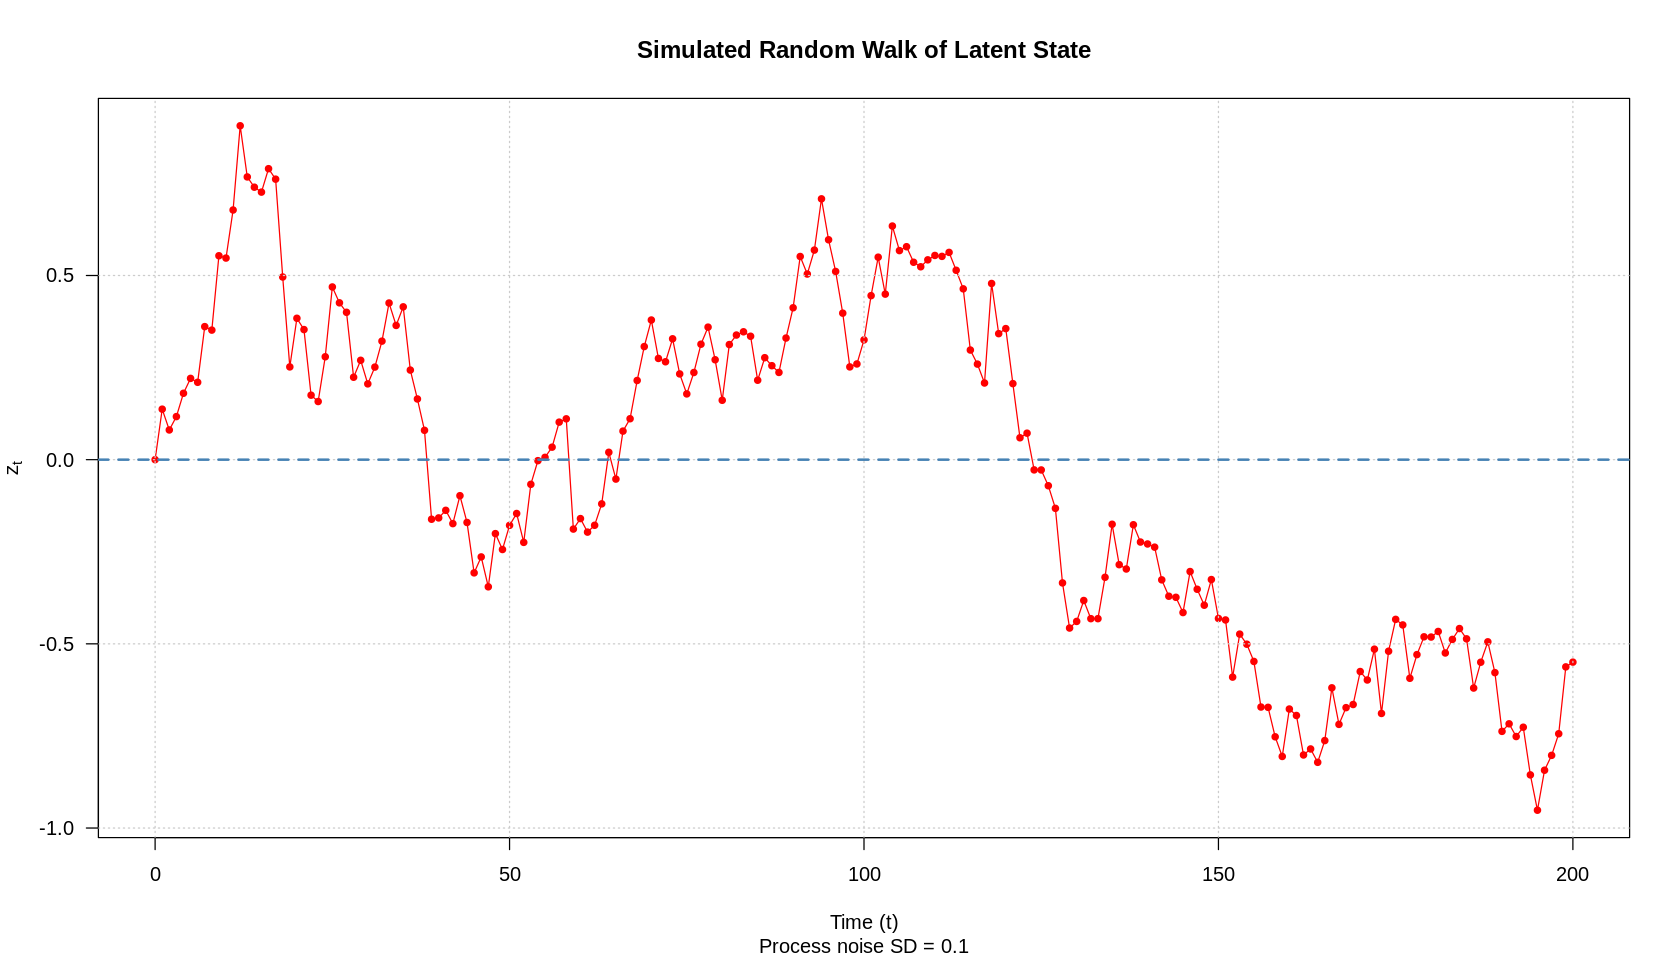

In [11]:
# Plot for the true states
plot(
    0:time_steps,
    states_z,
    pch = 19,
    cex = 0.7,
    col = "red",
    ty = "o",
    xlab = "Time (t)",
    ylab = expression(z[t]),
    las = 1,
    main = "Simulated Random Walk of Latent State",
    sub = paste("Process noise SD =", process_var_stdev),
)

# Add a grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

# Draw a dashed zero‐line
abline(
    h = 0,
    col = "steelblue",
    lwd = 2,
    lty = "dashed"
)

In [12]:
# Number of observation times (t = 1…time_steps)
n_obs <- time_steps

# Pre‐allocate a numeric vector to hold observations y₁…y_{n_obs}
obs_y <- numeric(n_obs)

# Measurement‐error standard deviation: vₜ ~ N(0, obs_error_stdev²)
obs_error_stdev <- 0.1

# Extract the "true" latent states at times 1…n_obs:
#   states_z[1] is z₀, so states_z[2] is z₁, …, states_z[n_obs+1] is z_{n_obs}
true_states <- states_z[2:(n_obs + 1)]

# Simulate measurement noise v₁…v_{n_obs}
measurement_noise <- rnorm(
    n = n_obs,
    mean = 0,
    sd = obs_error_stdev
)

# Generate observations: yₜ = zₜ + vₜ, for t = 1…n_obs
obs_y <- true_states + measurement_noise

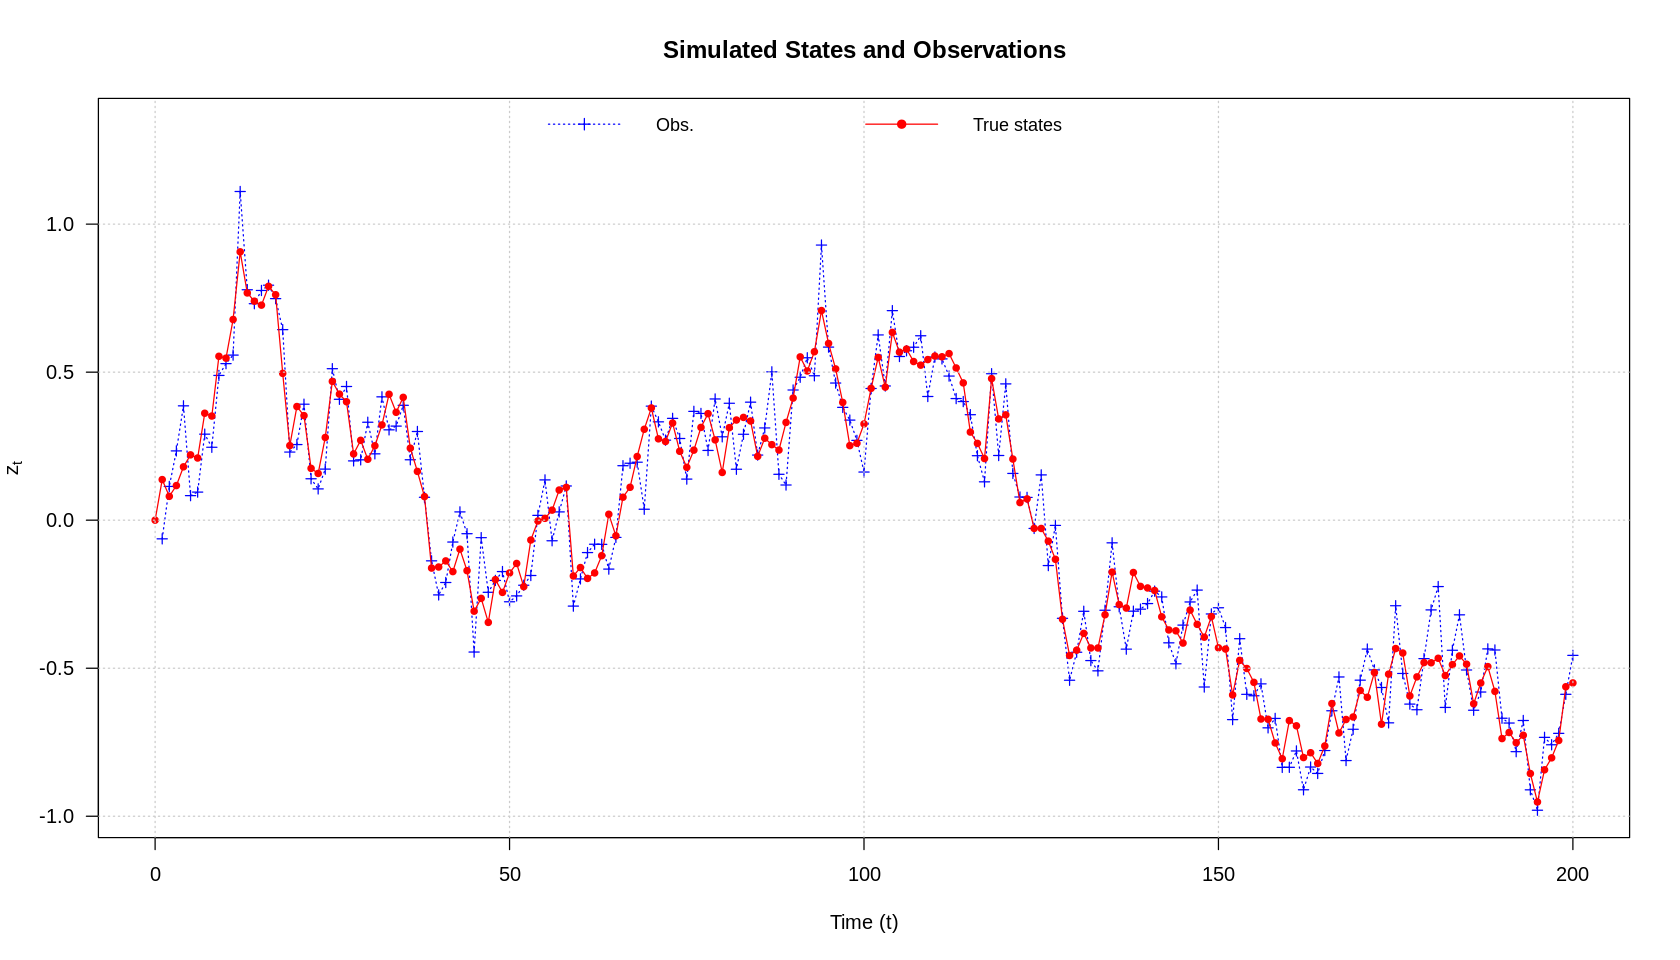

In [13]:
# Plot for the observations
plot(
    1:time_steps,
    obs_y,
    pch=3,
    cex = 0.8,
    col = "blue",
    ty = "o",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = c(min(obs_y), max(obs_y) + max(obs_y) / 5),
    las = 1,
    main = "Simulated States and Observations"
)

# Add the true states
points(
    0:time_steps,
    states_z,
    pch = 19,
    cex = 0.7,
    col = "red",
    ty = "o"
)

# Add a legend
legend(
    "top",
    legend = c("Obs.", "True states"),
    pch = c(3, 19),
    col = c("blue", "red"),
    lty = c(3, 1),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

# Add a grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

# DLM

In [14]:
# DLM parameter setup

# Initial latent state z₀
initial_state <- states_z[1]

# Variance of initial state
initial_var <- 0

# State‐transition coefficient (zₜ = GG · zₜ₋₁ + wₜ)
GG_coeff <- 1

# Process‐noise variance wₜ ~ N(0, W)
W_var <- process_var_stdev^2

# Observation‐matrix coefficient (yₜ = FF · zₜ + vₜ)
FF_coeff <- 1

# Observation‐noise variance vₜ ~ N(0, V)
V_var <- obs_error_stdev^2

In [15]:
# Build the DLM object
dlm_model <- dlm(
    m0 = initial_state,   # m₀ = E[z₀]
    C0 = initial_var,     # C₀ = Var[z₀]
    GG = GG_coeff,
    W = W_var,
    FF = FF_coeff,
    V = V_var
)

In [16]:
# Run the Kalman filter to get filtered state estimates
#   - observations_y is the vector y₁…y_T
#   - dlmFiltered$m gives the posterior means mₜ|t for t = 0…T
dlm_filtered <- dlmFilter(y = obs_y, mod = dlm_model)
filtered_states <- dlm_filtered$m   # length = time_steps + 1

In [17]:
# Recover filtered variances from the SVD output
#   - dlmFilter stores the filter covariance in U.C and D.C via SVD
filtered_vars <- unlist(
  dlmSvd2var(dlm_filtered$U.C,
             dlm_filtered$D.C)
)

In [18]:
# Compute 95% pointwise confidence intervals
alpha <- 0.05
z_lower <- filtered_states + qnorm(alpha / 2) * sqrt(filtered_vars)
z_upper <- filtered_states + qnorm(1 - alpha / 2) * sqrt(filtered_vars)

In [19]:
# Inspect the first few values
head(filtered_states)  # filtered means m₀, m₁, …
head(filtered_vars)    # Var(z₀|y₀), Var(z₁|y₁), …
head(z_lower)          # lower 95% CI
head(z_upper)          # upper 95% CI

[1]  0.00000000 -0.03149854  0.05580283  0.16550655  0.30180427  0.16656702

[1] 0.000000000 0.005000000 0.006000000 0.006153846 0.006176471 0.006179775

[1]  0.00000000 -0.17008892 -0.09601532  0.01175433  0.14776968  0.01249122

[1] 0.0000000 0.1070918 0.2076210 0.3192588 0.4558389 0.3206428

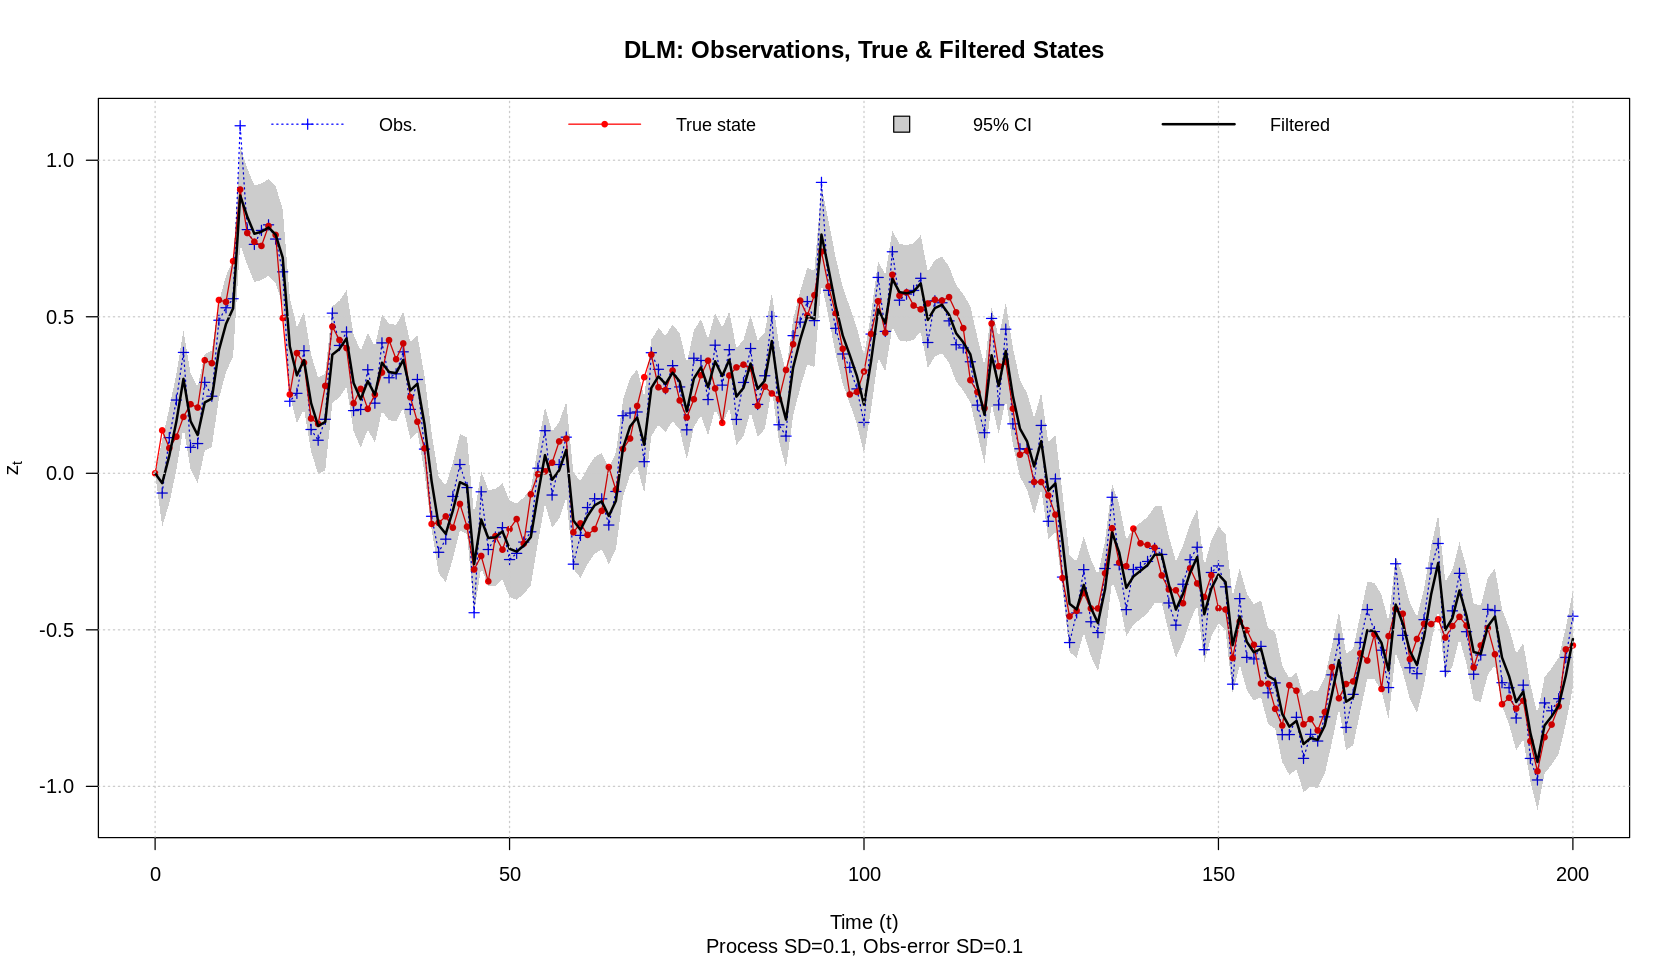

In [20]:
# Plot observations, true state, filter estimates, and CI

# Define time indices
time_idx <- 0:time_steps       # covers t = 0…time_steps
obs_time_idx <- 1:time_steps   # covers t = 1…time_steps

# Set up the base plot with observations
plot(
    obs_time_idx,
    obs_y,
    type = "o",          # points + lines
    pch = 3,             # open cross for observations
    cex = 0.8,
    col = "blue",
    lty = 3,             # dashed for obs line
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, z_lower, z_upper)),
    las = 1,
    main = "DLM: Observations, True & Filtered States",
    sub = paste0("Process SD=", process_var_stdev,
                ", Obs‑error SD=", obs_error_stdev)
)

# Add true latent state
points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Shade 95% filter confidence band
polygon(
    x = c(time_idx, rev(time_idx)),
    y = c(z_lower, rev(z_upper)),
    col = rgb(0, 0, 0, 0.2),
    border = NA
)

# Add filtered state estimates
lines(
    time_idx,
    filtered_states,
    lwd = 2,
    col = "black"
)

# Legend at top
legend(
    "top",
    legend = c("Obs.", "True state", "95% CI", "Filtered"),
    pch = c(3, 19, 22, NA),
    pt.bg = c(NA, NA, rgb(0, 0, 0, 0.2), NA),
    pt.cex = c(0.8, 0.6, 2, NA),
    lty = c(3, 1, NA, 1),
    lwd = c(1, 1, NA, 2),
    col = c("blue", "red", "black", "black"),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

# Add a grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [21]:
# Run the Kalman smoother to get smoothed state estimates
dlm_smoothed <- dlmSmooth(y = obs_y, mod = dlm_model)
smoothed_states <- dlm_smoothed$s   # m_{t|T} for t = 0…T

In [22]:
# Recover smoothed variances from the SVD output
smoothed_vars <- unlist(
    dlmSvd2var(dlm_smoothed$U.S,
               dlm_smoothed$D.S)
)

In [23]:
# Compute 95% pointwise confidence intervals for smoothed states
z_s_lower <- smoothed_states + qnorm(alpha / 2) * sqrt(smoothed_vars)
z_s_upper <- smoothed_states + qnorm(1 - alpha / 2) * sqrt(smoothed_vars)

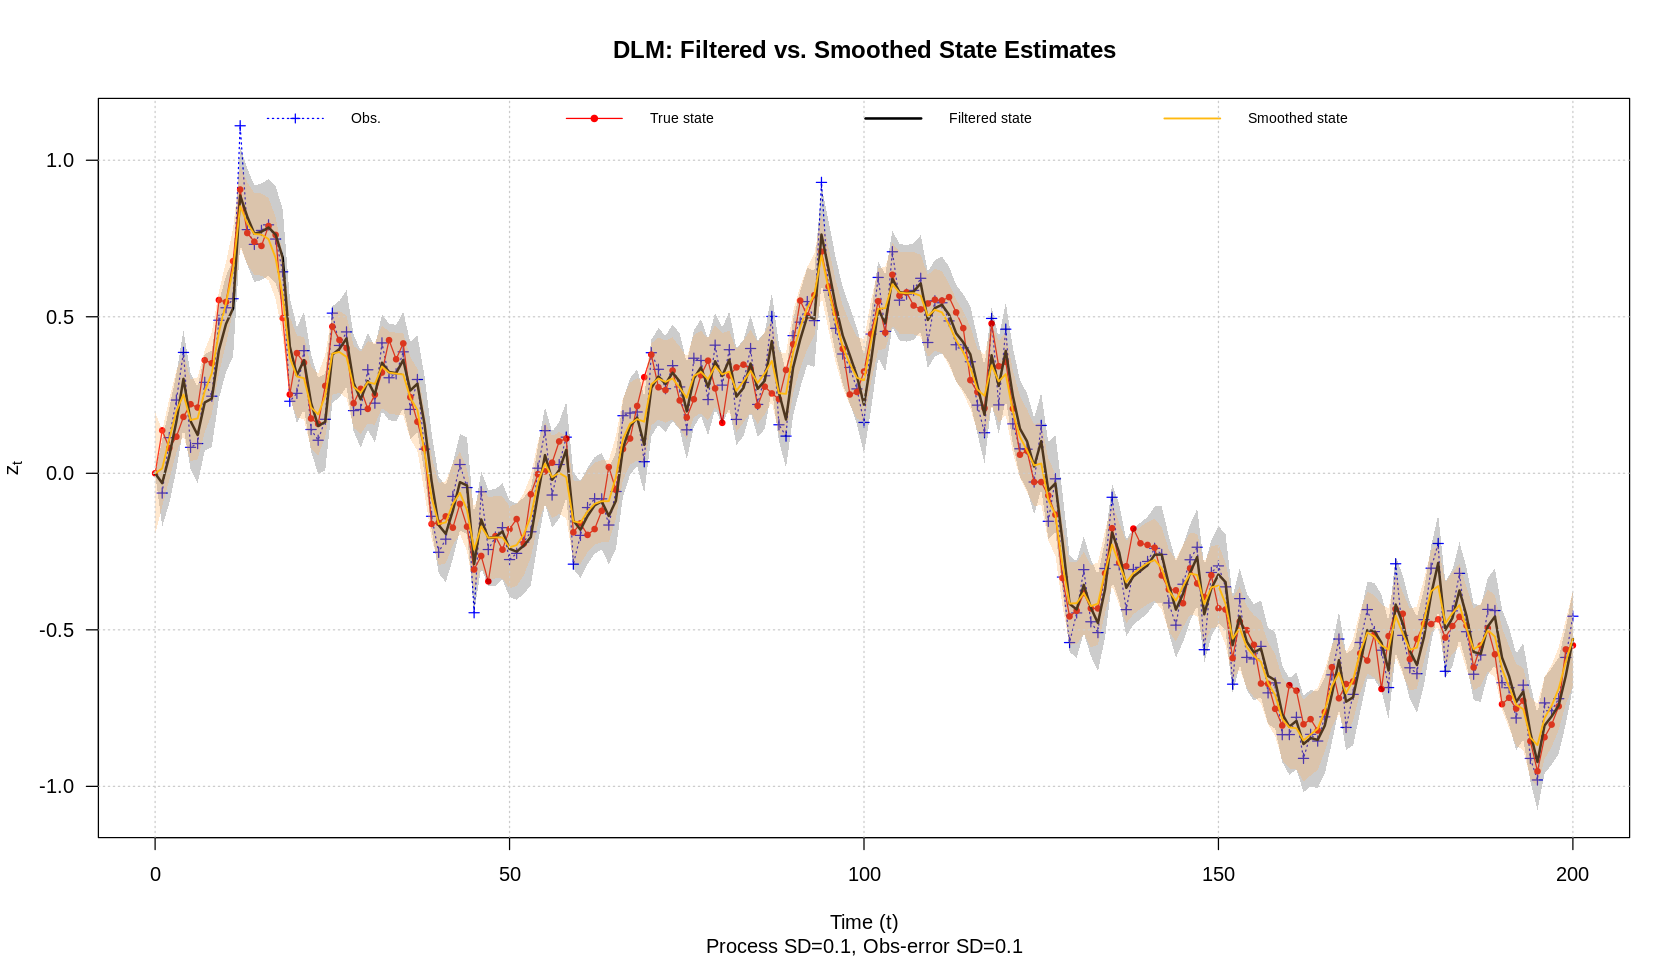

In [24]:
# Base plot of observations
plot(
    obs_time_idx,
    obs_y,
    type = "o",
    pch = 3,
    cex = 0.8,
    col = "blue",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, z_lower, z_upper, z_s_lower, z_s_upper)),
    las = 1,
    main = "DLM: Filtered vs. Smoothed State Estimates",
    sub = paste0("Process SD=", process_var_stdev,
                 ", Obs‑error SD=", obs_error_stdev)
)

# True latent state
points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Filtered 95% CI
polygon(
    x = c(time_idx, rev(time_idx)),
    y = c(z_lower, rev(z_upper)),
    col = rgb(0, 0, 0, 0.2),
    border = NA
)

# Filtered state estimates
lines(
    time_idx,
    filtered_states,
    lwd = 2,
    col = "black"
)

# Smoothed 95% CI
polygon(
    x = c(time_idx, rev(time_idx)),
    y = c(z_s_lower, rev(z_s_upper)),
    col = rgb(1, 0.7, 0.4, 0.3),
    border = NA
)

# Smoothed state estimates
lines(
    time_idx,
    smoothed_states,
    lwd = 1.5,
    col = "darkgoldenrod1"
)

# Legend at top
legend(
    "top",
    legend = c("Obs.", "True state", "Filtered state", "Smoothed state"),
    pch = c(3, 19, NA, NA),
    lty = c(3, 1, 1, 1),
    lwd = c(1, 1, 2, 1.5),
    col = c("blue", "red", "black", "darkgoldenrod1"),
    horiz = TRUE,
    bty = "n",
    cex = 0.7
)

# Add a grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [25]:
# Parameter estimation via MLE

# Build DLM given log‑variances theta = c(log(W), log(V))
dlm_build_fn <- function(theta) {
    dlm(
        m0 = initial_state,
        C0 = initial_var,
        GG = GG_coeff,
        W = exp(theta[1]),
        FF = FF_coeff,
        V = exp(theta[2])
    )
}

In [26]:
# Fit parameters by maximizing the likelihood
mle_fit <- dlmMLE(
    y = obs_y,
    parm = c(log(W_var), log(V_var)),
    build = dlm_build_fn
)

In [27]:
# Check convergence (0 = success)
mle_fit$convergence

[1] 0

In [28]:
# Extract estimated SDs of process and observation noise
est_sdp <- sqrt(exp(mle_fit$par[1]))
est_sdo <- sqrt(exp(mle_fit$par[2]))

In [29]:
# Construct DLM with estimated parameters
dlm_mle_model <- dlm_build_fn(mle_fit$par)

In [30]:
# Run filter and smoother on MLE‑based model
mle_filtered <- dlmFilter(y = obs_y, mod = dlm_mle_model)
mle_filtered_states <- mle_filtered$m

mle_smoothed <- dlmSmooth(y = obs_y, mod = dlm_mle_model)
mle_smoothed_states <- mle_smoothed$s

In [31]:
# Recover variances via SVD components
mle_filtered_vars <- unlist(
    dlmSvd2var(mle_filtered$U.C,
               mle_filtered$D.C)
)

mle_smoothed_vars <- unlist(
    dlmSvd2var(mle_smoothed$U.S,
               mle_smoothed$D.S)
)

In [32]:
# Compute 95% CIs for filtered and smoothed states
mle_z_lower <- mle_filtered_states + qnorm(alpha / 2) * sqrt(mle_filtered_vars)
mle_z_upper <- mle_filtered_states + qnorm(1 - alpha / 2) * sqrt(mle_filtered_vars)
mle_zs_lower <- mle_smoothed_states + qnorm(alpha / 2) * sqrt(mle_smoothed_vars)
mle_zs_upper <- mle_smoothed_states + qnorm(1 - alpha / 2) * sqrt(mle_smoothed_vars)

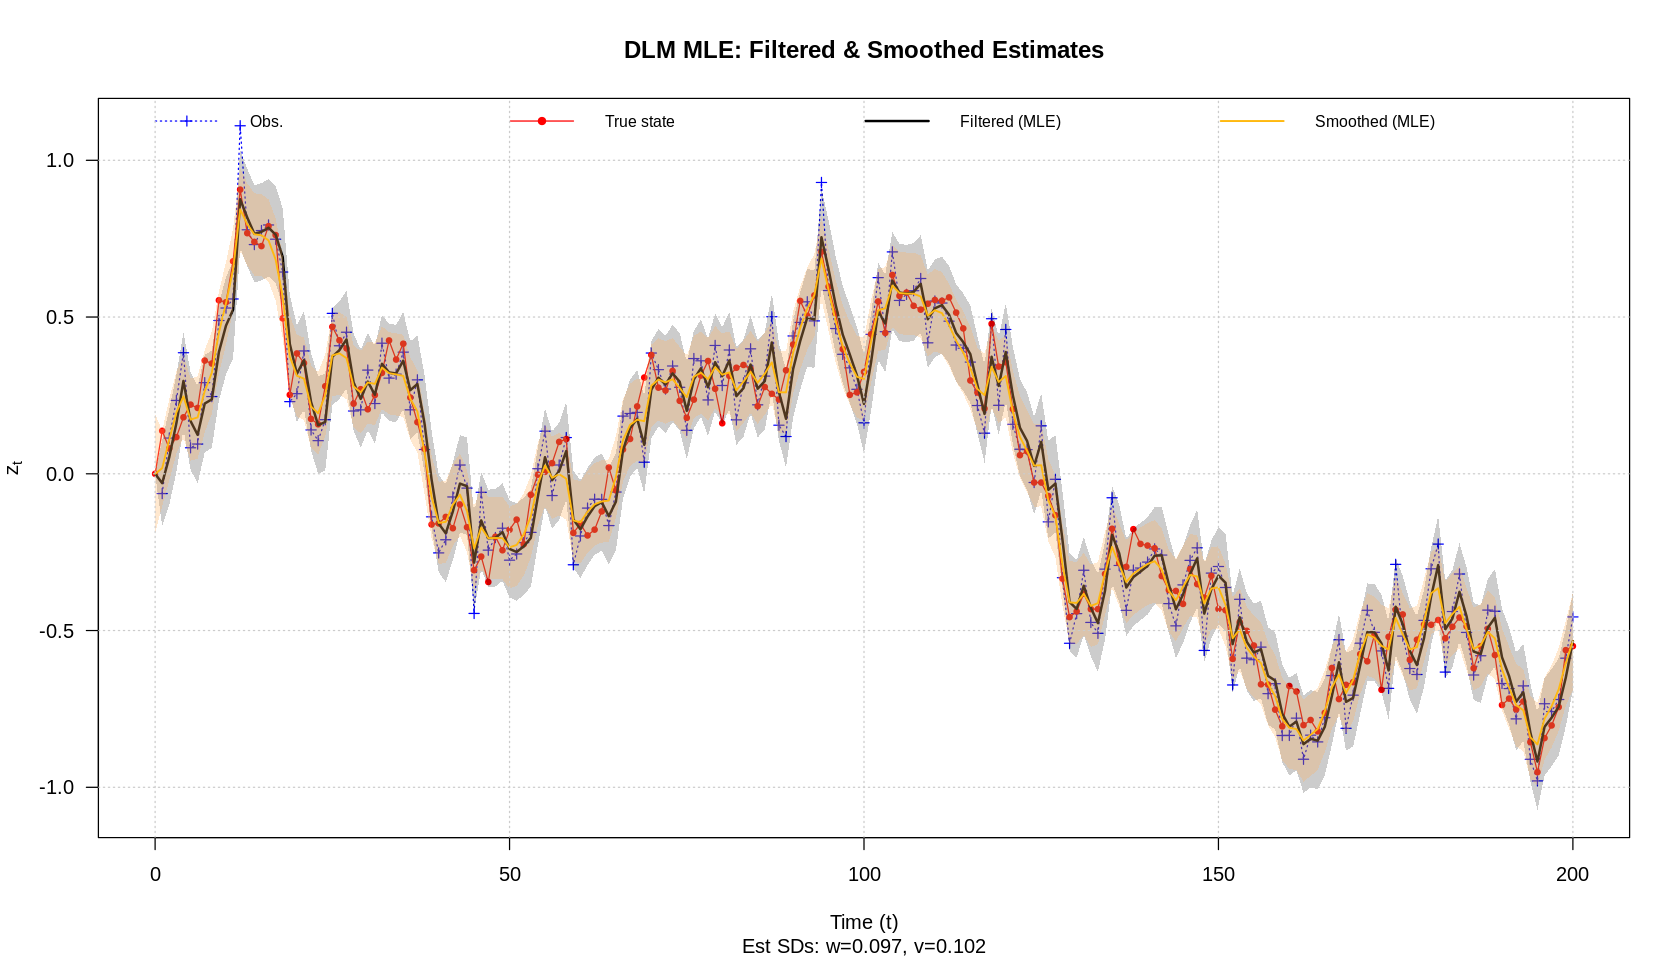

In [33]:
# Plot observations, true state, MLE‑filtered and MLE‑smoothed estimates
plot(
    obs_time_idx,
    obs_y,
    type = "o",         # obs points + lines
    pch = 3,            # open cross
    cex = 0.8,
    col = "blue",
    lty = 3,            # dashed
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(
        c(obs_y, states_z,
          mle_z_lower, mle_z_upper,
          mle_zs_lower, mle_zs_upper)
    ),
    las = 1,
    main = "DLM MLE: Filtered & Smoothed Estimates",
    sub = paste0("Est SDs: w=", round(est_sdp, 3),
                 ", v=", round(est_sdo, 3))
)

# True latent state
points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Filtered 95% CI
polygon(
    x = c(time_idx, rev(time_idx)),
    y = c(mle_z_lower, rev(mle_z_upper)),
    col = rgb(0, 0, 0, 0.2),
    border = NA
)

# Filtered state estimates
lines(
    time_idx,
    mle_filtered_states,
    lwd = 2,
    col = "black"
)

# Smoothed 95% CI
polygon(
    x = c(time_idx, rev(time_idx)),
    y = c(mle_zs_lower, rev(mle_zs_upper)),
    col = rgb(1, 0.7, 0.4, 0.3),
    border = NA
)

# Smoothed state estimates
lines(
    time_idx,
    mle_smoothed_states,
    lwd = 1.5,
    col = "darkgoldenrod1"
)

# Legend at top
legend(
    "top",
    legend = c("Obs.", "True state", "Filtered (MLE)", "Smoothed (MLE)"),
    pch = c(3, 19, NA, NA),
    lty = c(3, 1,  1, 1),
    lwd = c(1, 1,  2, 1.5),
    col = c("blue", "red", "black", "darkgoldenrod1"),
    horiz = TRUE,
    bty = "n",
    cex = 0.79
)

# Add a grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [34]:
# 4‑parameter (flexible) DLM: build and MLE estimation

# Function to build a 4‑parameter DLM from θ = c(beta, log(W), alpha, log(V))
dlm_build_4p <- function(theta) {
    dlm(
        m0 = initial_state,
        C0 = initial_var,
        GG = theta[1],       # β
        W = exp(theta[2]),   # process variance
        FF = theta[3],       # α
        V = exp(theta[4])    # observation variance
    )
}

In [35]:
# MLE fit (start at true sim values)
mle4_fit <- dlmMLE(
    y = obs_y,
    parm = c(GG_coeff, log(W_var), FF_coeff, log(V_var)),
    build = dlm_build_4p
)

# Check convergence (0 = success)
mle4_fit$convergence

[1] 0

In [36]:
# AIC comparison
aic2 <- 2*mle_fit$value + 2*2   # simpler 2‑param model
aic4 <- 2*mle4_fit$value + 2*4  # flexible 4‑param model
c(Original = aic2, Flexible = aic4, Difference = aic4 - aic2)

Original    Flexible  Difference 
-525.165565 -522.972953    2.192612

In [37]:
# Detach igraph if loaded
if ("package:igraph" %in% search()) {
  tryCatch(
    detach("package:igraph", unload = TRUE),
    error = function(e) invisible(NULL)
  )
}

In [38]:
# Extract true vs. estimated parameters
dlm_mle4_model <- dlm_build_4p(mle4_fit$par)
param_true <- c(
    beta = GG_coeff,
    alpha = FF_coeff,
    "sd Proc." = process_var_stdev,
    "sd Obs." = obs_error_stdev
)

param_est <- c(
    GG(dlm_mle4_model),
    FF(dlm_mle4_model),
    sqrt(W(dlm_mle4_model)),
    sqrt(V(dlm_mle4_model))
)
round(cbind(True = param_true, Est = param_est), 3)

True Est  
beta     1.0  0.978
alpha    1.0  0.999
sd Proc. 0.1  0.100
sd Obs.  0.1  0.100

In [39]:
# Filter and smooth the flexible model
mle4_filtered <- dlmFilter(y = obs_y, mod = dlm_mle4_model)
mle4_smoothed <- dlmSmooth(y = obs_y, mod = dlm_mle4_model)

# Extract states and variances
mle4_f_states <- mle4_filtered$m
mle4_s_states <- mle4_smoothed$s
mle4_f_vars <- unlist(dlmSvd2var(mle4_filtered$U.C, mle4_filtered$D.C))
mle4_s_vars <- unlist(dlmSvd2var(mle4_smoothed$U.S, mle4_smoothed$D.S))

# 95% CIs for filtered and smoothed
mle4_f_lower <- mle4_f_states + qnorm(alpha / 2) * sqrt(mle4_f_vars)
mle4_f_upper <- mle4_f_states + qnorm(1 - alpha / 2) * sqrt(mle4_f_vars)
mle4_s_lower <- mle4_s_states + qnorm(alpha / 2) * sqrt(mle4_s_vars)
mle4_s_upper <- mle4_s_states + qnorm(1 - alpha / 2) * sqrt(mle4_s_vars)

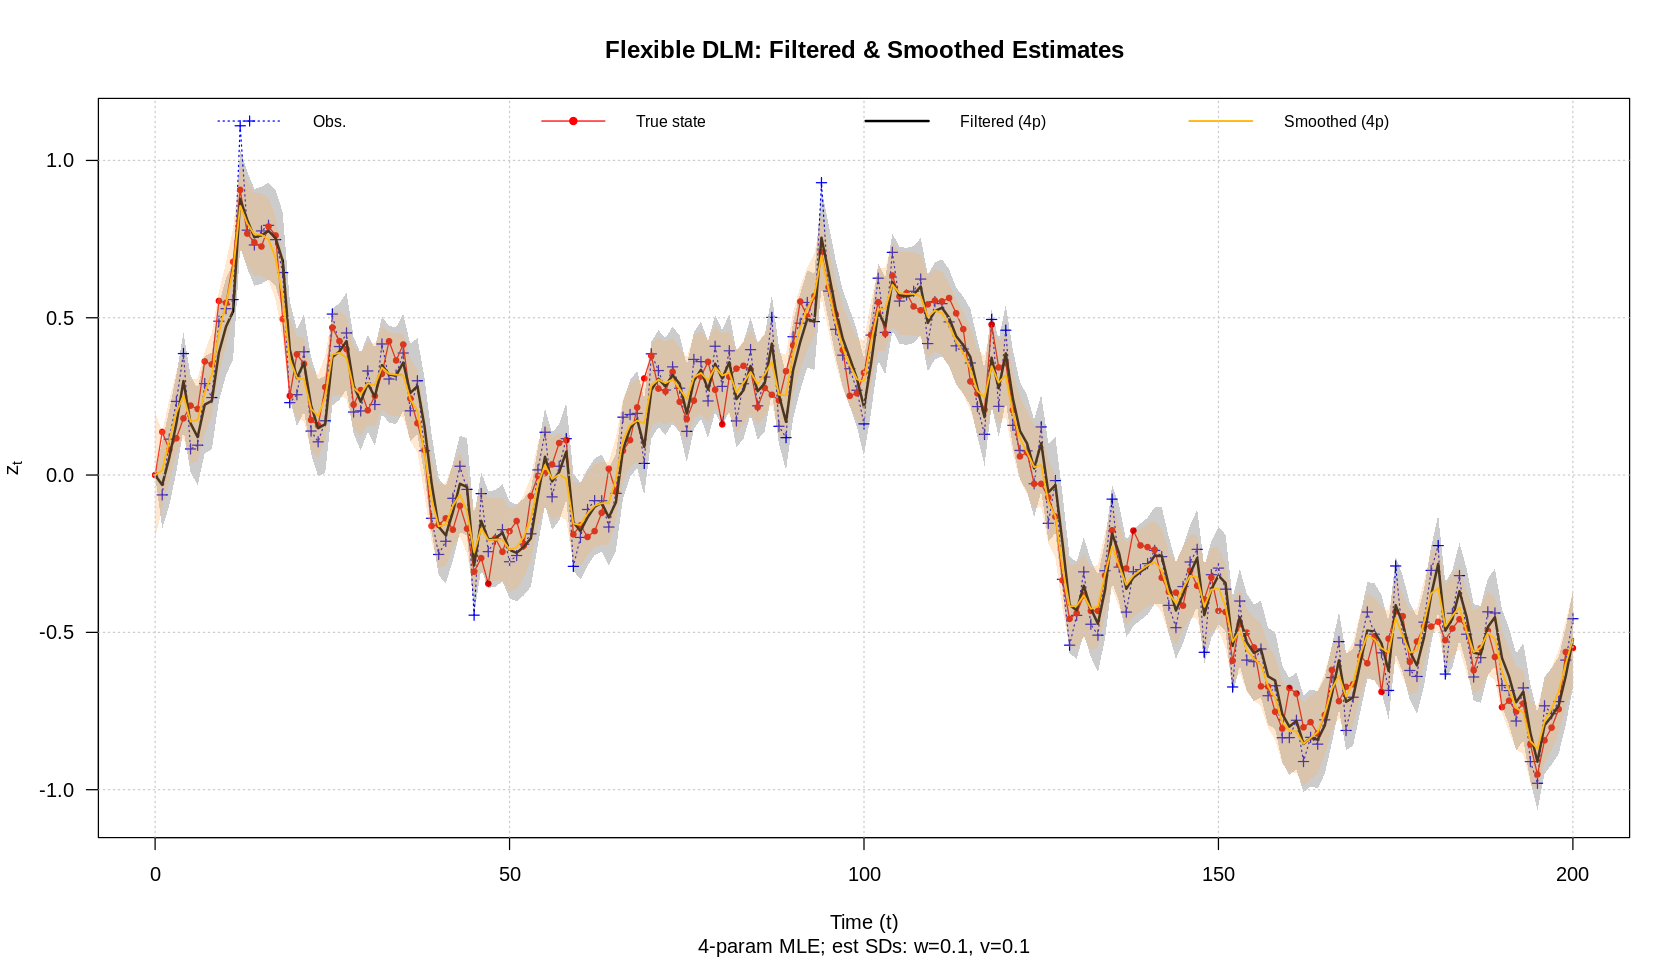

In [40]:
# Plot flexible‑model estimates
plot(
    obs_time_idx,
    obs_y,
    type = "o",
    pch = 3,
    cex = 0.8,
    col = "blue",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(
        c(obs_y, states_z,
          mle4_f_lower, mle4_f_upper,
          mle4_s_lower, mle4_s_upper)
    ),
    las = 1,
    main = "Flexible DLM: Filtered & Smoothed Estimates",
    sub = paste0("4‑param MLE; est SDs: w=", round(sqrt(exp(mle4_fit$par[2])), 3),
                 ", v=", round(sqrt(exp(mle4_fit$par[4])), 3))
)

# True state
points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Filtered CI
polygon(
    x = c(time_idx, rev(time_idx)),
    y = c(mle4_f_lower, rev(mle4_f_upper)),
    col = rgb(0, 0, 0, 0.2),
    border = NA
)

# Filtered states
lines(
    time_idx,
    mle4_f_states,
    lwd = 2,
    col = "black"
)

# Smoothed CI
polygon(
    x = c(time_idx, rev(time_idx)),
    y = c(mle4_s_lower, rev(mle4_s_upper)),
    col = rgb(1, 0.7, 0.4, 0.3),
    border = NA
)

# Smoothed states
lines(
    time_idx,
    mle4_s_states,
    lwd = 1.5,
    col = "darkgoldenrod1"
)

# Legend at top
legend(
    "top",
    legend = c("Obs.", "True state", "Filtered (4p)", "Smoothed (4p)"),
    pch = c(3, 19, NA, NA),
    lty = c(3, 1, 1, 1),
    lwd = c(1, 1, 2, 1.5),
    col = c("blue", "red", "black", "darkgoldenrod1"),
    horiz = TRUE,
    bty = "n",
    cex = 0.79
)

# Add grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [41]:
# RMSPE and z vs. ŷ scatter

# Root mean square prediction error
rmspe <- function(zhat) {
    sqrt(sum((states_z[-1] - zhat[-1])^2))
}

In [42]:
# Scatter and identity line
plot_vs <- function(zhat, label, col) {
    plot(
        states_z[-1], zhat[-1],
        xlab = expression(z[t]),
        ylab = expression(hat(z)[t]),
        las = 1,
        pch = 19,
        col = col,
        cex = 0.5
    )
    abline(0, 1)
    mtext(
        paste0(label, ", RMSPE=", round(rmspe(zhat), 2)),
        line = -1, cex = 0.7
    )
}

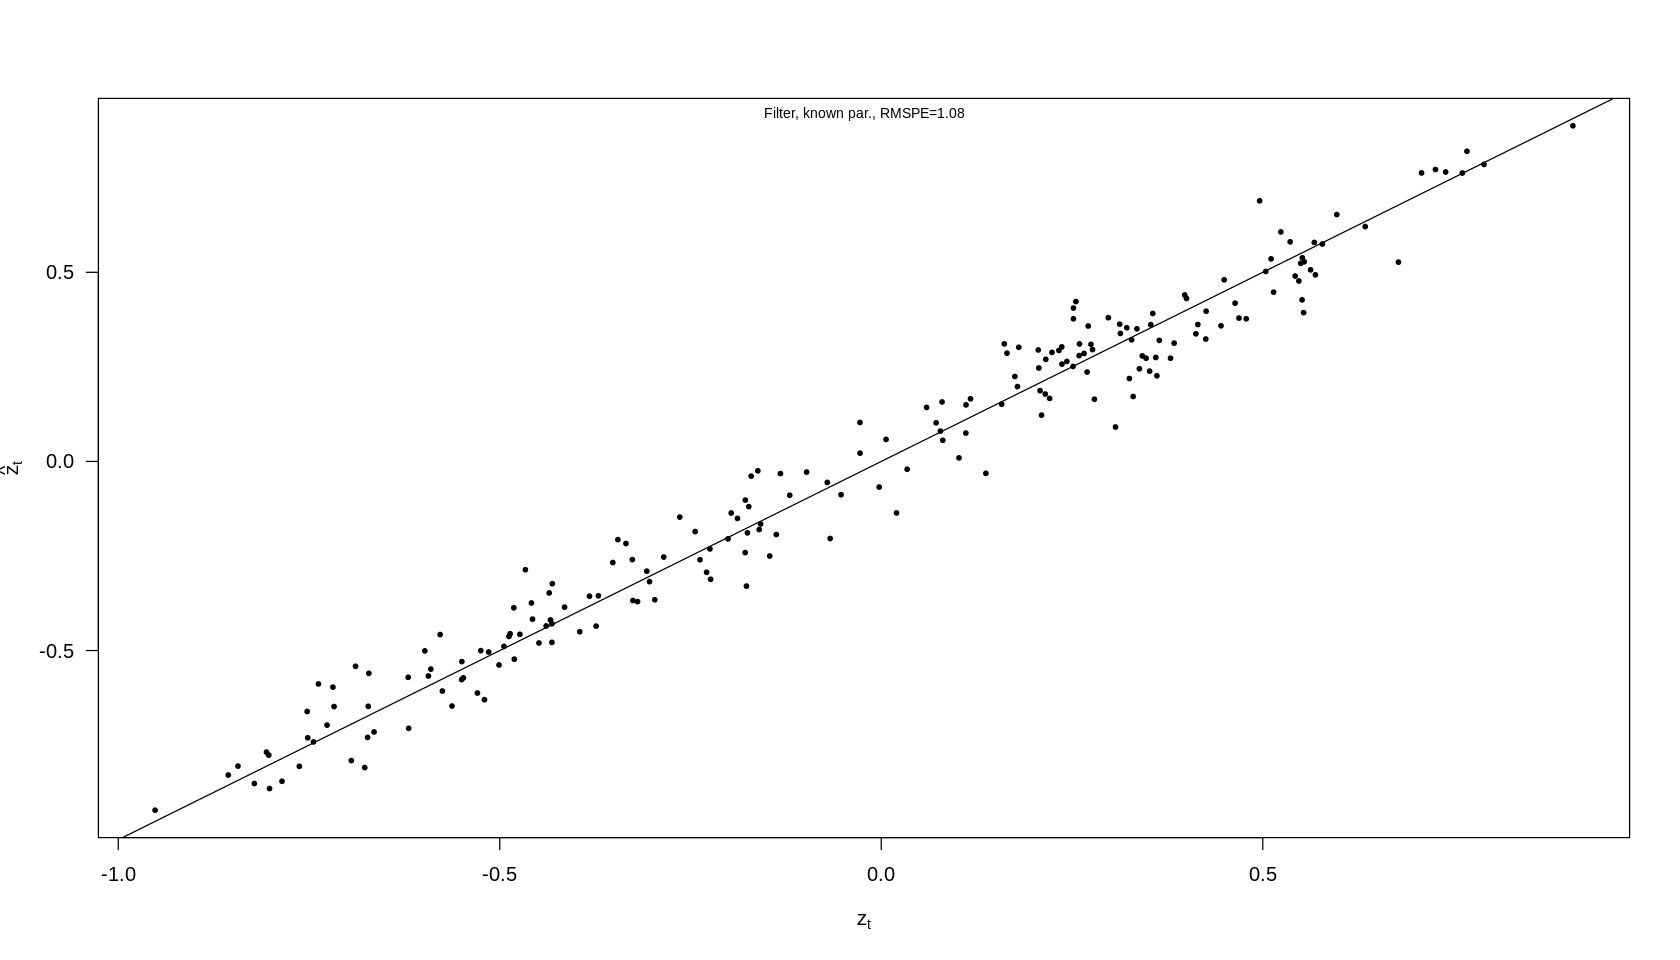

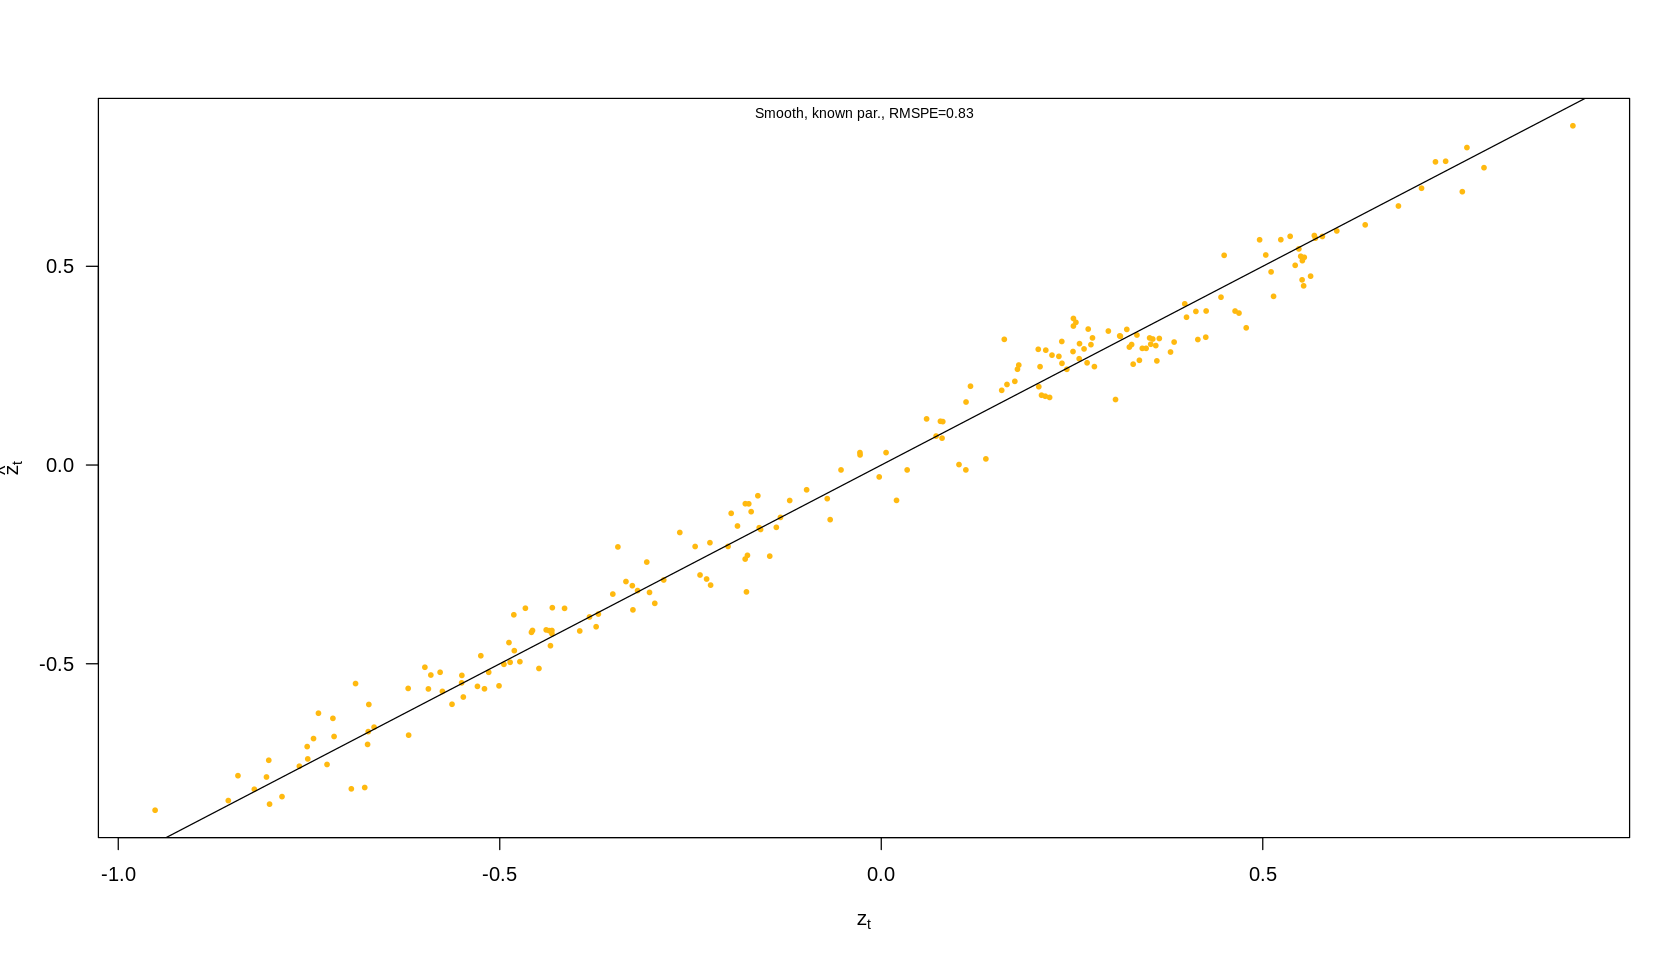

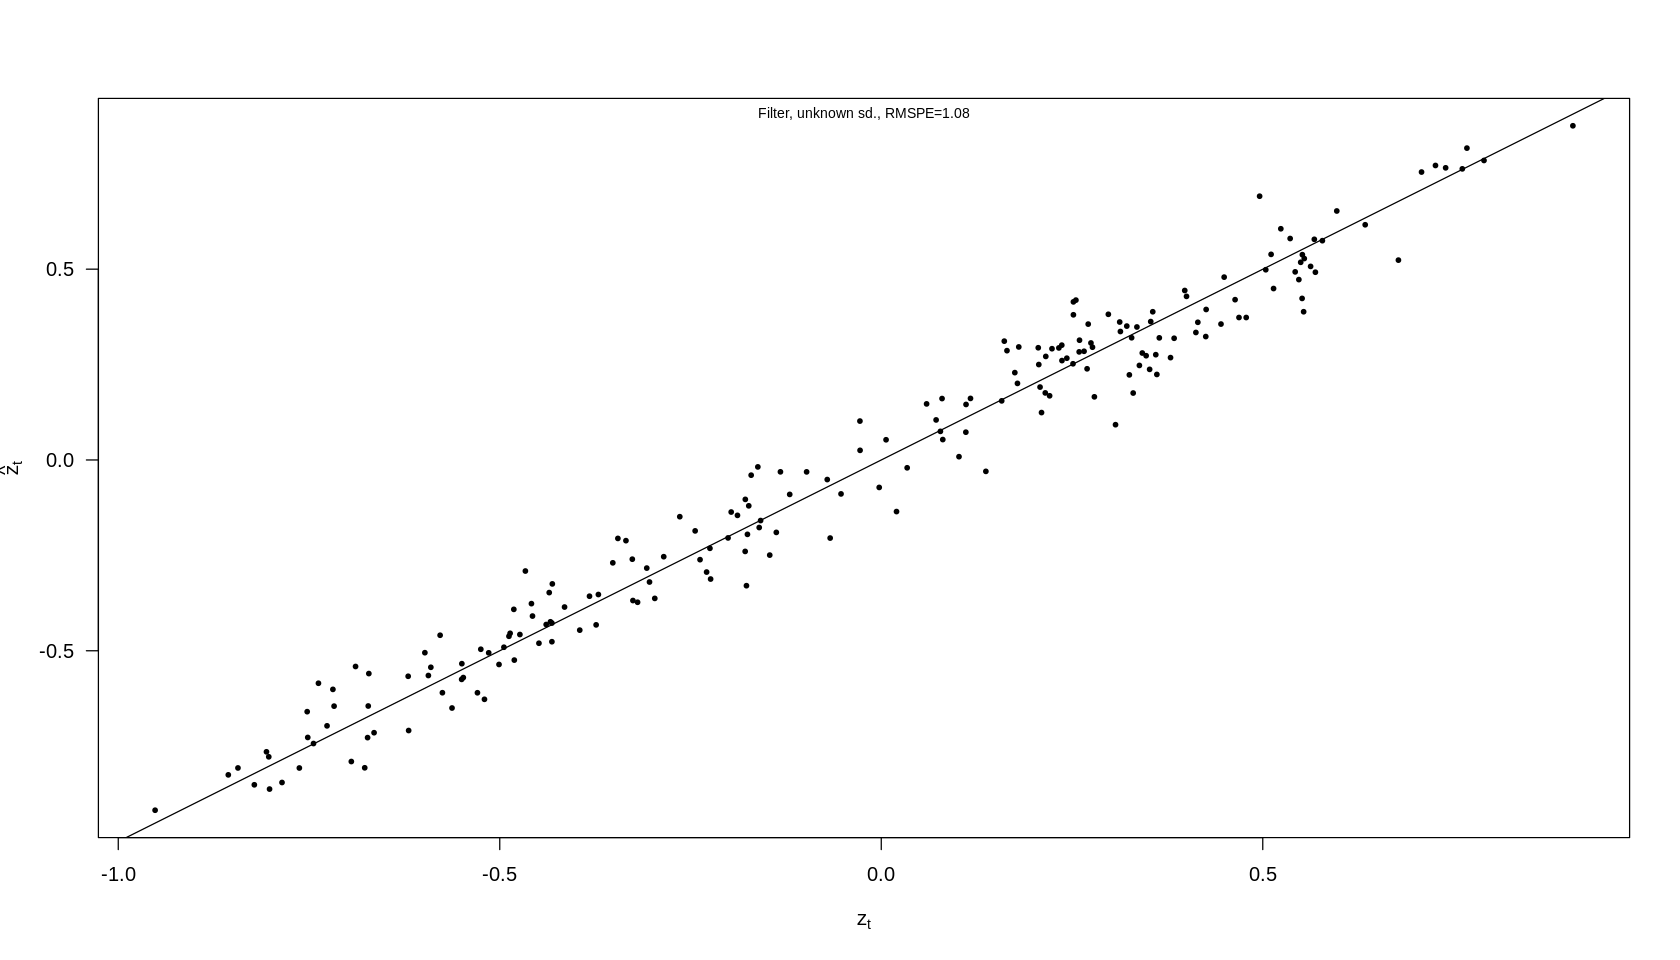

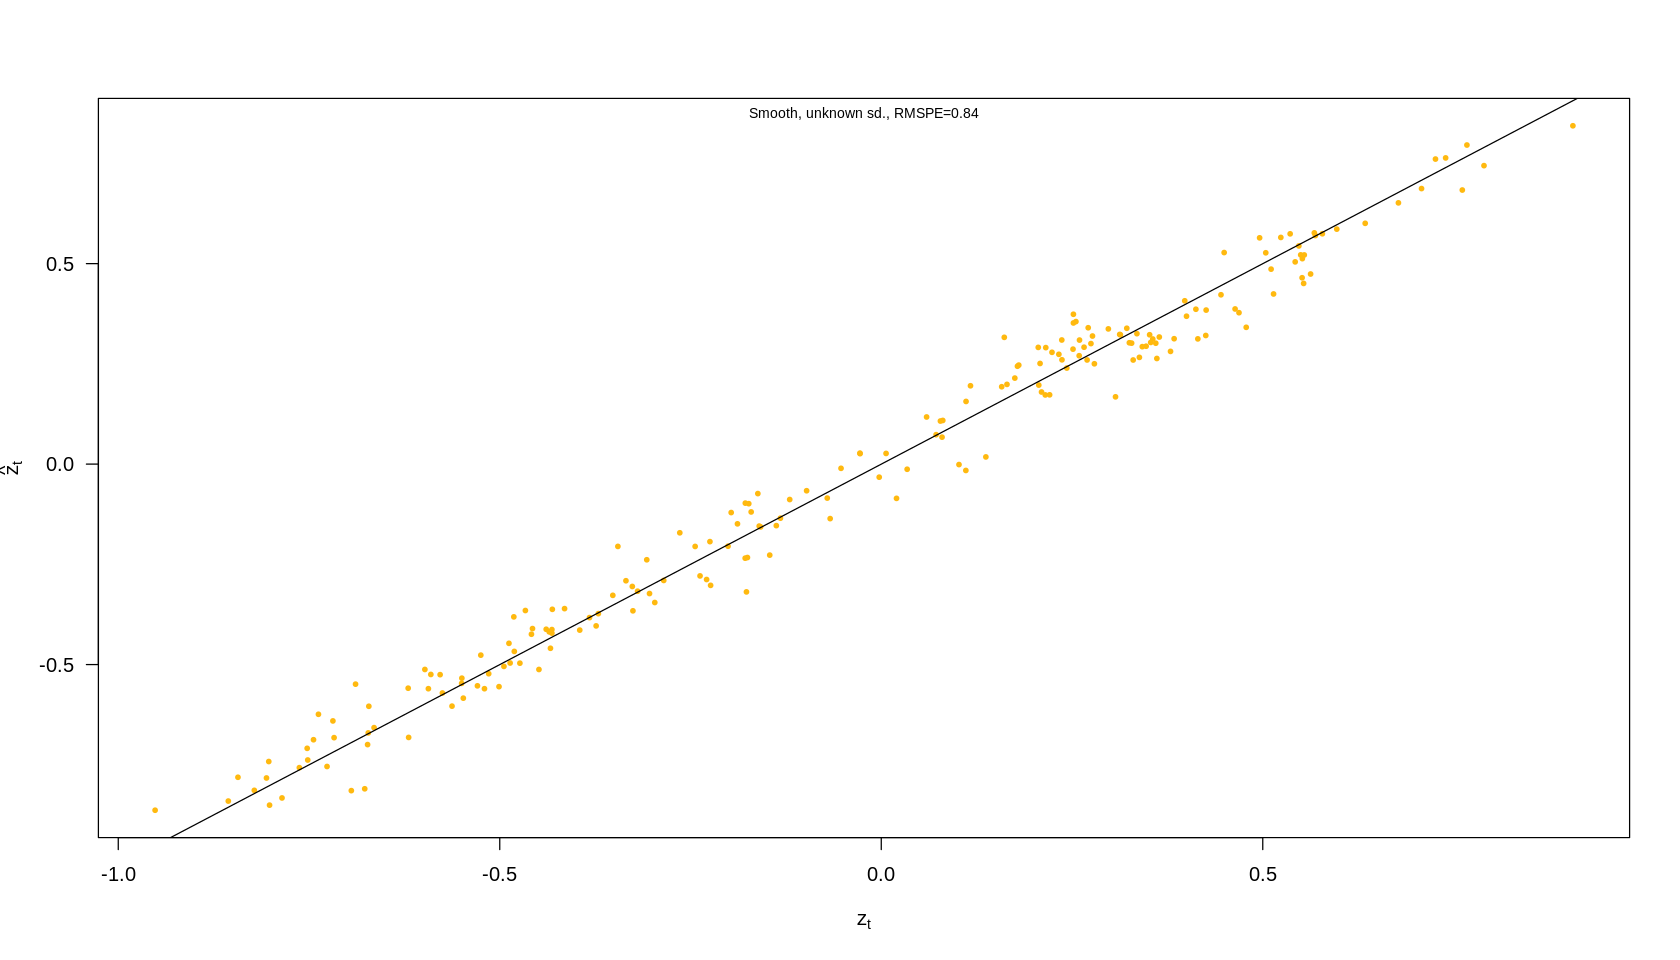

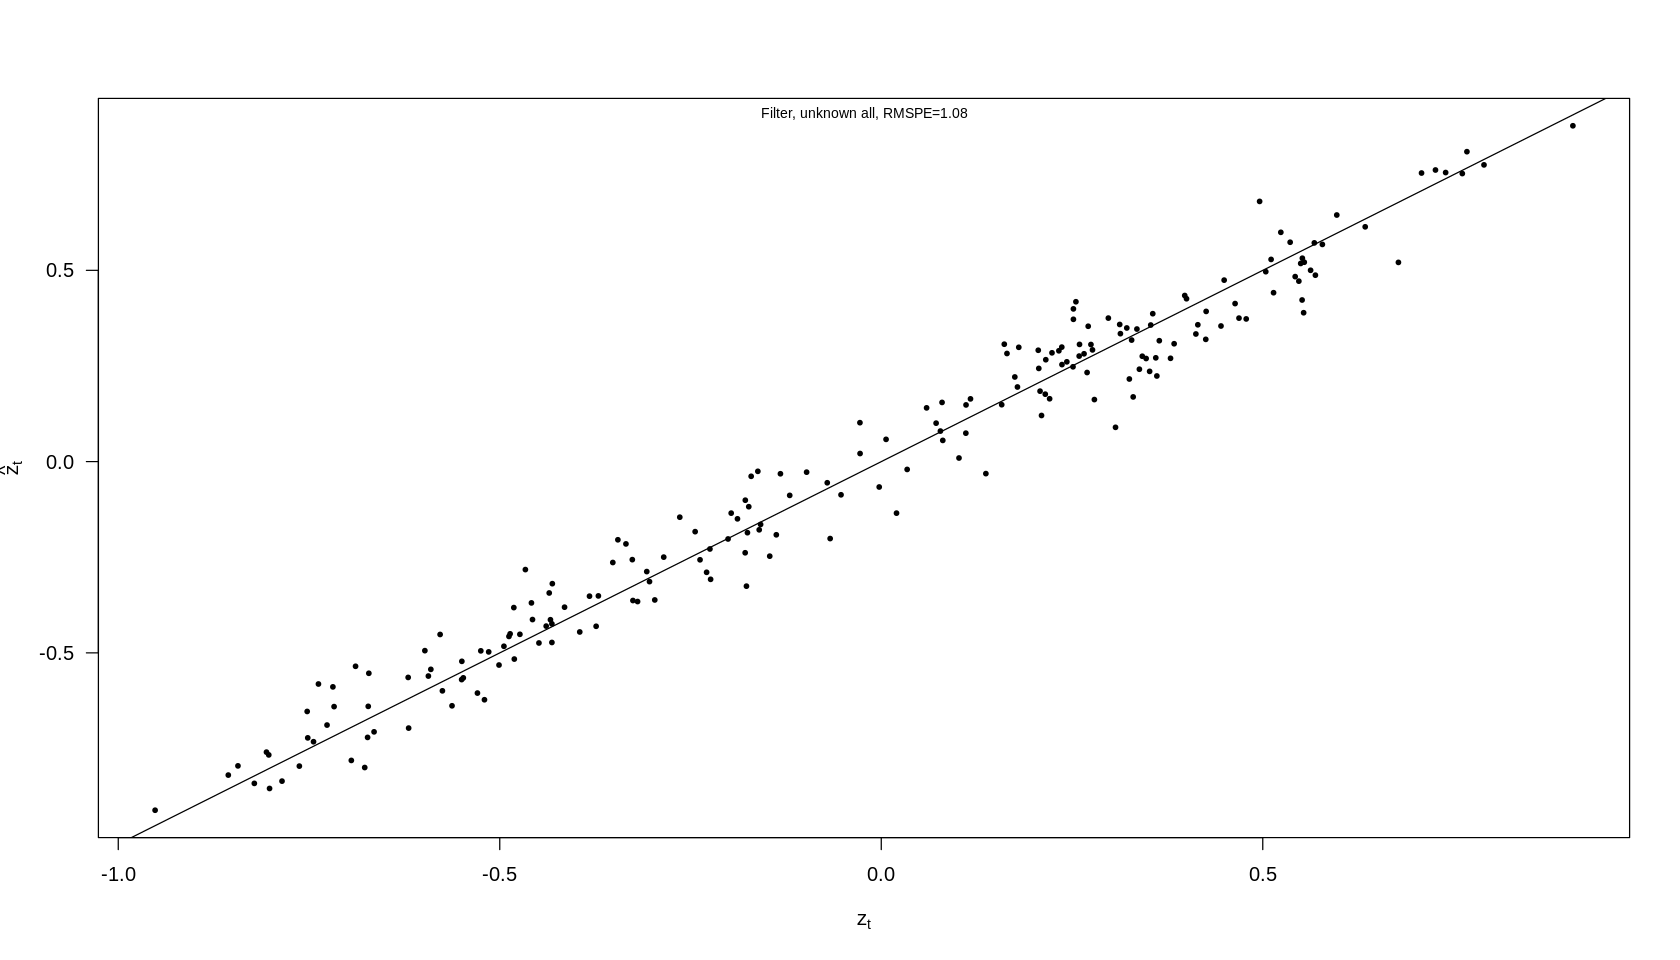

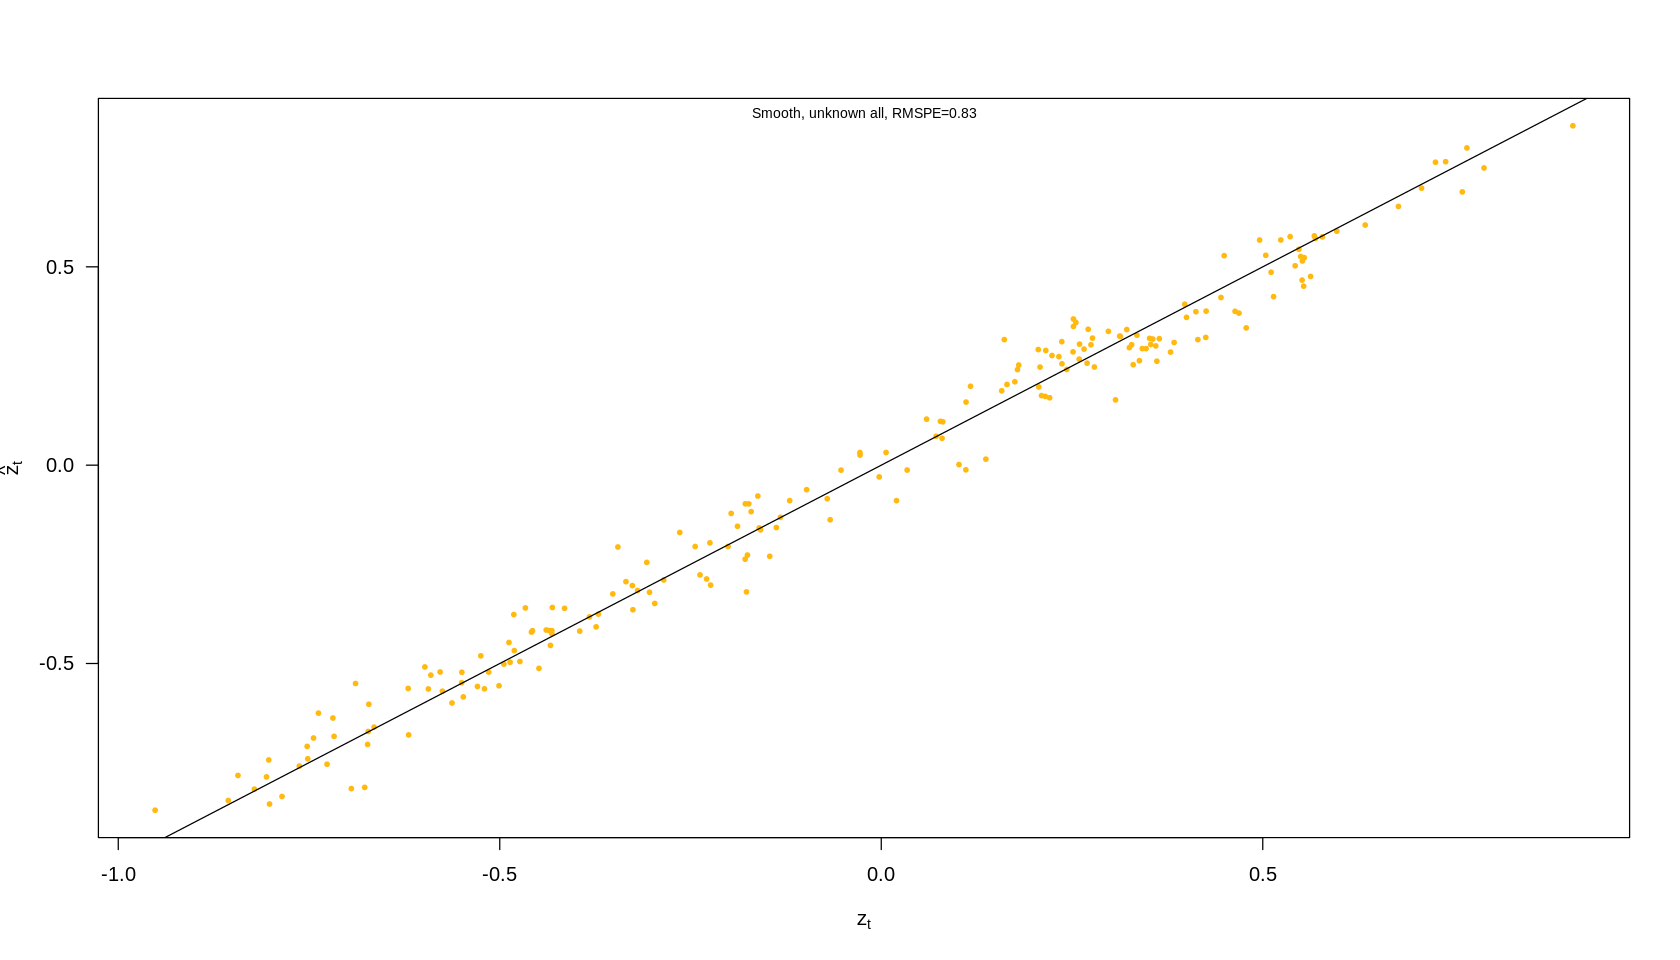

In [43]:
# Compare scenarios
plot_vs(filtered_states, "Filter, known par.", "black")
plot_vs(smoothed_states, "Smooth, known par.", "darkgoldenrod1")
plot_vs(mle_filtered_states, "Filter, unknown sd.", "black")
plot_vs(mle_smoothed_states, "Smooth, unknown sd.", "darkgoldenrod1")
plot_vs(mle4_f_states, "Filter, unknown all", "black")
plot_vs(mle4_s_states, "Smooth, unknown all", "darkgoldenrod1")

In [44]:
# Residual diagnostics

# Conventional residuals from simple‐model smoothing
simple_smoothed_vars <- unlist(dlmSvd2var(dlm_smoothed$U.S, dlm_smoothed$D.S))
res_conv <- obs_y - smoothed_states[-1]

# Standardize: √(Sₜ + V)
res_std_conv <- res_conv / sqrt(simple_smoothed_vars[-1] + V_var)

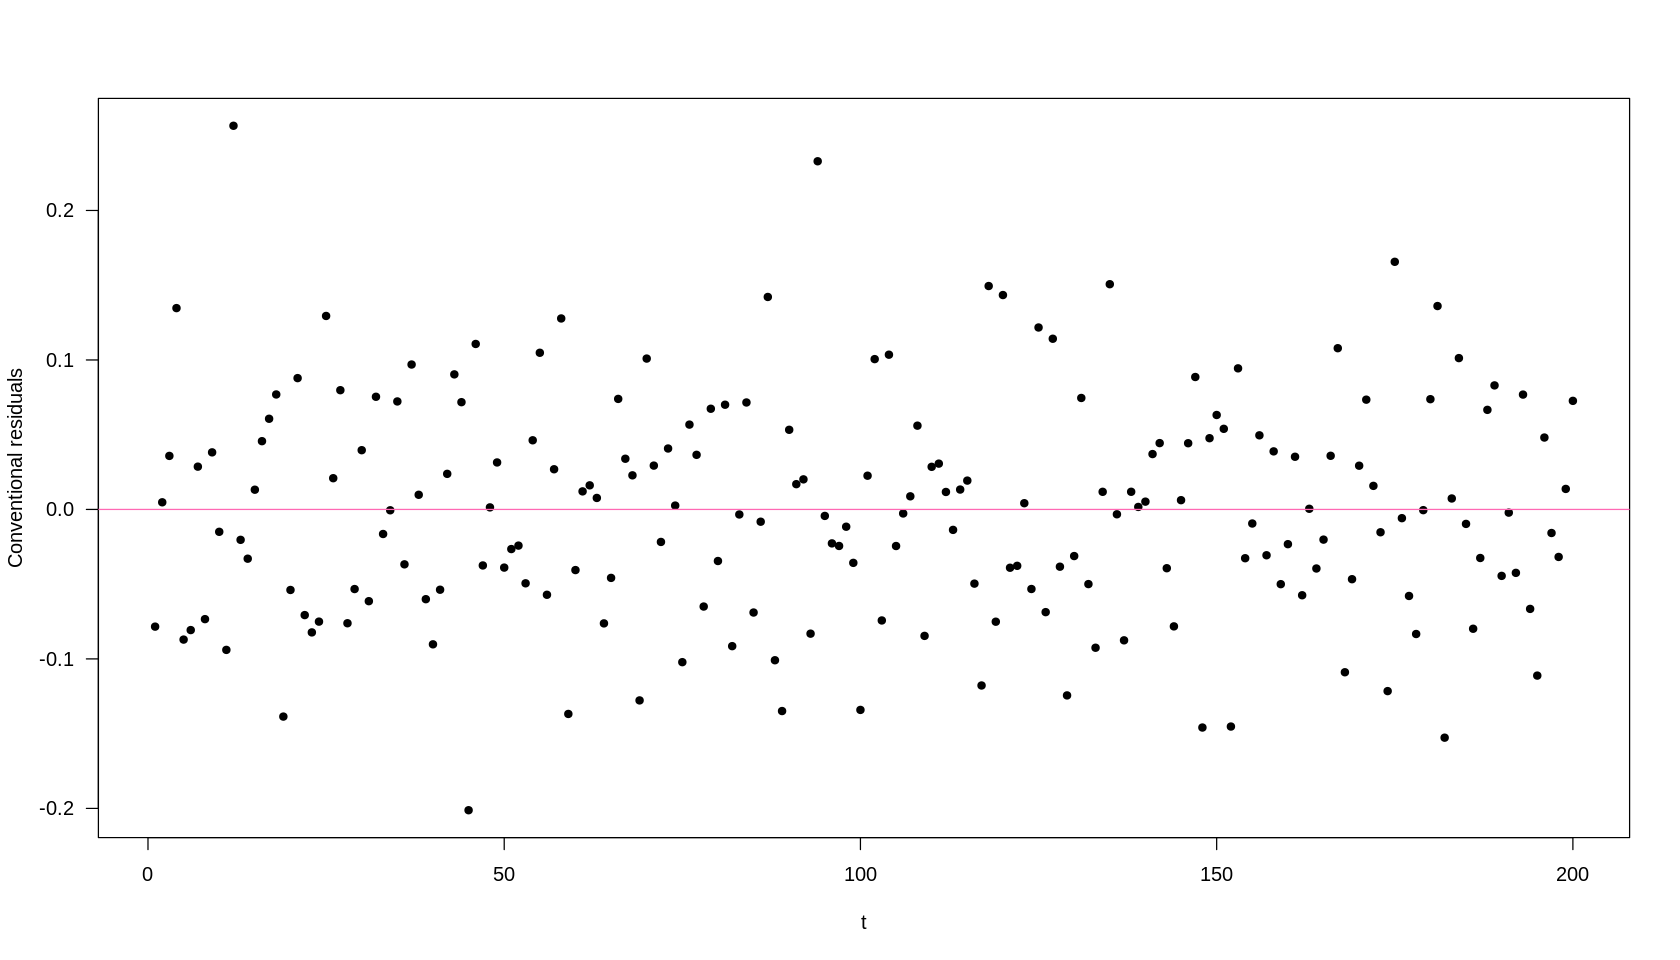

In [45]:
# Plot conventional residuals
plot(
    res_conv,
    ylab = "Conventional residuals",
    xlab = "t",
    pch = 19,
    cex = 0.8,
    las = 1
)
abline(h = 0, col = "hotpink")

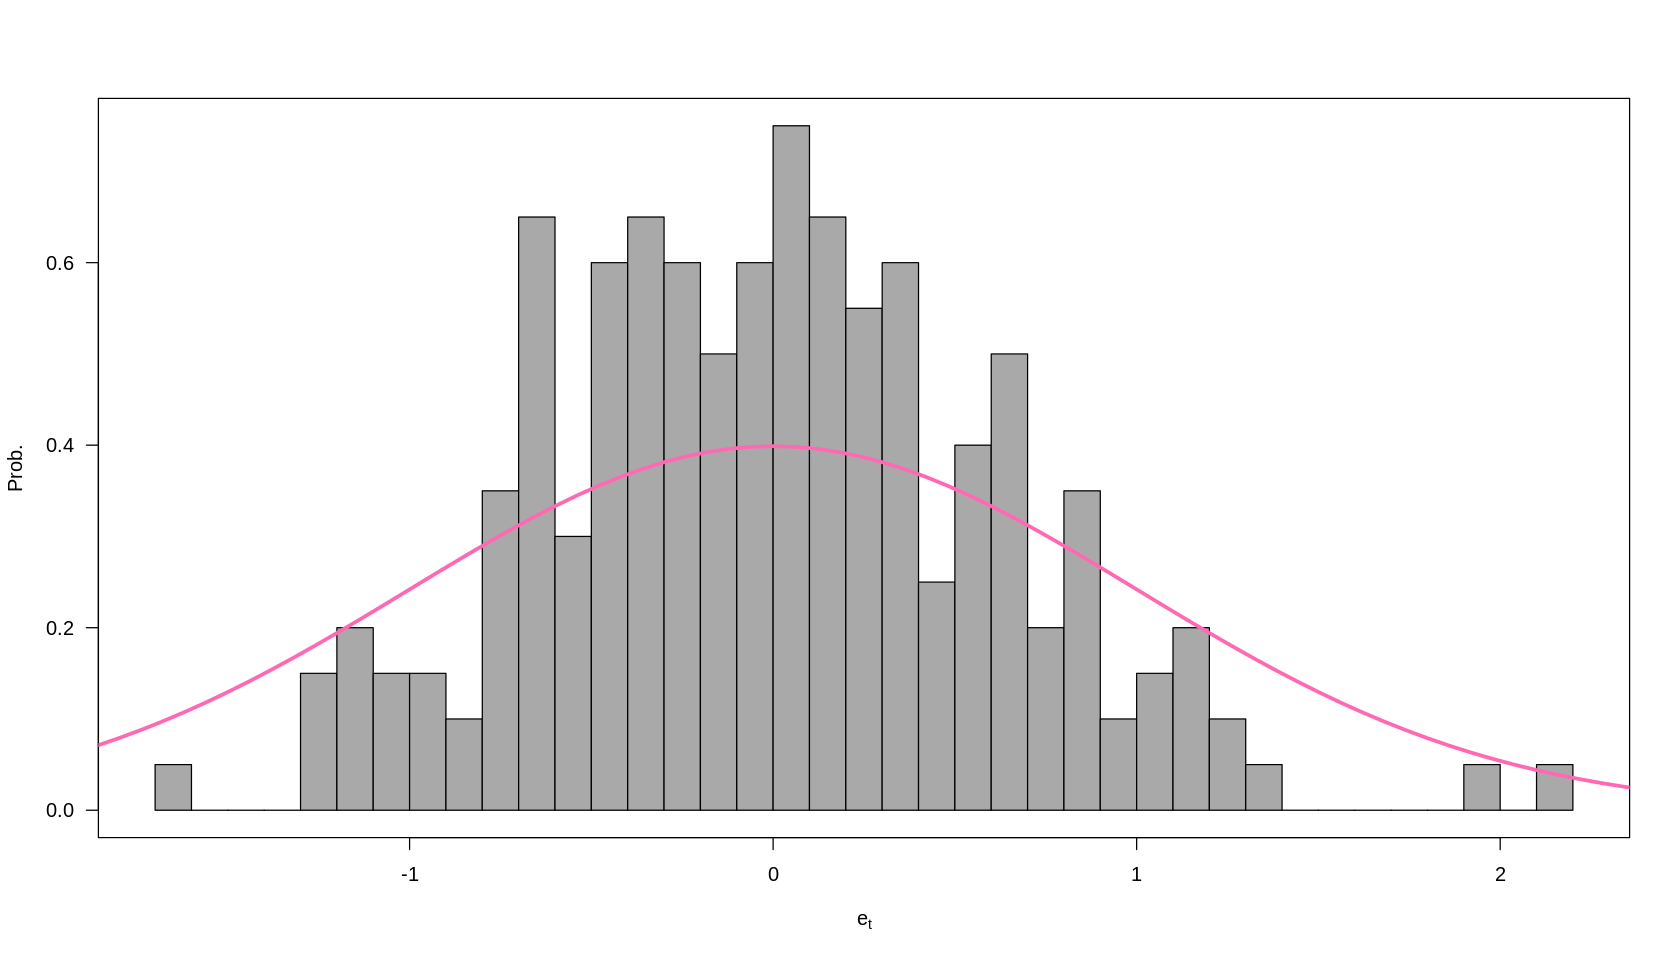

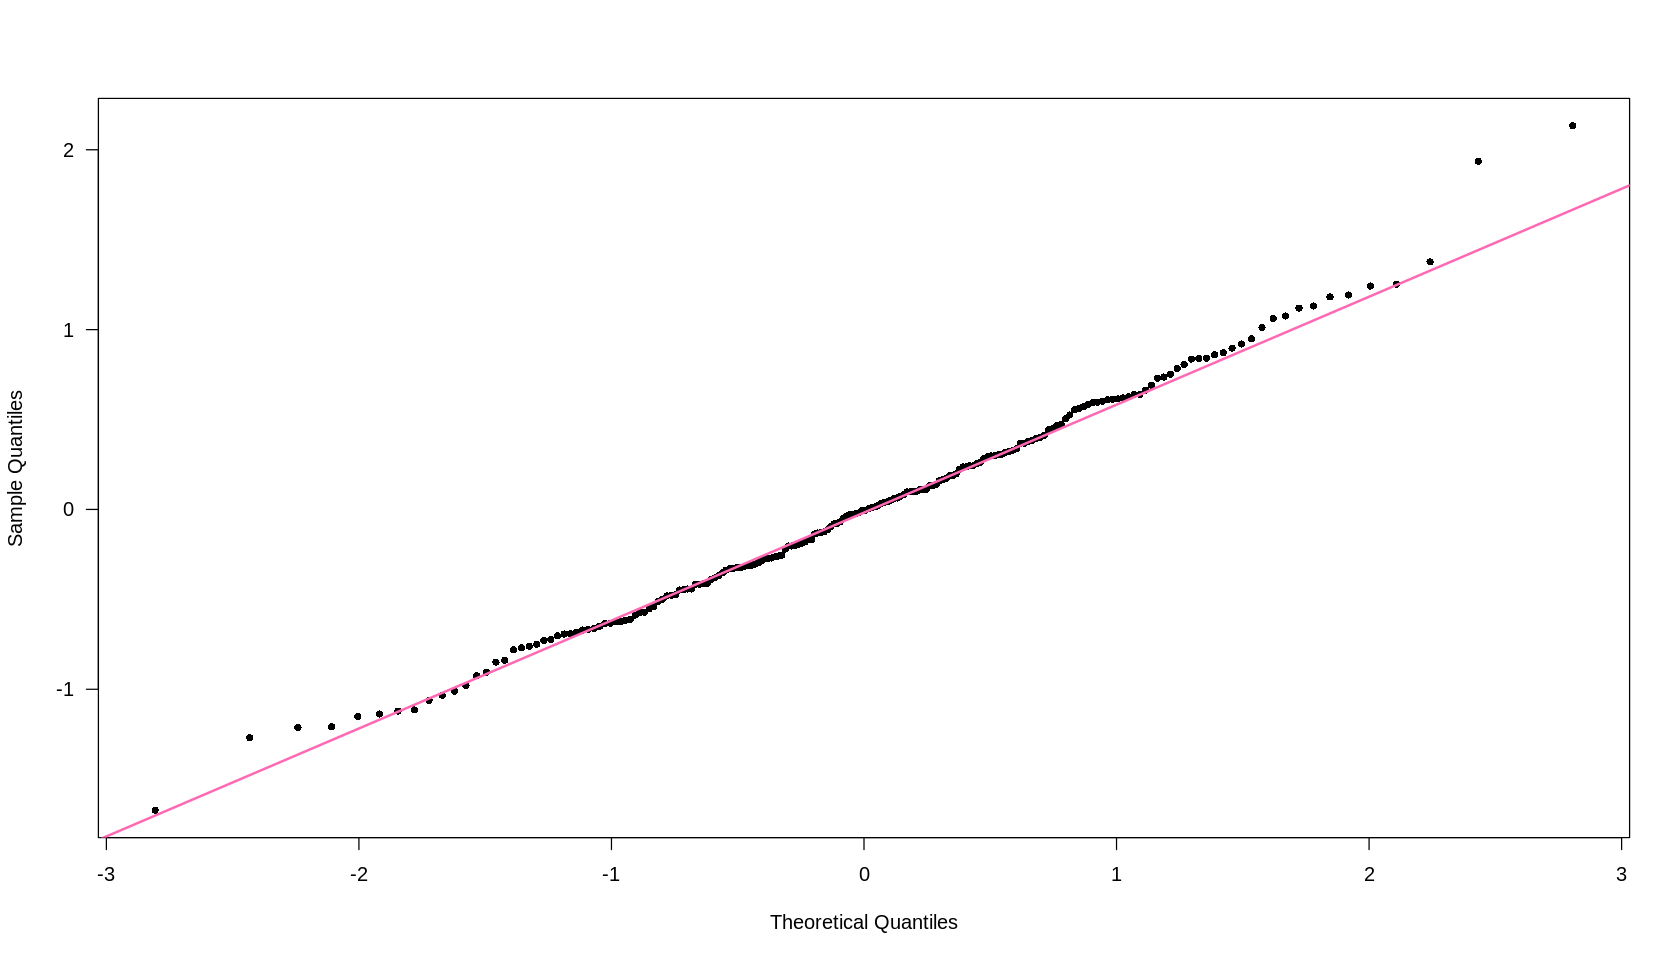

In [46]:
# Hist + QQ of standardized conventional residuals
hist(
    res_std_conv,
    breaks = 50,
    freq = FALSE,
    main = "",
    ylab = "Prob.",
    xlab = expression(e[t]),
    las = 1,
    col = "darkgrey"
)
box()
curve(dnorm, -3, 3, add = TRUE, col = "hotpink", lwd = 3)
qqnorm(
    y = res_std_conv,
    main = "",
    pch = 16,
    cex = 0.8,
    las = 1
)
qqline(y = res_std_conv, col = "hotpink", lwd = 2)

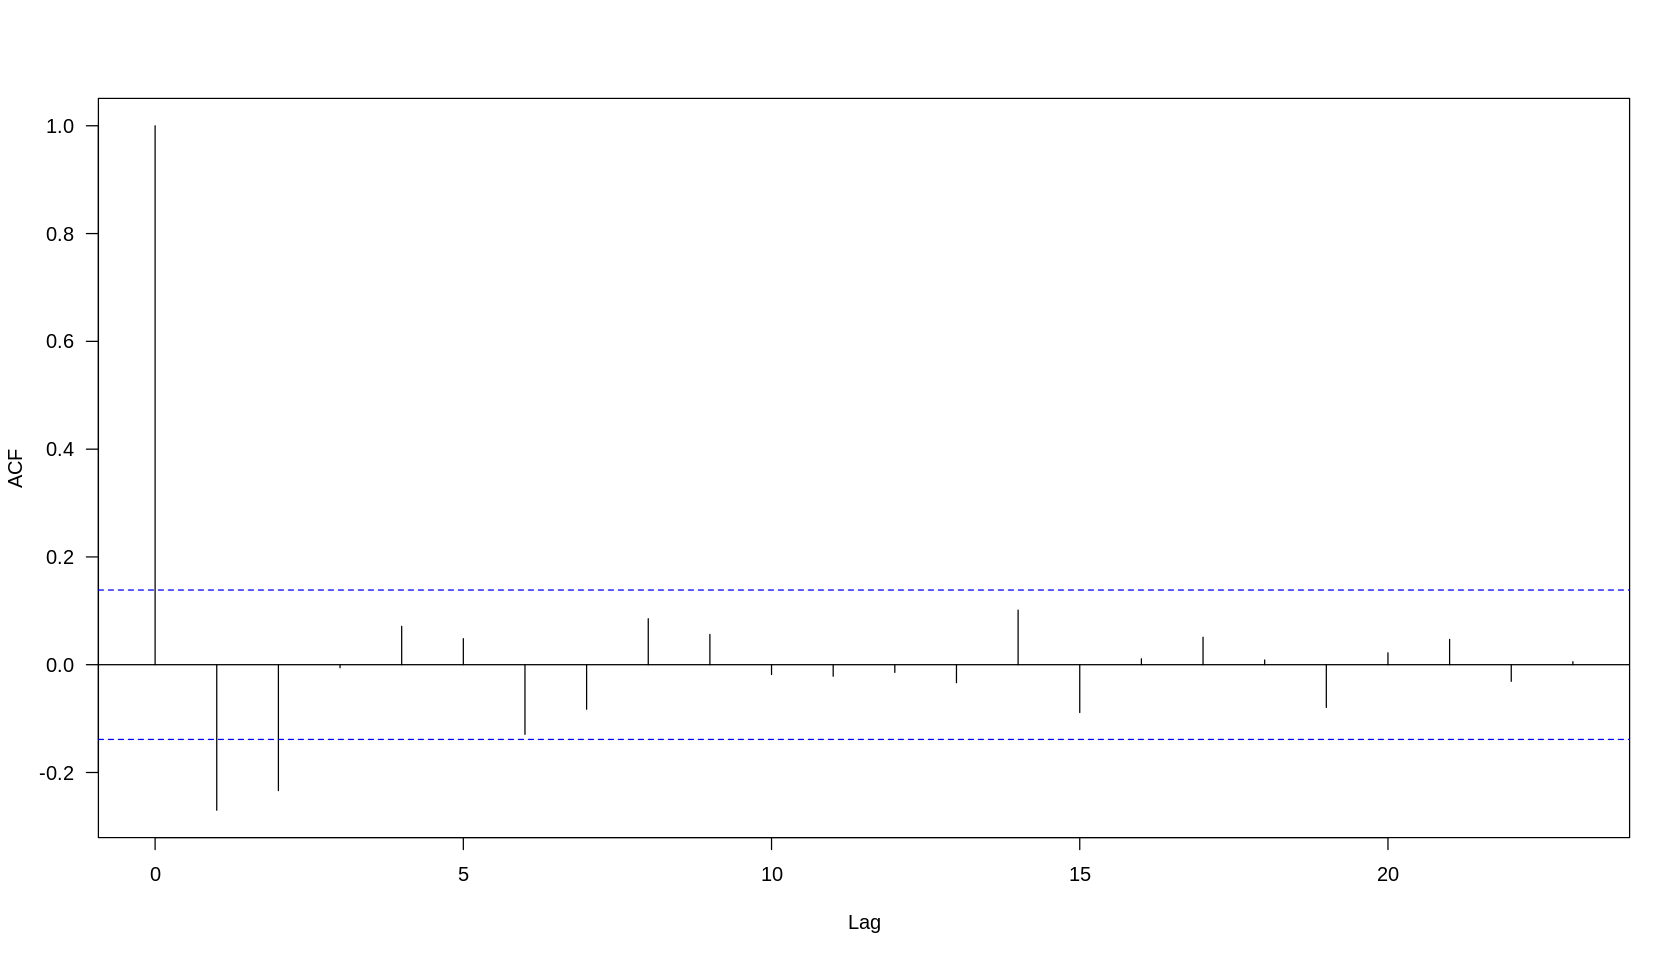

In [47]:
# ACF of conventional residuals
acf(res_std_conv, las = 1, main = "")

In [48]:
# One‑step‑ahead (raw and standardized) residuals from simple‐model filtering
res_osa_raw <- residuals(dlm_filtered, type = "raw")$res
res_osa_std <- residuals(dlm_filtered, type = "standardized")$res

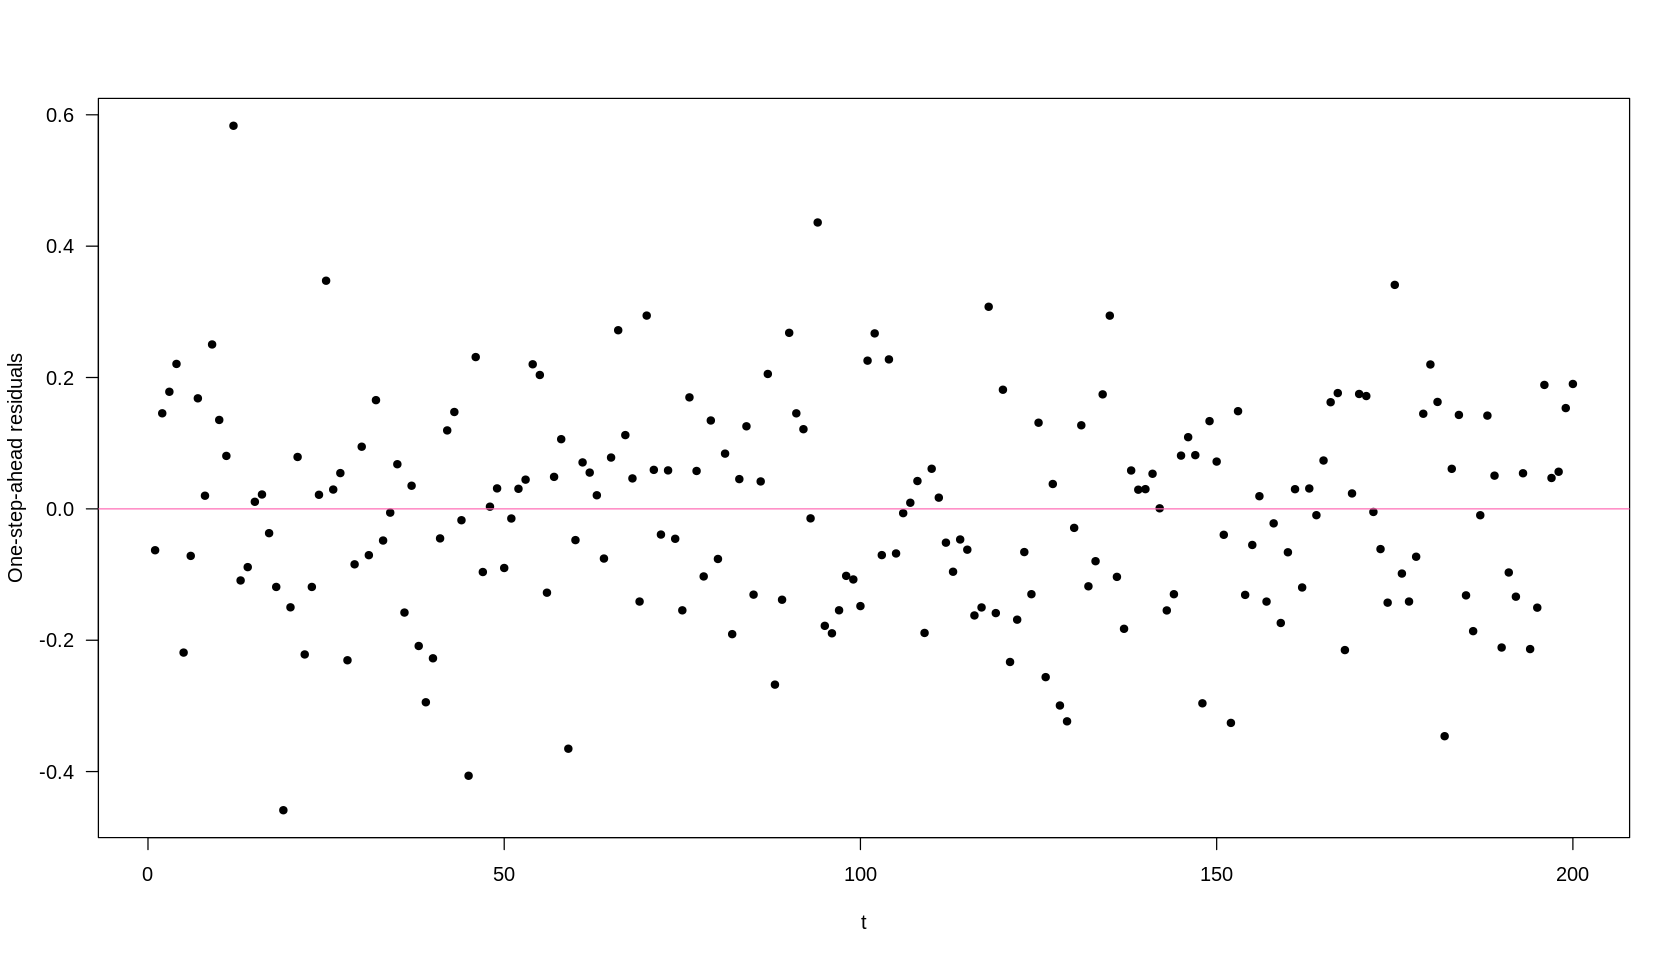

In [49]:
# Plot raw OSA residuals
plot(
    res_osa_raw,
    ylab = "One‑step‑ahead residuals",
    xlab = "t",
    pch = 19,
    cex = 0.8,
    las = 1
)
abline(h = 0, col = "hotpink")

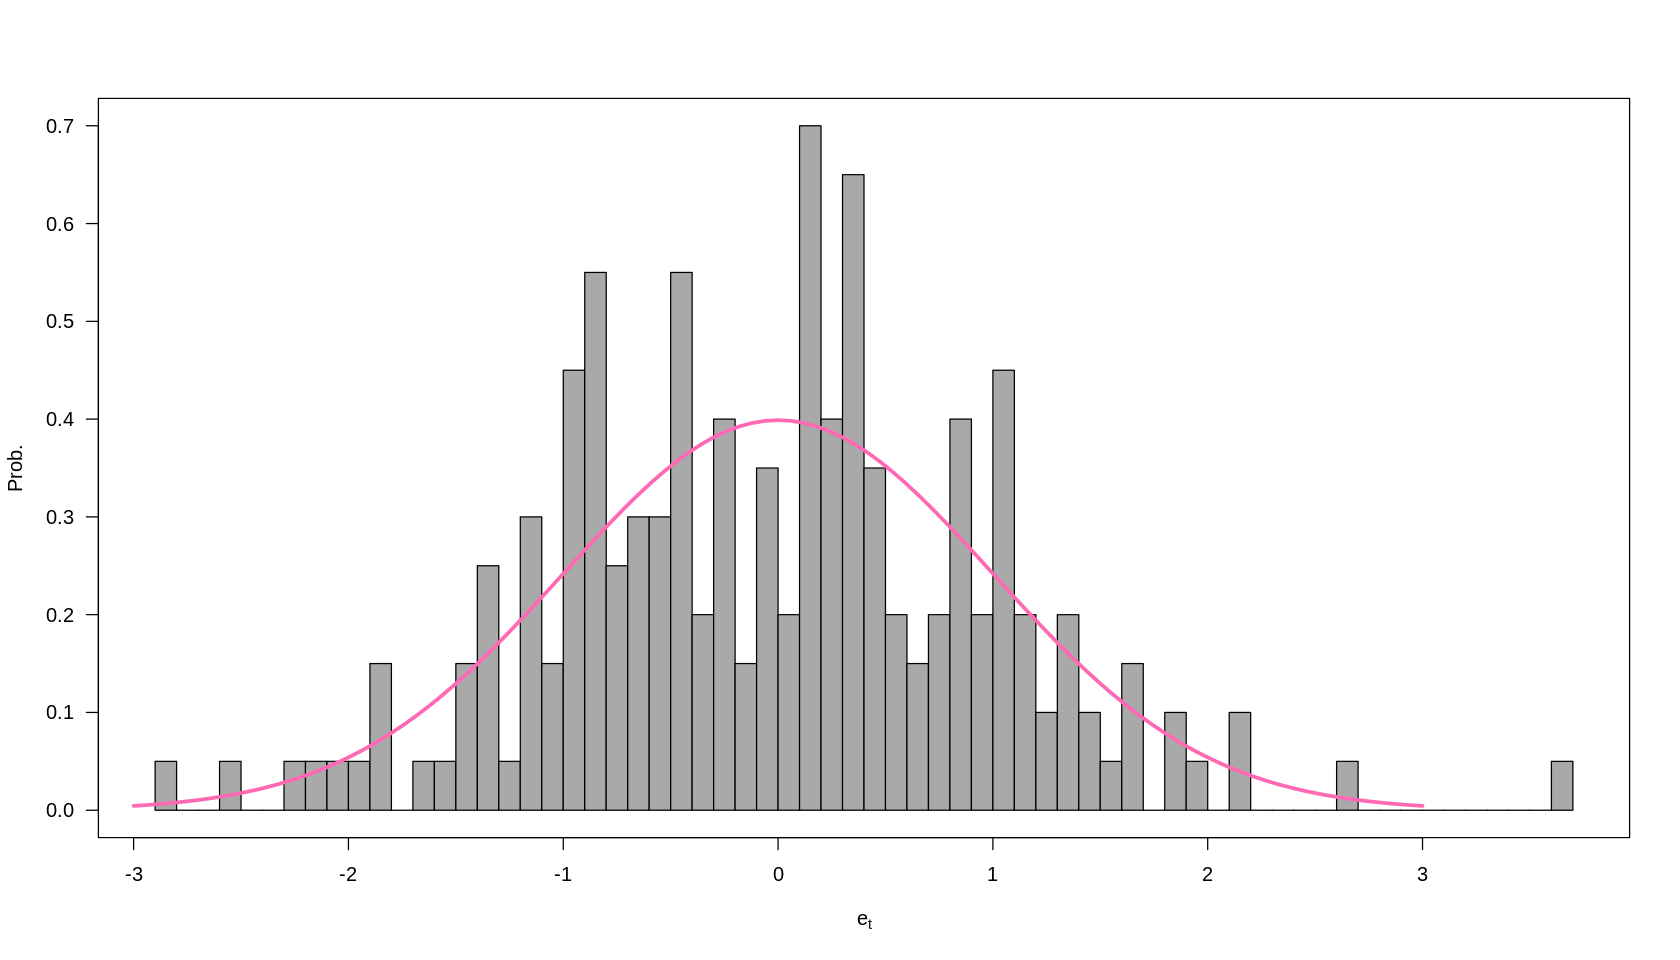

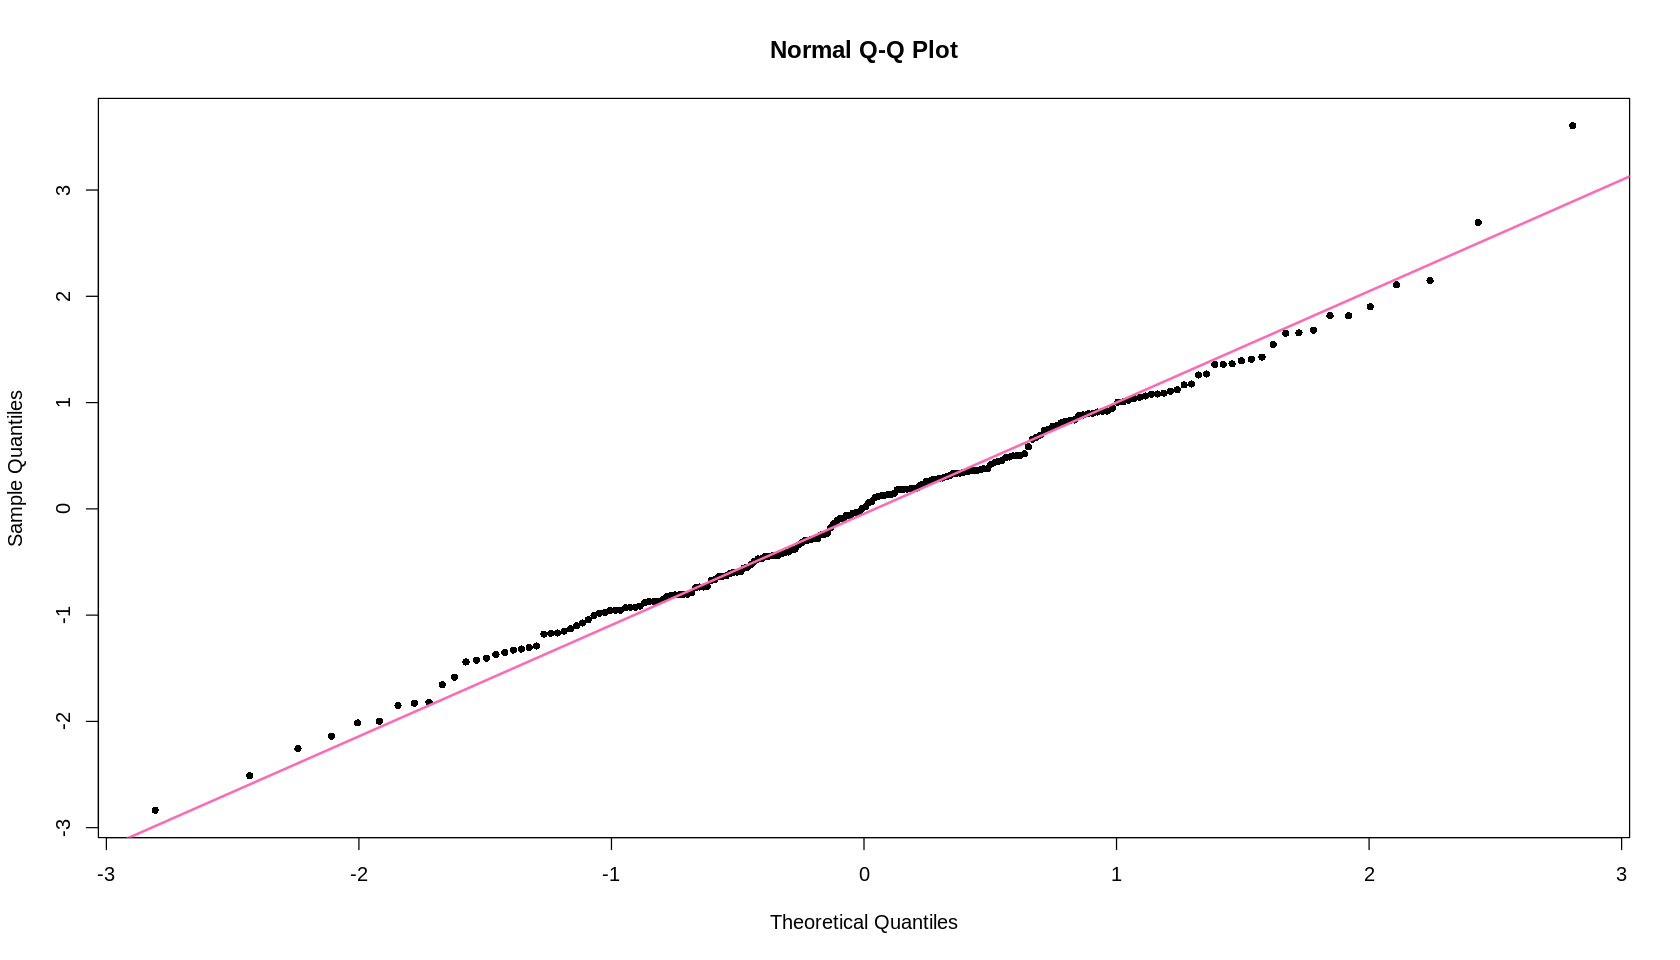

In [50]:
# Hist + QQ of standardized OSA residuals
hist(
    res_osa_std,
    breaks = 50,
    freq = FALSE,
    main = "",
    ylab = "Prob.",
    xlab = expression(e[t]),
    las = 1,
    col = "darkgrey"
)
box()
curve(dnorm, -3, 3, add = TRUE, col = "hotpink", lwd = 3)
qqnorm(y = res_osa_std, pch = 16, cex = 0.8)
qqline(y = res_osa_std, col = "hotpink", lwd = 2)

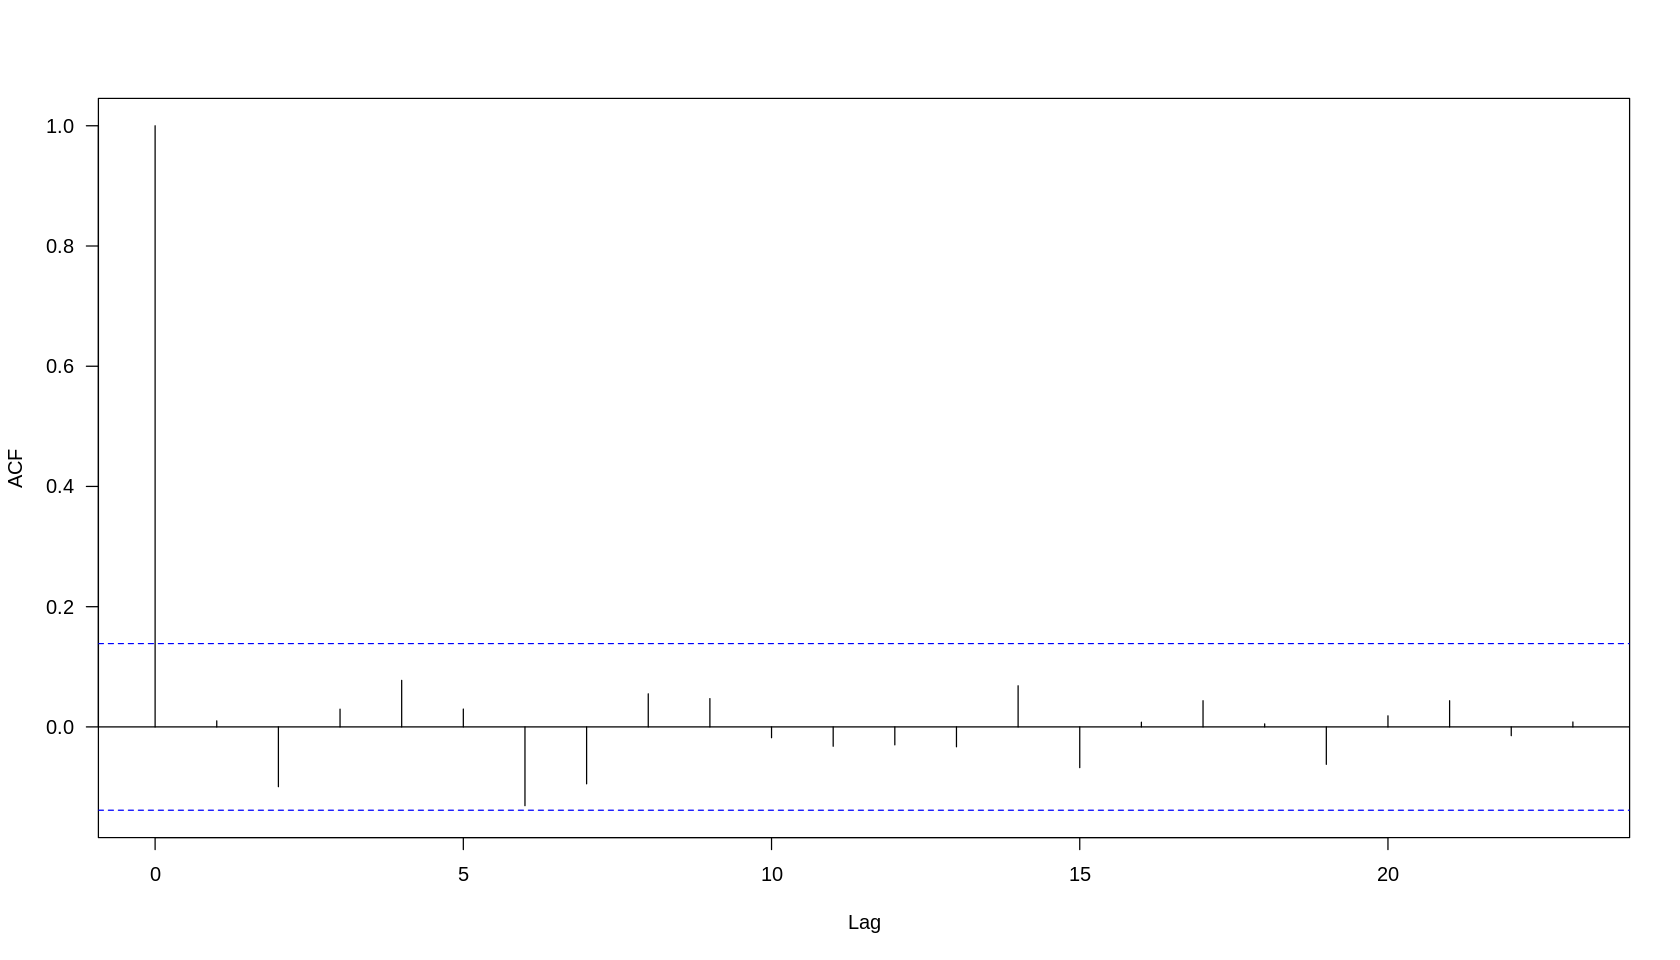

In [51]:
# ACF of OSA residuals
acf(res_osa_std, las = 1, main = "")

In [52]:
# Bias and dispersion indices
m1 <- sum(res_osa_std)/time_steps
m2 <- sum((res_osa_std - m1)^2)/time_steps
bias_idx <- sqrt(time_steps) * m1
disp_idx <- (time_steps*m2 - time_steps + 1) / sqrt(2*(time_steps-1))
c(Bias = bias_idx, Dispersion = disp_idx)

Bias  Dispersion 
-0.37940406  0.03162729

# TMB

In [53]:
# Write the TMB C++ model to file
cpp_model <- '
#include <TMB.hpp>

template<class Type>
Type objective_function<Type>::operator() ()
{
    // --- Data inputs ---
    DATA_VECTOR(y);                  // observations y₁…y_T
    DATA_VECTOR_INDICATOR(keep, y);  // indicator for one‑step‑ahead residuals

    // --- Parameters (unconstrained) ---
    PARAMETER(logSdP);               // log process SD
    PARAMETER(logSdO);               // log observation SD
    PARAMETER_VECTOR(z);             // latent states z₀…z_T

    // --- Transform parameters to enforce positivity ---
    Type sdp = exp(logSdP);
    Type sdo = exp(logSdO);

    // --- Negative log‑likelihood accumulator ---
    Type nll = 0.0;

    // --- Process model: zₜ ~ N(zₜ₋₁, sdp) for t = 1…T ---
    for(int i = 1; i < z.size(); ++i) {
        nll -= dnorm(z(i), z(i-1), sdp, true);
        SIMULATE { z(i) = rnorm(z(i-1), sdp); }
    }

    // --- Observation model: yₜ ~ N(zₜ, sdo) for t = 1…T ---
    //   note: z(1) is z₁, so y(i) matches z(i+1)
    for(int i = 0; i < y.size(); ++i) {
        nll -= keep(i) * dnorm(y(i), z(i+1), sdo, true);
        SIMULATE { y(i) = rnorm(z(i+1), sdo); }
    }

    // --- Report transformed SDs for standard errors ---
    ADREPORT(sdp);
    ADREPORT(sdo);

    // --- Report simulated draws for model checking ---
    SIMULATE {
        REPORT(z);
        REPORT(y);
    }

    return nll;
}
'
writeLines(cpp_model, con = "toy2p.cpp")

In [54]:
# Compile and load the TMB model
compile("toy2p.cpp")
dyn.load(dynlib("toy2p"))

using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’



[1] 0

In [55]:
# Prepare TMB inputs: data list, parameter list, and map
data_tmb <- list(y = obs_y)        # Observed y₁…y_T
par_tmb <- list(
    logSdP = 0,                    # Initial log process SD
    logSdO = 0,                    # Initial log obs SD
    z = rep(0, length(obs_y) + 1)  # Initial z₀…z_T
)
map_tmb <- list(z = as.factor(c(NA, seq_along(obs_y))))  # Fix z₀ at 0

In [56]:
# Build the TMB objective function
tmb_obj <- MakeADFun(
    data = data_tmb,
    parameters = par_tmb,
    map = map_tmb,
    random = "z",
    DLL = "toy2p",
    silent = TRUE
)

In [57]:
# Optimize (minimize negative log‑likelihood)
opt_tmb <- nlminb(
    start = tmb_obj$par,
    objective = tmb_obj$fn,
    gradient = tmb_obj$gr
)
opt_tmb$convergence  # 0 indicates success

[1] 0

In [58]:
# Summarize parameter estimates and SEs
sdr_tmb <- summary(sdreport(tmb_obj))
est_sdp <- sdr_tmb["sdp", "Estimate"]
est_sdo <- sdr_tmb["sdo", "Estimate"]
sdr_tmb[c("sdp", "sdo"),]

Estimate   Std. Error 
sdp 0.09708704 0.011864980
sdo 0.10220412 0.009991131

In [59]:
# Extract smoothed states and their SEs
zs_se <- sdr_tmb[row.names(sdr_tmb) == "z",]
zs_point <- tmb_obj$env$parList()$z
head(zs_se)
cat("\n")
head(zs_point)

Estimate   Std. Error
z 0.01795333 0.06209183
z 0.10895405 0.06609551
z 0.19539807 0.06770268
z 0.24694438 0.06906192
z 0.17284919 0.06777417
z 0.17986227 0.06885101

[1] 0.00000000 0.01790497 0.10895986 0.19545418 0.24703165 0.17279499

In [60]:
# Compute 95% CI for smoothed states
zs_lower <- zs_se[, "Estimate"] + qnorm(0.025) * zs_se[, "Std. Error"]
zs_upper <- zs_se[, "Estimate"] + qnorm(0.975) * zs_se[, "Std. Error"]

In [61]:
# Debug: check lengths of all relevant vectors
lengths <- sapply(list(
    obs_time_idx = obs_time_idx,
    obs_y = obs_y,
    time_idx = time_idx,
    states_z = states_z,
    zs_point = zs_point,
    zs_lower = zs_lower,
    zs_upper = zs_upper
), length)
print(lengths)

obs_time_idx        obs_y     time_idx     states_z     zs_point     zs_lower 
         200          200          201          201          201          200 
    zs_upper 
         200 


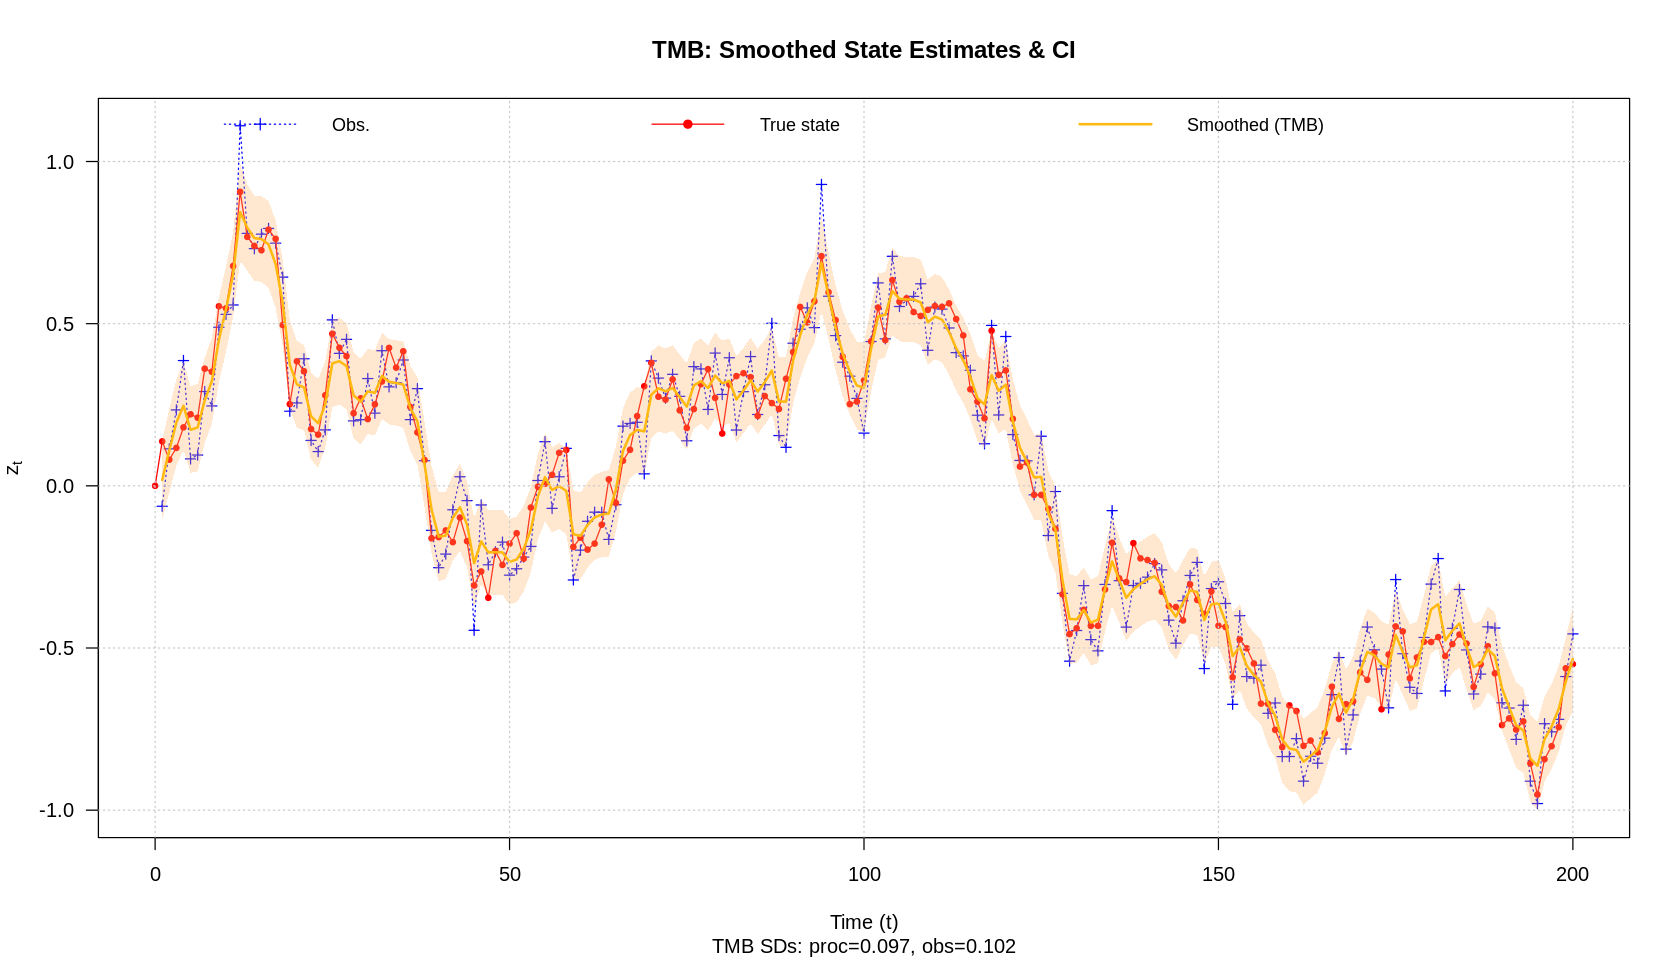

In [62]:
# Plot observations, true states, TMB-smoothed states, and CI

# Rebuild time indices
obs_time_idx <- 1:time_steps   # covers t = 1…time_steps
time_idx <- 0:time_steps       # covers t = 0…time_steps

plot(
    obs_time_idx,
    obs_y,
    type = "o",         # points + lines for obs
    pch = 3,            # open cross
    cex = 0.8,
    col = "blue",
    lty = 3,            # dashed line
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, zs_lower, zs_upper)),
    las = 1,
    main = "TMB: Smoothed State Estimates & CI",
    sub = paste0("TMB SDs: proc=", round(est_sdp, 3),
                 ", obs=", round(est_sdo, 3))
)

points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Shade 95% CI for t = 1…time_steps
polygon(
    x = c(obs_time_idx, rev(obs_time_idx)),
    y = c(zs_lower, rev(zs_upper)),
    col = rgb(1, 0.7, 0.4, 0.3),
    border = NA
)

# Plot smoothed estimates for t = 1…time_steps
lines(
    obs_time_idx,
    zs_point[-1],
    lwd = 2,
    col = "darkgoldenrod1"
)

# Legend at top
legend(
    "top",
    legend = c("Obs.", "True state", "Smoothed (TMB)"),
    pch = c(3, 19, NA),
    lty = c(3, 1, 1),
    lwd = c(1, 1, 2),
    col = c("blue", "red", "darkgoldenrod1"),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

# Add a grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [63]:
# Write the 4-parameter TMB C++ model to disk
cpp_model_4p <- '
#include <TMB.hpp>

template<class Type>
Type objective_function<Type>::operator() ()
{
    // --- Data inputs ---
    DATA_VECTOR(y);                 // observations y₁…y_T
    DATA_VECTOR_INDICATOR(keep, y); // for one-step-ahead residuals

    // --- Parameters (unconstrained) ---
    PARAMETER(logSdP);              // log process SD
    PARAMETER(logSdO);              // log obs SD
    PARAMETER(alpha);               // observation multiplier
    PARAMETER(beta);                // process multiplier
    PARAMETER_VECTOR(z);            // latent states z₀…z_T

    // --- Transform parameters to enforce positivity ---
    Type sdp = exp(logSdP);
    Type sdo = exp(logSdO);

    // --- Negative log-likelihood ---
    Type nll = 0.0;

    // Process model: zₜ ~ N(beta·zₜ₋₁, sdp)
    for(int i = 1; i < z.size(); ++i) {
        nll -= dnorm(z(i), beta * z(i-1), sdp, true);
        SIMULATE { z(i) = rnorm(beta * z(i-1), sdp); }
    }

    // Observation model: yₜ ~ N(alpha·zₜ, sdo)
    for(int i = 0; i < y.size(); ++i) {
        nll -= keep(i) * dnorm(y(i), alpha * z(i+1), sdo, true);
        SIMULATE { y(i) = rnorm(alpha * z(i+1), sdo); }
    }

    // --- Report transformed SDs for SE calculation ---
    ADREPORT(sdp);
    ADREPORT(sdo);

    // --- Report simulated draws for model checking ---
    SIMULATE {
        REPORT(z);
        REPORT(y);
    }

    return nll;
}
'
writeLines(cpp_model_4p, con = "toy4p.cpp")

In [64]:
# Compile and load the new model
compile("toy4p.cpp")
dyn.load(dynlib("toy4p"))

using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’



[1] 0

In [65]:
# Prepare data, parameters, and map for fitting
data_tmb <- list(y = obs_y)              # y₁…y_T

par4p_tmb <- list(
    logSdP = log(process_var_stdev),     # true sim = log(0.1)
    logSdO = log(obs_error_stdev),       # true sim = log(0.1)
    alpha = 1,                           # true sim = 1
    beta = 1,                            # true sim = 1
    z = rep(0, length(obs_y) + 1)        # initial z₀…z_T
)

# Fix z₀ = 0
map_tmb <- list(z = as.factor(c(NA, seq_along(obs_y))))

In [66]:
# 4) Build TMB object for 4-parameter model
tmb_obj_4p <- MakeADFun(
    data = data_tmb,
    parameters = par4p_tmb,
    map = map_tmb,
    random = "z",
    DLL = "toy4p",
    silent = TRUE
)

In [67]:
# Optimize with nlminb
opt_4p <- nlminb(
    start = tmb_obj_4p$par,
    objective = tmb_obj_4p$fn,
    gradient = tmb_obj_4p$gr
)
opt_4p$convergence   # 0 indicates success
opt_4p$message       # convergence message

[1] 0

[1] "relative convergence (4)"

In [68]:
# Summarize parameter estimates & SEs
sdr_4p <- summary(sdreport(tmb_obj_4p))

param_sim <- c(sdp = process_var_stdev,
               sdo = obs_error_stdev,
               beta = 1,
               alpha = 1)

param_est <- c(
    sdr_4p["sdp", "Estimate"],
    sdr_4p["sdo", "Estimate"],
    sdr_4p["beta", "Estimate"],
    sdr_4p["alpha", "Estimate"]
)

round(cbind(Simulated = param_sim, Estimate = param_est), 3)

Simulated Estimate
sdp   0.1       0.100   
sdo   0.1       0.100   
beta  1.0       0.978   
alpha 1.0       0.999

In [69]:
# Compare AIC for 2- vs 4-parameter TMB models
aic2pTmb <- 2 * 2 + 2 * opt_tmb$objective
aic4pTmb <- 2 * 4 + 2 * opt_4p$objective

cbind(
    Original = aic2pTmb,
    Flexible = aic4pTmb,
    Difference = aic4pTmb - aic2pTmb
)

Original  Flexible  Difference
[1,] -157.5902 -155.3975 2.192612

In [70]:
# Simulate from the simple TMB model for verification
set.seed(123)
data_sim_tmb <- list(y = numeric(time_steps))
par_sim_tmb <- list(
    logSdP = log(process_var_stdev),
    logSdO = log(obs_error_stdev),
    z = rep(0, time_steps + 1)
)

tmb_sim_obj <- MakeADFun(
    data = data_sim_tmb,
    parameters = par_sim_tmb,
    map = map_tmb,
    random = "z",
    DLL = "toy2p",
    silent = TRUE
)

sim_tmb <- tmb_sim_obj$simulate()

# Compare tail of simulated vs. original
tail(cbind(
    "Orig y" = obs_y,
    "Sim y" = sim_tmb$y,
    "Orig z" = states_z[-1],
    "Sim z" = sim_tmb$z[-1]
))

Orig y     Sim y       Orig z     Sim z       
[195,] -0.9796233 -0.18376541 -0.9516976 -0.126409378
[196,] -0.7334688  0.22370202 -0.8431201  0.073311960
[197,] -0.7585413  0.05596835 -0.8027427  0.133382843
[198,] -0.7199923  0.09282886 -0.7440939  0.008255706
[199,] -0.5881318 -0.17892917 -0.5625711 -0.052860885
[200,] -0.4565856 -0.20686313 -0.5496889 -0.171408894

In [71]:
# Fit model to the simulated data to check estimation
tmb_check_obj <- MakeADFun(
    data = list(y = sim_tmb$y),
    parameters = par_sim_tmb,
    map = map_tmb,
    random = "z",
    DLL = "toy2p",
    silent = TRUE
)

opt_check_tmb <- nlminb(
    start = tmb_check_obj$par,
    objective = tmb_check_obj$fn,
    gradient = tmb_check_obj$gr
)

opt_check_tmb$message   # convergence message

[1] "both X-convergence and relative convergence (5)"

In [72]:
# Compare true vs. estimated parameters
true_pars <- c(logSdP = par_sim_tmb$logSdP,
               logSdO = par_sim_tmb$logSdO)

est_pars <- opt_check_tmb$par
cbind(True = true_pars, Est = est_pars)

# Compare simulated vs. estimated states
state_diff <- abs(sim_tmb$z - tmb_check_obj$env$parList()$z)
cat("\n")
summary(state_diff)

True      Est      
logSdP -2.302585 -2.482354
logSdO -2.302585 -2.276059

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01844 0.04042 0.05058 0.07785 0.19585 

In [73]:
# Frequentist predictive checks via TMB simulation
nrep <- 200               # number of simulated replicates
set.seed(1234)            # reproducibility

# Matrix to store test statistics
repsT <- matrix(
    NA, nrow = nrep, ncol = 2,
    dimnames = list(NULL, c("Mean", "SD"))
)

# For each replicate, simulate y and compute mean and SD
for (i in seq_len(nrep)) {
    sim_i <- tmb_obj$simulate()  # uses MLE in tmb_obj$env$last.par
    repsT[i, 1] <- mean(sim_i$y)
    repsT[i, 2] <- sd(sim_i$y)
}

# Approximate p-values: fraction of replicates ≥ observed
mean_p <- sum(repsT[, "Mean"] >= mean(obs_y)) / nrep
sd_p <- sum(repsT[, "SD"] >= sd(obs_y)) / nrep

# display p-values
mean_p
sd_p

[1] 0.51

[1] 0.595

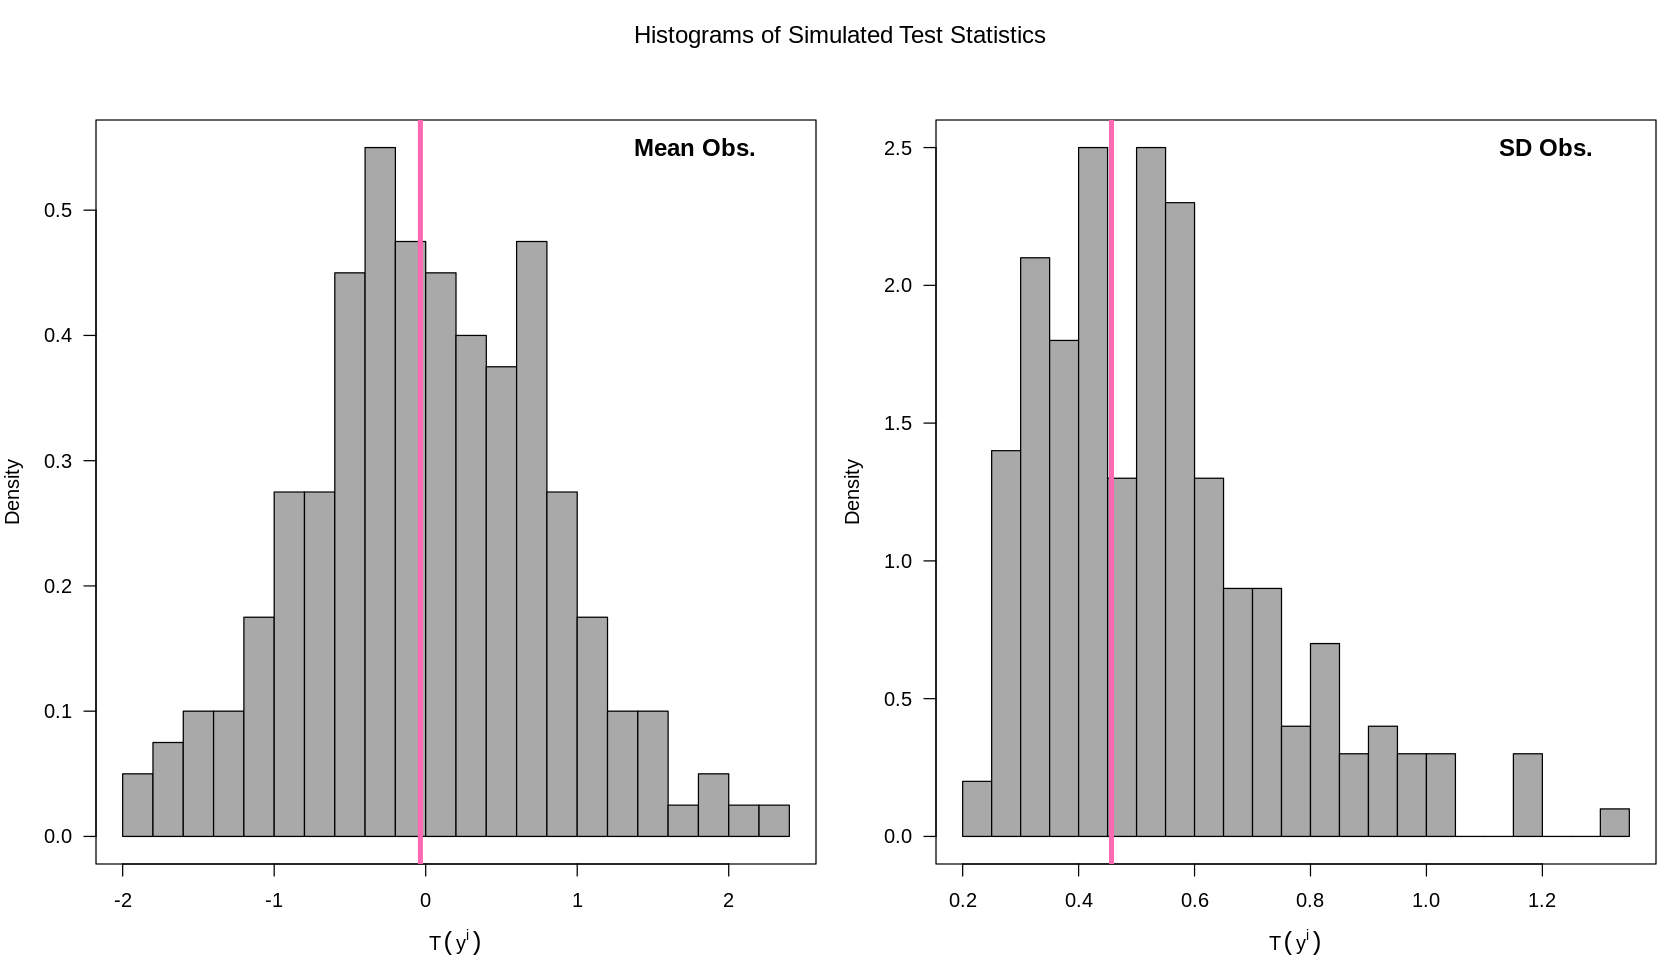

In [74]:
# Plot histograms of simulated test statistics

# Set up 1×2 panels, leave room in outer margin for shared title
par(
    mfrow = c(1, 2),
    mar = c(4, 4, 2, 1),   # bottom, left, top, right
    oma = c(0, 0, 3, 0)    # outer margin for shared title (top = 3 lines)
)

# Histogram of means
hist(
    repsT[, "Mean"],
    breaks = 30,
    freq = FALSE,
    main = "",
    las = 1,
    col = "darkgrey",
    xlab = expression(T(y^{i}))
)
box()
abline(v = mean(obs_y), col = "hotpink", lwd = 4)
title("Mean Obs.", line = -1.5, adj = 0.9)

# Histogram of standard deviations
hist(
    repsT[, "SD"],
    breaks = 30,
    freq = FALSE,
    main = "",
    las = 1,
    col = "darkgrey",
    xlab = expression(T(y^{i}))
)
box()
abline(v = sd(obs_y), col = "hotpink", lwd = 4)
title("SD Obs.", line = -1.5, adj = 0.9)

# Add shared main title
mtext(
    "Histograms of Simulated Test Statistics",
    outer = TRUE,
    cex = 1.2,
    line = 1
)

# Reset graphic parameters
par(mfrow = c(1, 1), oma = c(0, 0, 0, 0))

In [75]:
# One-step-ahead residual diagnostics for simple model

# Rebuild and refit simple model to update last.par
tmb_obj <- MakeADFun(
    data = data_tmb,
    parameters = par_tmb,
    map = map_tmb,
    random = "z",
    DLL = "toy2p",
    silent = TRUE
)

opt_tmb <- nlminb(
    start = tmb_obj$par,
    objective = tmb_obj$fn,
    gradient = tmb_obj$gr
)

In [76]:
# Compute one-step-ahead residuals
res_osa <- oneStepPredict(
    obj = tmb_obj,
    observation.name = "y",
    data.term.indicator = "keep",
    trace = FALSE
)

# Inspect head of residual matrix
head(res_osa)

observation nll        grad      mean          residual  
200 -0.06299708 -0.9404369 -3.170211 -1.360023e-15 -0.4468937
199  0.11400375 -1.4524644  5.795681 -2.988207e-02  0.9131902
198  0.23407138 -1.7306815  6.967277  5.346390e-02  1.1217586
197  0.38617905 -1.6659554  8.613653  1.612934e-01  1.3917927
196  0.08296580 -1.6993864 -8.158152  2.962036e-01 -1.3189488
195  0.09495395 -2.4999765 -2.801129  1.681833e-01 -0.4529070

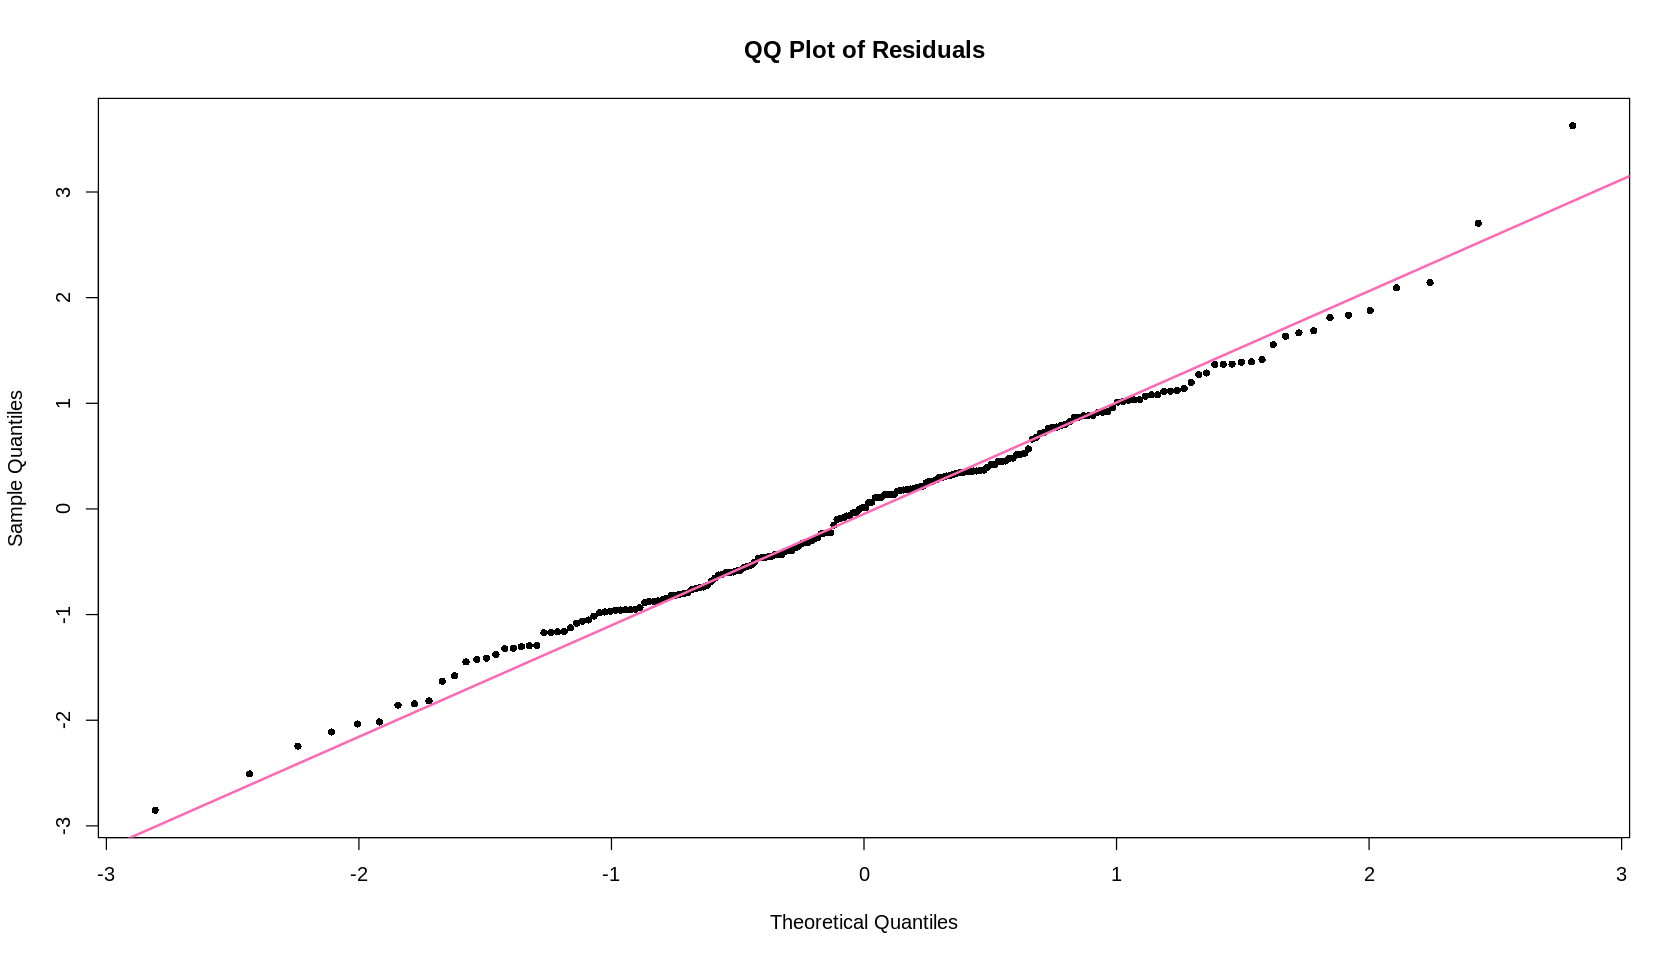

In [77]:
# QQ-plot of residuals
qqnorm(
    res_osa$residual,
    main = "QQ Plot of Residuals",
    pch = 16,
    cex = 0.8
)
qqline(
    res_osa$residual,
    col = "hotpink",
    lwd = 2
)

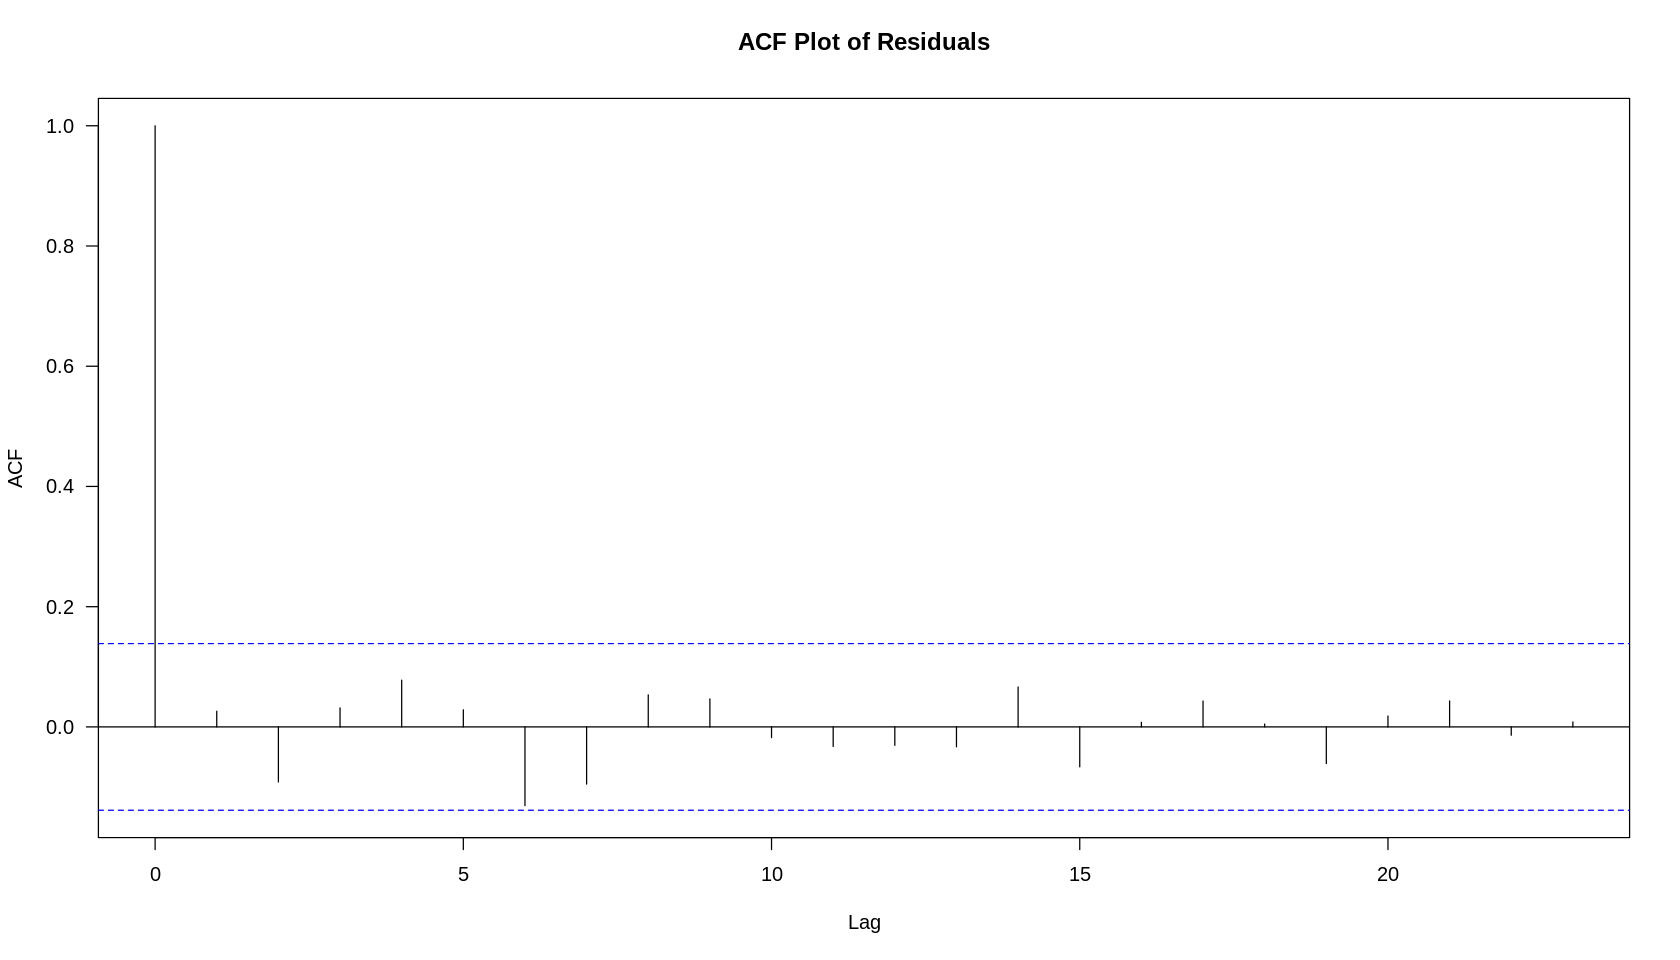

In [78]:
# ACF of residuals
acf(
    res_osa$residual,
    las = 1,
    main = "ACF Plot of Residuals"
)

In [79]:
# Check Laplace approximation consistency
set.seed(12345)
checkConsistency(tmb_obj)

Parameters used for simulation:
   logSdP    logSdO 
-2.332147 -2.280783 

Test correct simulation (p.value):
[1] 0.18758
Simulation appears to be correct

Estimated parameter bias:
       logSdP        logSdO 
 0.0003692932 -0.0062153668 

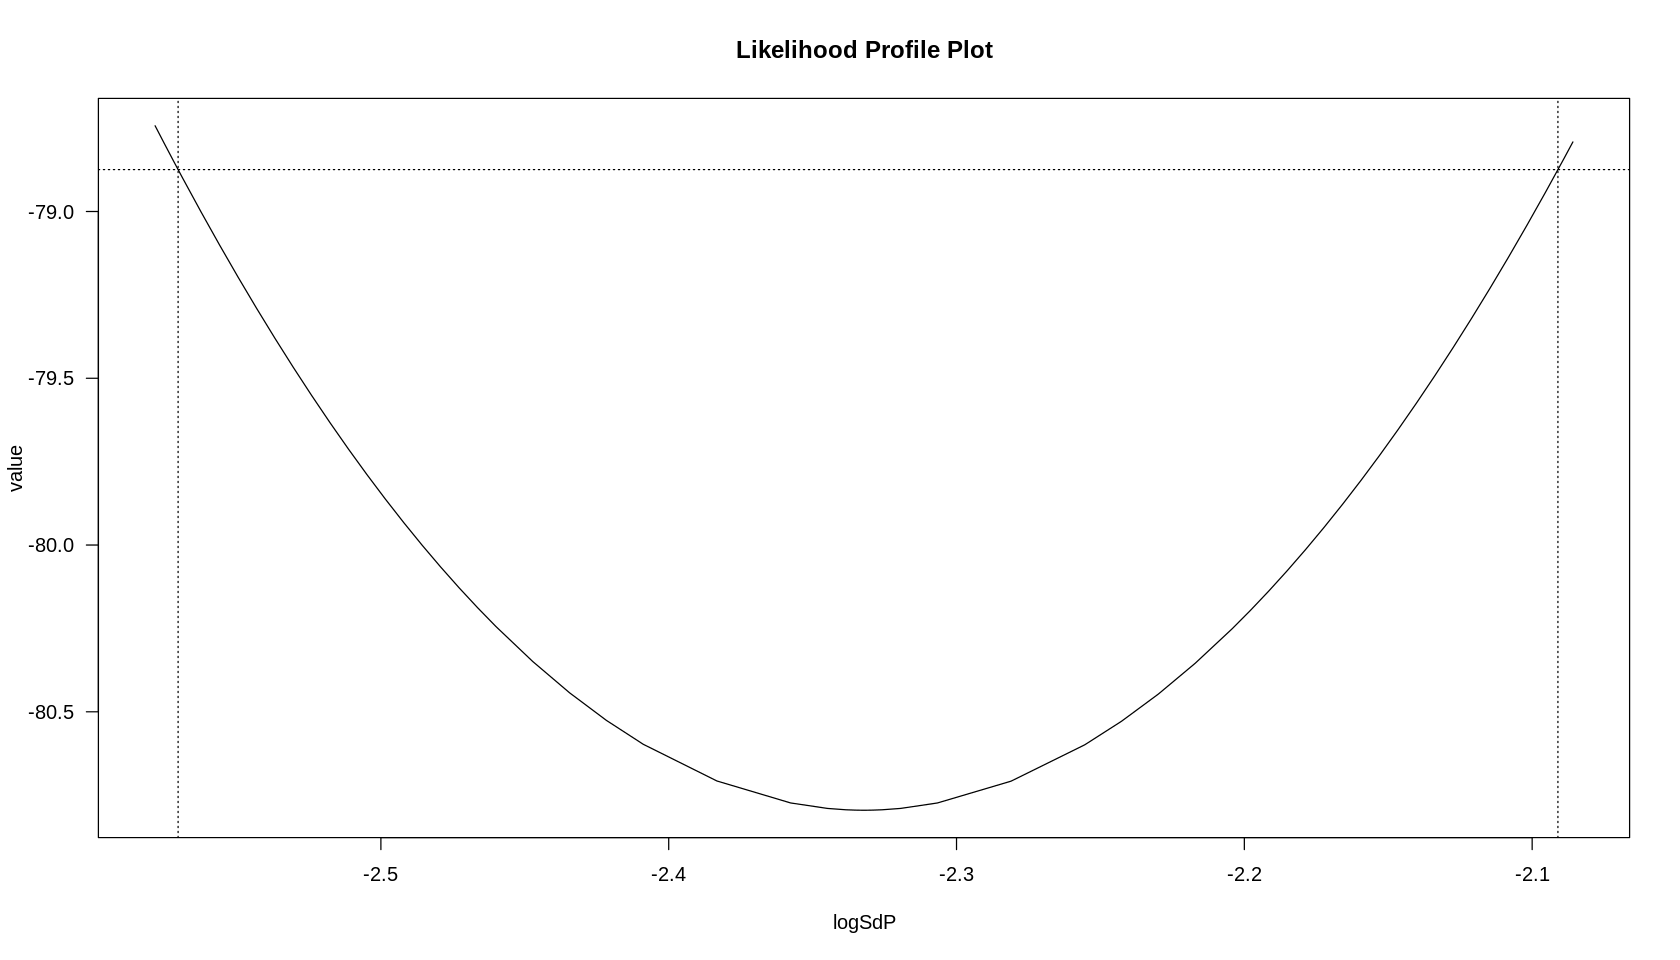

In [80]:
# Likelihood profiling and CIs for simple model

# Profile the process‐noise log-SD
prof_sdp2p <- tmbprofile(
    tmb_obj,   # simple model object
    "logSdP",  # parameter to profile
    trace = FALSE
)
plot(prof_sdp2p, las = 1, main = "Likelihood Profile Plot")

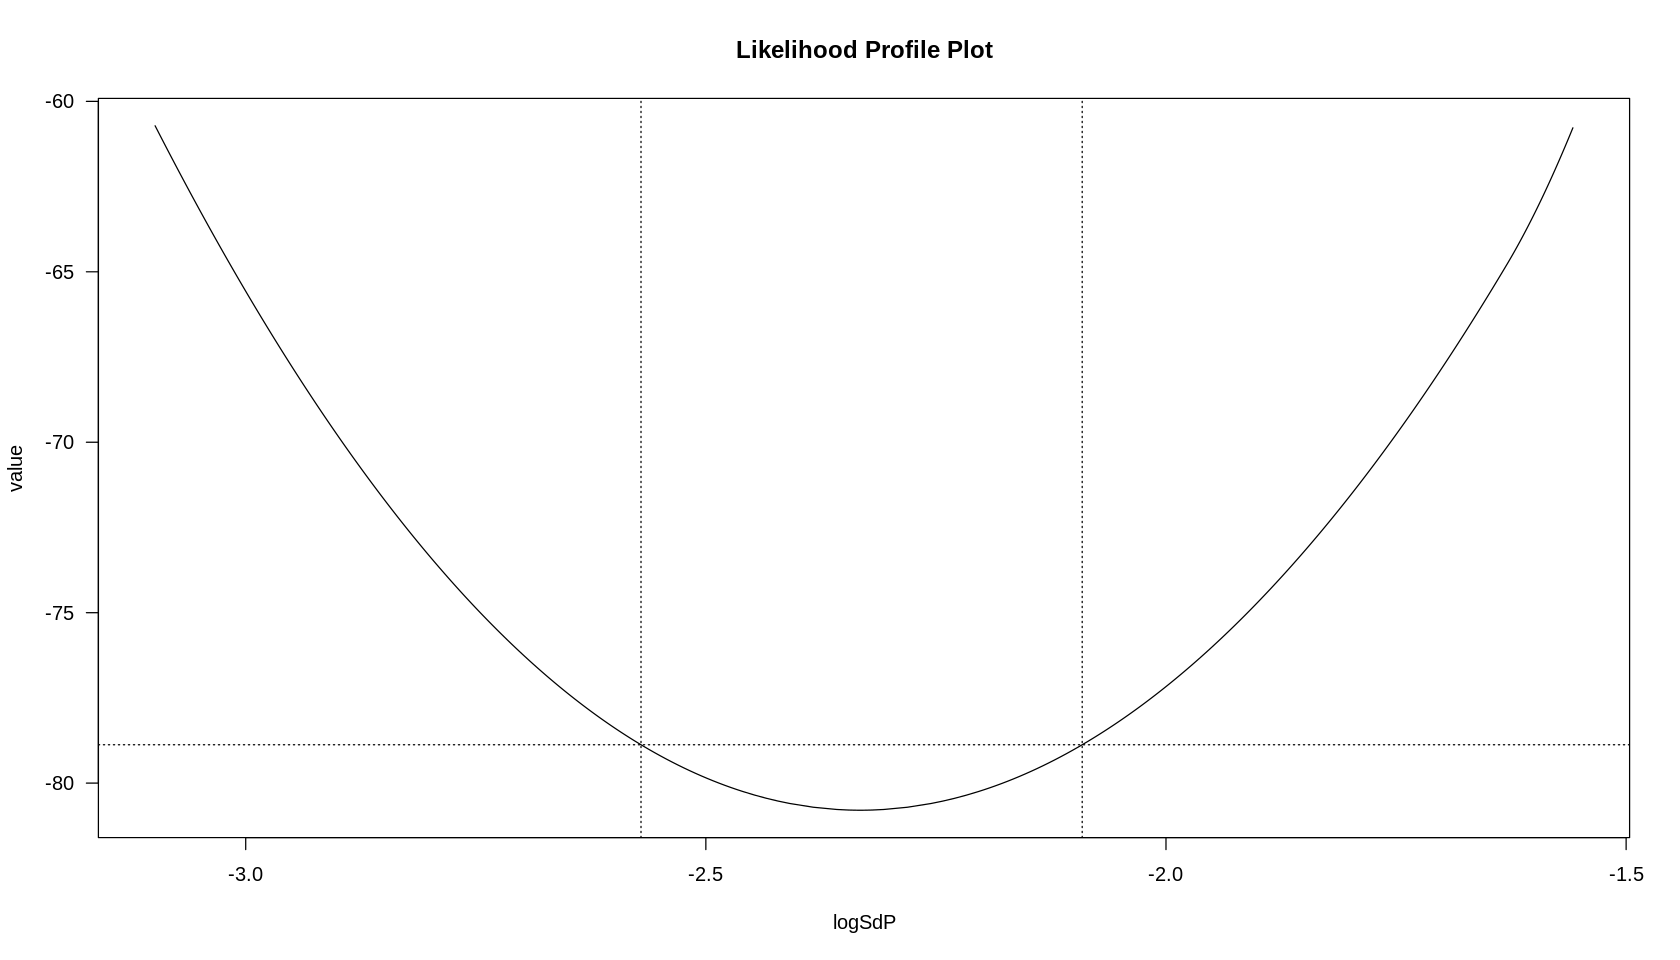

In [81]:
# Widen the profile window
prof_sdp2p_wide <- tmbprofile(
    tmb_obj,
    "logSdP",
    trace = FALSE,
    ytol = 20
)
plot(prof_sdp2p_wide, las = 1, main = "Likelihood Profile Plot")

In [82]:
# Extract 95% CI
confint(prof_sdp2p)

lower     upper   
logSdP -2.570459 -2.09105

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


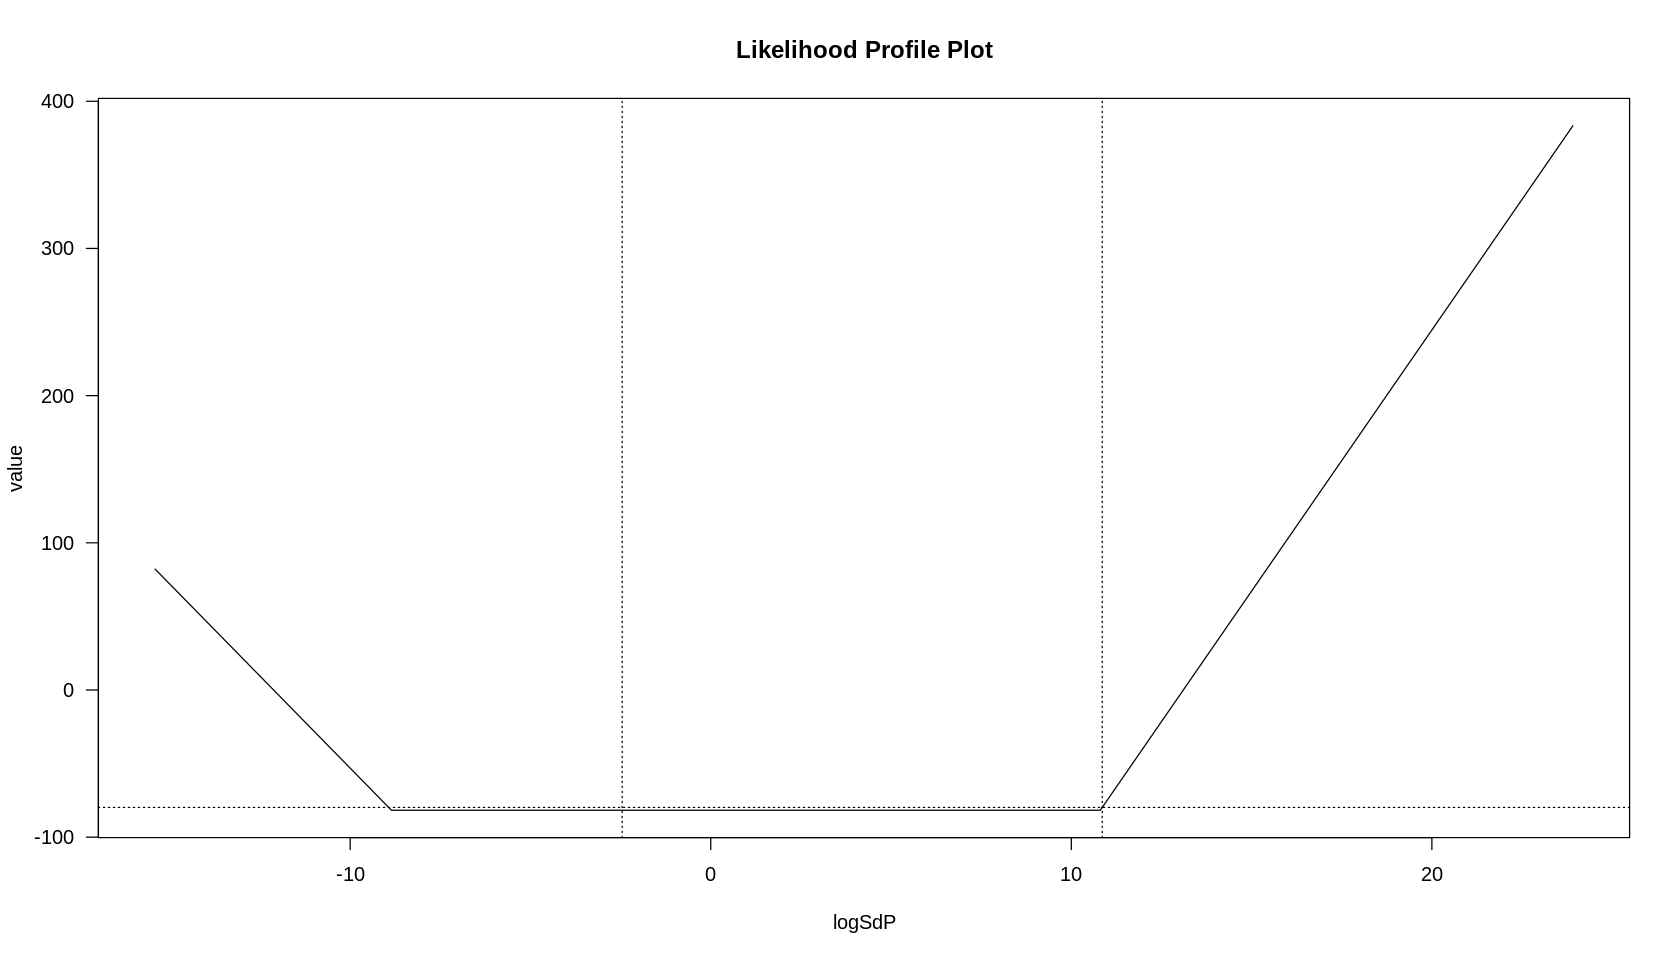

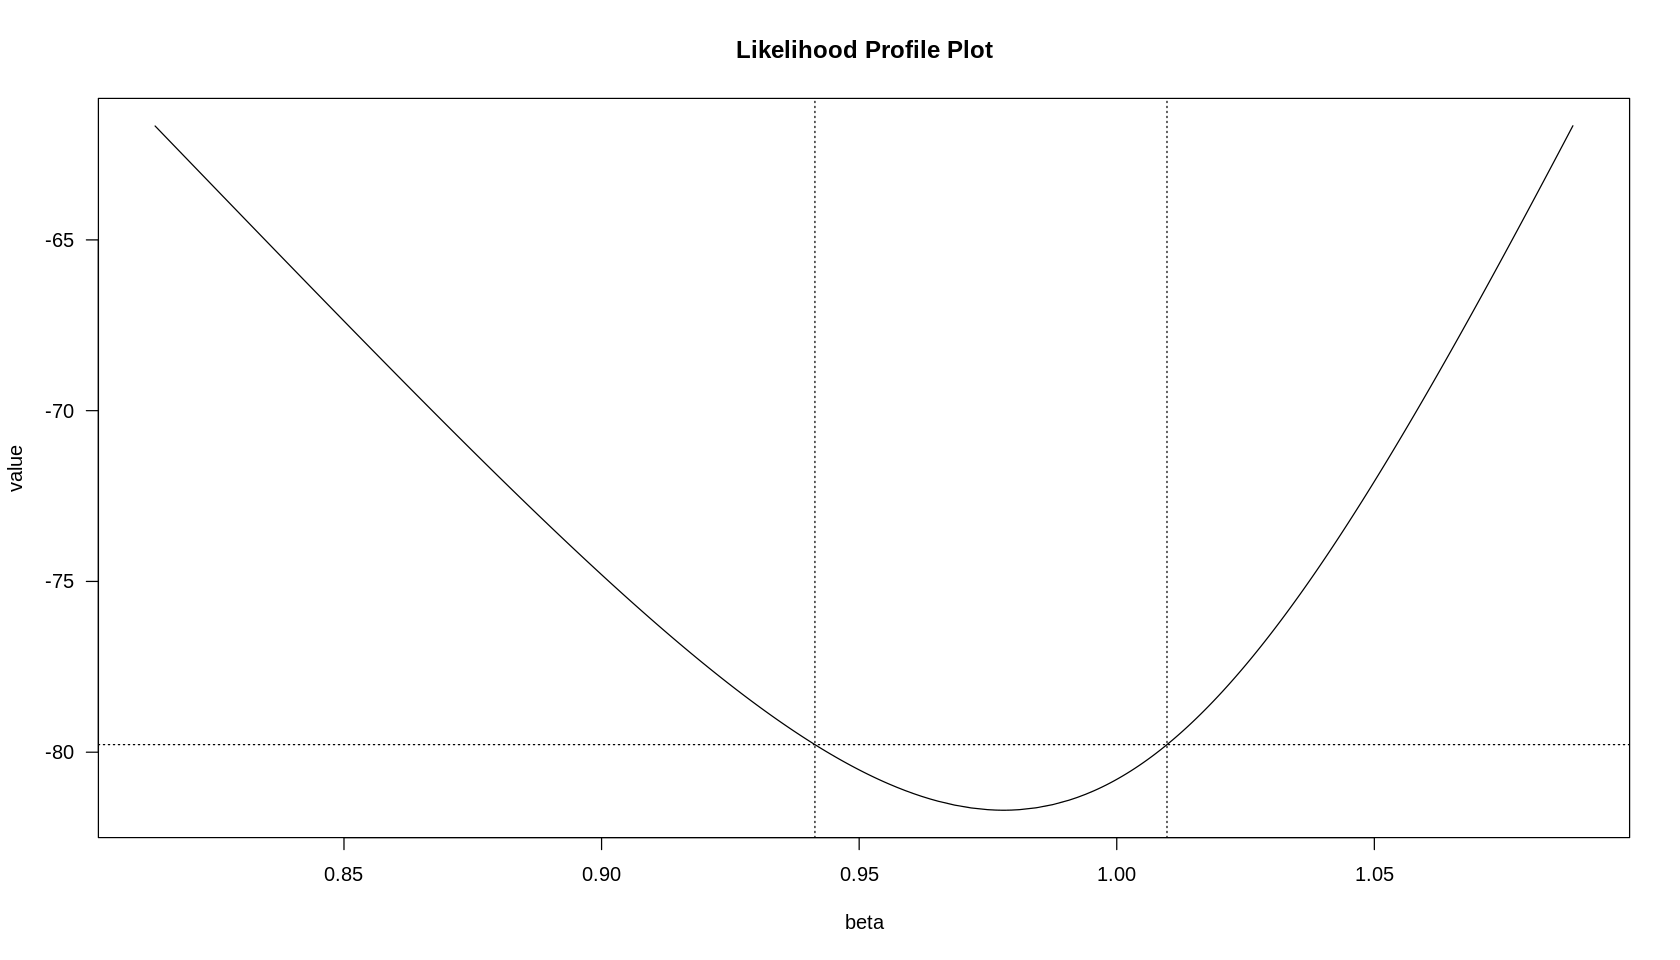

Warning message in nlminb(start, newfn, newgr, control = control):
“NA/NaN function evaluation”
Warning message in nlminb(start, newfn, newgr, control = control):
“NA/NaN function evaluation”


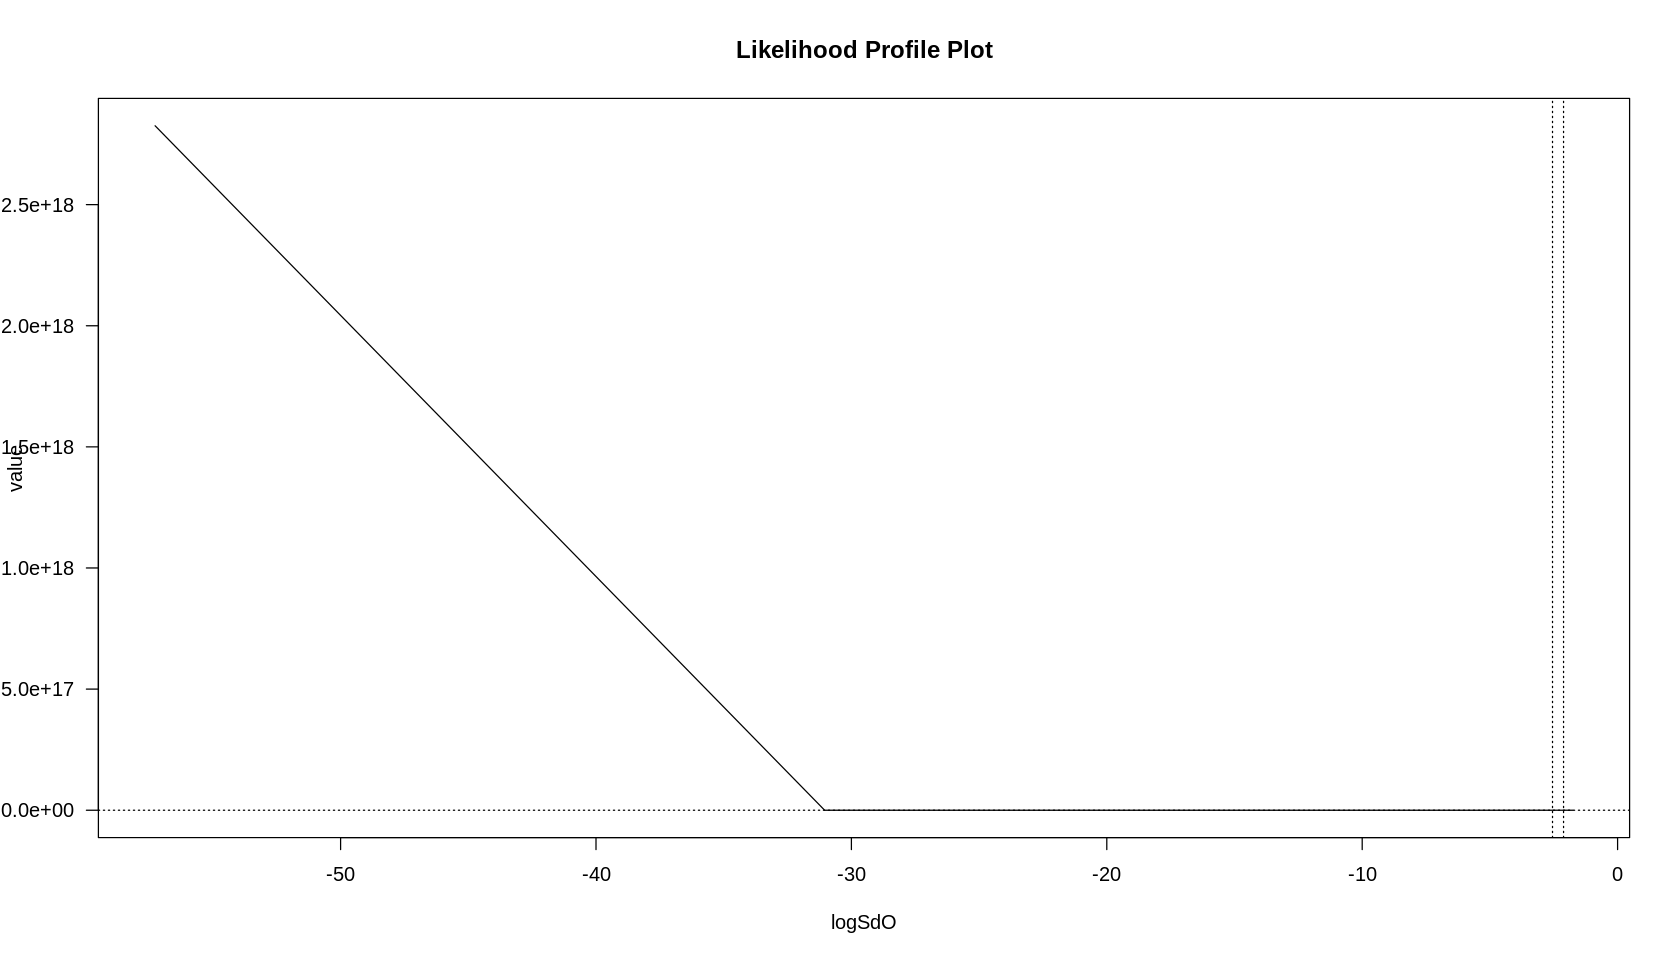

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


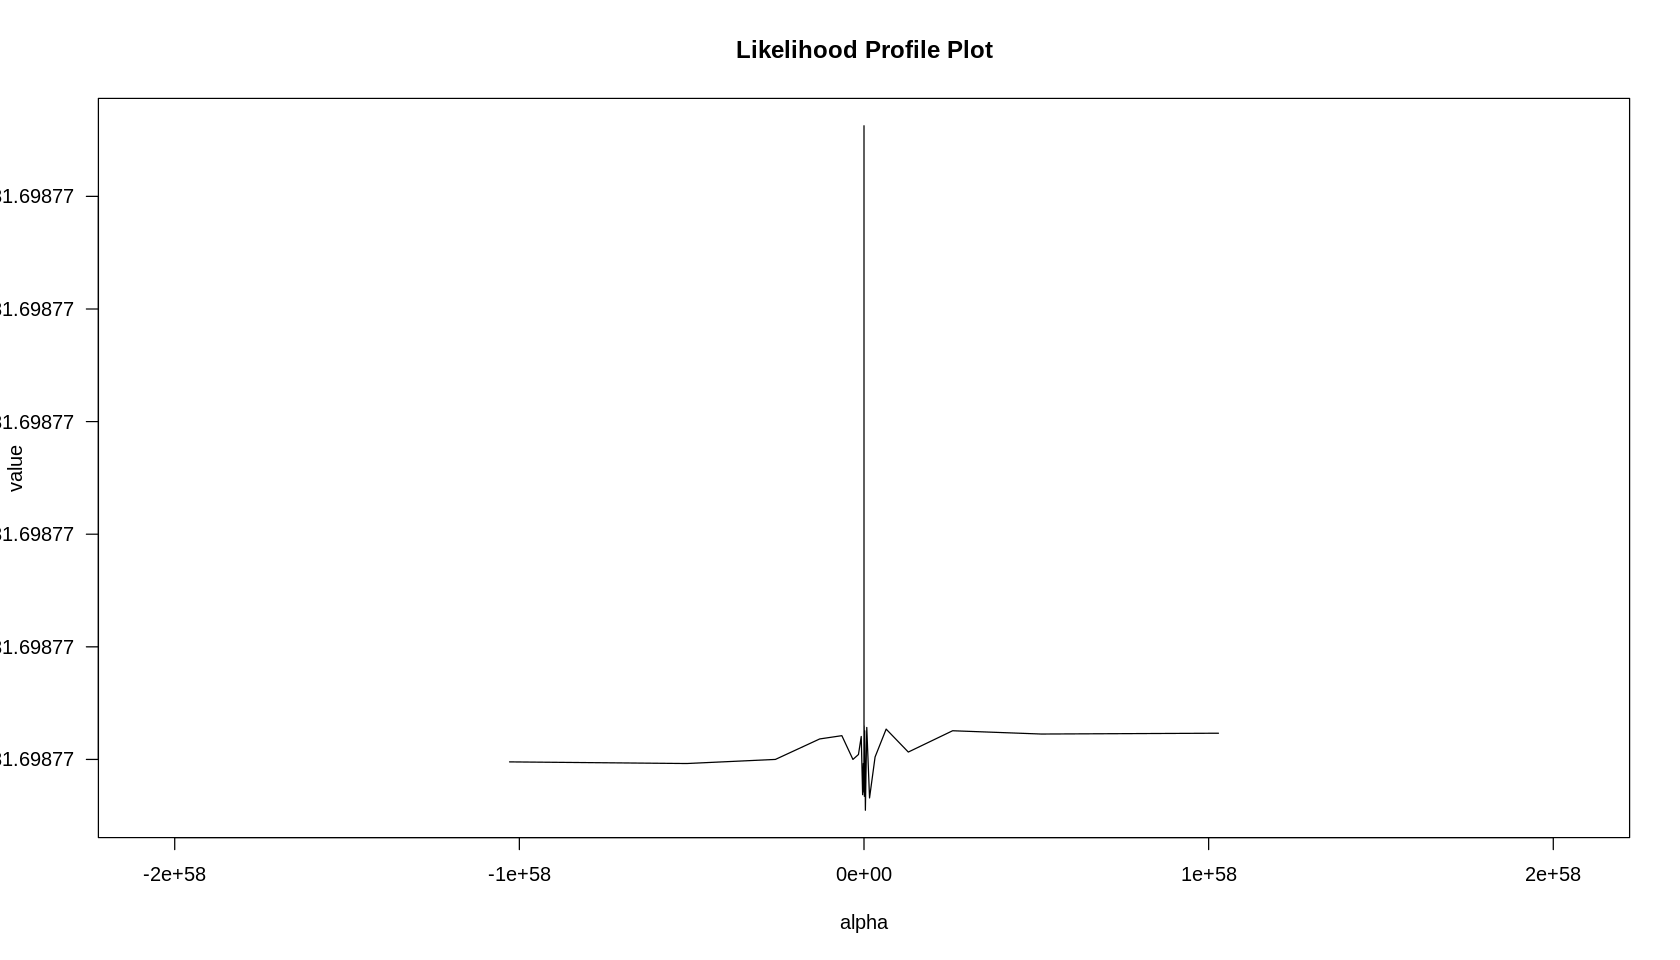

In [83]:
# Likelihood profiling for the flexible 4-param model

# Log-process‐SD
prof_sdp4p <- tmbprofile(
    tmb_obj_4p,
    "logSdP",
    trace = FALSE,
    ytol = 20
)
plot(prof_sdp4p, las = 1, main = "Likelihood Profile Plot")

# Beta (process multiplier)
prof_beta4p <- tmbprofile(
    tmb_obj_4p,
    "beta",
    trace = FALSE,
    ytol = 20
)
plot(prof_beta4p, las = 1, main = "Likelihood Profile Plot")

# Log-obs‐SD
prof_sdo4p <- tmbprofile(
    tmb_obj_4p,
    "logSdO",
    trace = FALSE,
    ytol = 20
)
plot(prof_sdo4p, las = 1, main = "Likelihood Profile Plot")

# Alpha (observation multiplier)
prof_alpha4p <- tmbprofile(
    tmb_obj_4p,
    "alpha",
    trace = FALSE,
    ytol = 20
)
plot(prof_alpha4p, las = 1, main = "Likelihood Profile Plot")

# Sequential Importance Sampling

In [84]:
# Set seed for reproducibility
set.seed(102)

# Number of particles
N_particles <- 100000

# Pre-allocate matrix of particle states: rows = particles, cols = t = 0…time_steps
sis_particle_states <- matrix(
    NA,
    nrow = N_particles,
    ncol = time_steps + 1
)
sis_particle_states[, 1] <- 0  # z₀ = 0 for all particles

# Initialize particle weights to 1
sis_weights <- rep(1, N_particles)

In [85]:
# Propagate particles and update weights sequentially
for (t in 2:(time_steps + 1)) {
    # 1) Process equation: zₜᶦ ~ N(zₜ₋₁ᶦ, process_var_stdev)
    sis_particle_states[, t] <- rnorm(
        n = N_particles,
        mean = sis_particle_states[, t - 1],
        sd = process_var_stdev
    )
    # 2) Weight update: multiply by observation density at yₜ
    sis_weights <- sis_weights * dnorm(
        x = obs_y[t - 1],
        mean = sis_particle_states[, t],
        sd = obs_error_stdev
    )
}

# Inspect first few particles at times 1…5 and their weights
head(sis_particle_states[, 2:6])
head(sis_weights)

[,1]        [,2]        [,3]       [,4]       [,5]       
[1,]  0.01805229 -0.05037868 -0.0902529 -0.2844048 -0.14609386
[2,]  0.07847340  0.01871548  0.2086525  0.2938260  0.35144209
[3,] -0.13531646 -0.06403487 -0.1661191 -0.1389578 -0.05778625
[4,]  0.19832982  0.10369391  0.1002379  0.1240146  0.23186680
[5,]  0.12384717  0.14913226  0.3147150  0.4545146  0.42472425
[6,]  0.12006174  0.17189787  0.1770619  0.1851515  0.34122268

[1] 0 0 0 0 0 0

In [86]:
# Check how many particles retain non-zero weight
sum(sis_weights > 0)   # e.g. small fraction indicates depletion

[1] 121

In [87]:
# Normalize weights to sum to 1
sis_weights <- sis_weights / sum(sis_weights)

# Compute SIS smoothed state estimates: weighted average over particles
sis_smoothed_states <- colSums(sis_particle_states * sis_weights)

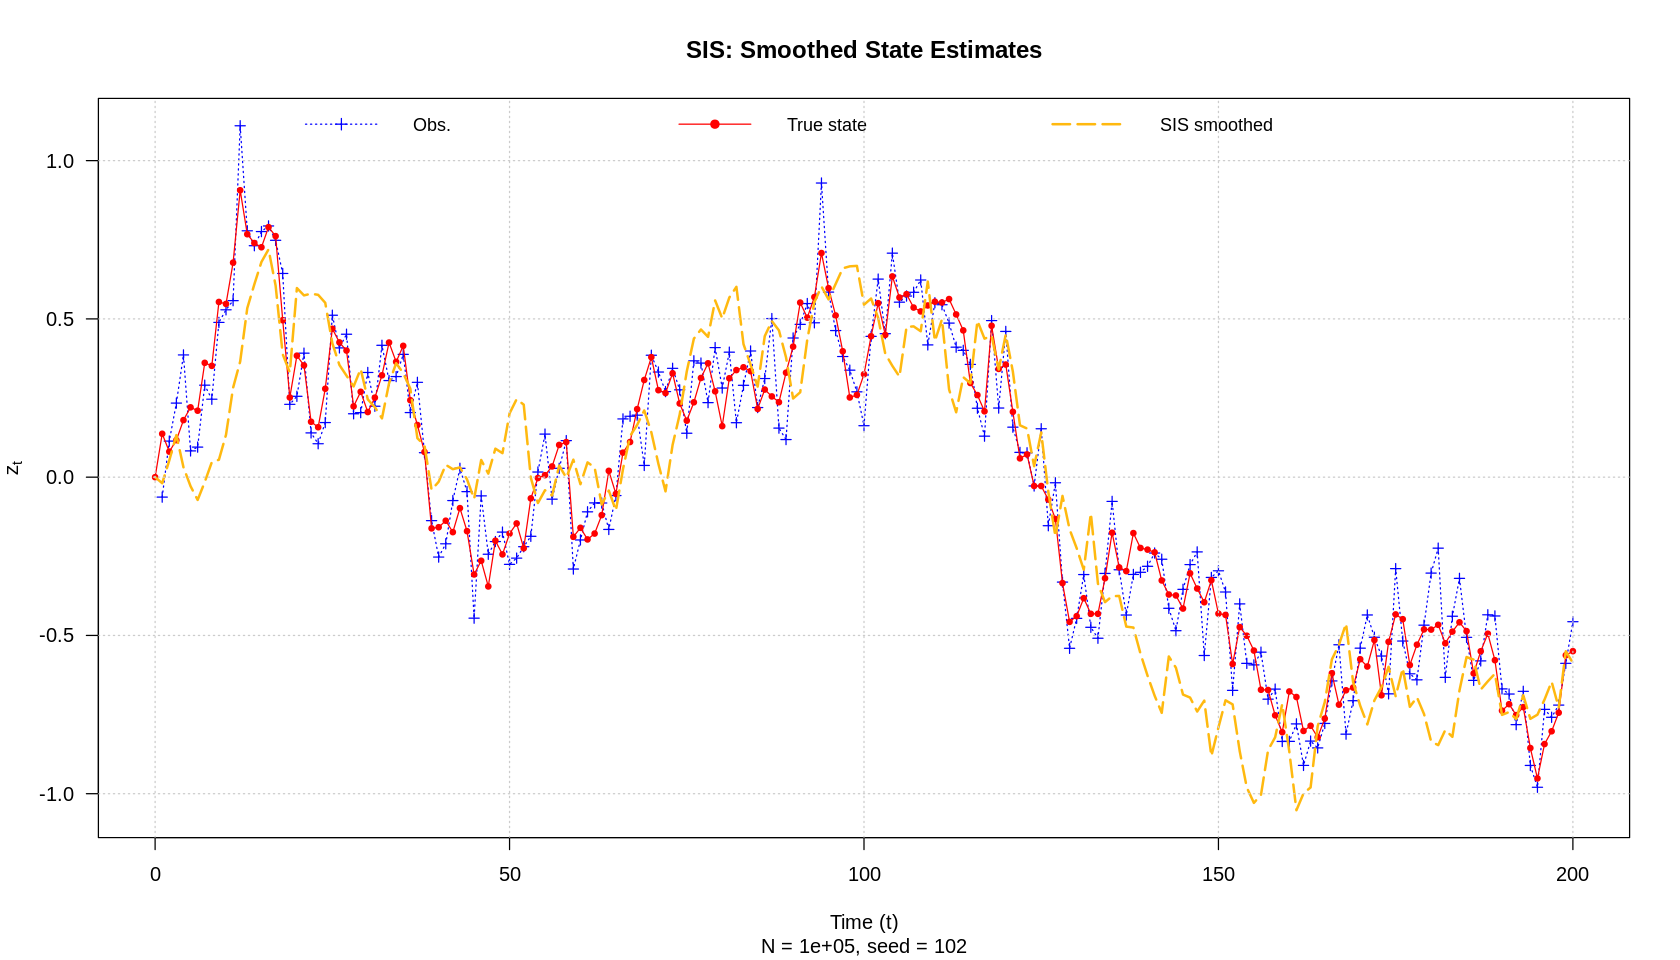

In [88]:
# Plot SIS smoothed states against observations and true states

# Ensure time indices are aligned
obs_time_idx <- 1:time_steps   # for y₁…y_T
time_idx <- 0:time_steps       # for z₀…z_T

plot(
    obs_time_idx,
    obs_y,
    type = "o",         # obs points + lines
    pch = 3,            # open cross
    cex = 0.8,
    col = "blue",
    lty = 3,            # dashed
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, sis_smoothed_states)),
    las  = 1,
    main = "SIS: Smoothed State Estimates",
    sub = paste0(
        "N = ", format(N_particles, big.mark = ","),
        ", seed = 102"
    )
)

# True latent states
points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# SIS smoothed estimates
lines(
    time_idx,
    sis_smoothed_states,
    col = "darkgoldenrod1",
    lwd = 2,
    lty = 5
)

# Legend
legend(
    "top",
    legend = c("Obs.", "True state", "SIS smoothed"),
    pch = c(3, 19, NA),
    col = c("blue", "red", "darkgoldenrod1"),
    lwd = c(1, 1, 2),
    lty = c(3, 1, 5),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

# Grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [89]:
set.seed(102)                    # reproducible particle draw
N_particles <- 100000            # number of particles

# initialize matrix of particle states (rows = particles, cols = t = 0…time_steps)
sis_particle_states <- matrix(
    NA,
    nrow = N_particles,
    ncol = time_steps + 1
)
sis_particle_states[, 1] <- 0      # z₀ = 0 for all particles

# initialize weights
sis_weights <- rep(1, N_particles)

In [90]:
# Propagate and weight particles
for (t in 2:(time_steps + 1)) {
    # 1) Propose via process equation
    sis_particle_states[, t] <- rnorm(
        n = N_particles,
        mean = sis_particle_states[, t - 1],
        sd = process_var_stdev
    )
    # 2) Weight by observation density at yₜ
    sis_weights <- sis_weights * dnorm(
        x = obs_y[t - 1],
        mean = sis_particle_states[, t],
        sd = obs_error_stdev
    )
}

In [91]:
# Normalize weights
sis_weights <- sis_weights / sum(sis_weights)

# Compute SIS smoothed state estimates via weighted average
sis_smoothed_states <- colSums(sis_particle_states * sis_weights)

In [92]:
# Bootstrap filter smoothing
set.seed(338)
bf_particle_states <- matrix(
    NA,
    nrow = N_particles,
    ncol = time_steps + 1
)
bf_particle_states[, 1] <- 0      # z₀ = 0

In [93]:
# Track original-particle IDs to assess diversity
bf_history <- matrix(
    NA,
    nrow = N_particles,
    ncol = time_steps + 1
)
bf_history[, 1] <- seq_len(N_particles)

In [94]:
# Perform bootstrap filtering
for (t in 2:(time_steps + 1)) {
    # 1) Propagate
    bf_particle_states[, t] <- rnorm(
        n = N_particles,
        mean = bf_particle_states[, t - 1],
        sd = process_var_stdev
    )
    # 2) Weight at current time (for resampling)
    bf_weights <- dnorm(
        x = obs_y[t - 1],
        mean = bf_particle_states[, t],
        sd = obs_error_stdev
    )
    # 3) Resample rows according to weights
    resample_idx <- sample(
        seq_len(N_particles),
        N_particles,
        replace = TRUE,
        prob = bf_weights
    )
    # 4) Replace both state rows and history
    bf_particle_states <- bf_particle_states[resample_idx, , drop = FALSE]
    bf_history <- bf_history[resample_idx, , drop = FALSE]
}

In [95]:
# Compute number of unique original particles over time
num_unique <- apply(bf_history, 2, function(x) length(unique(x)))

# Compute BF smoothed state estimates via simple average
bf_smoothed_states <- colMeans(bf_particle_states)

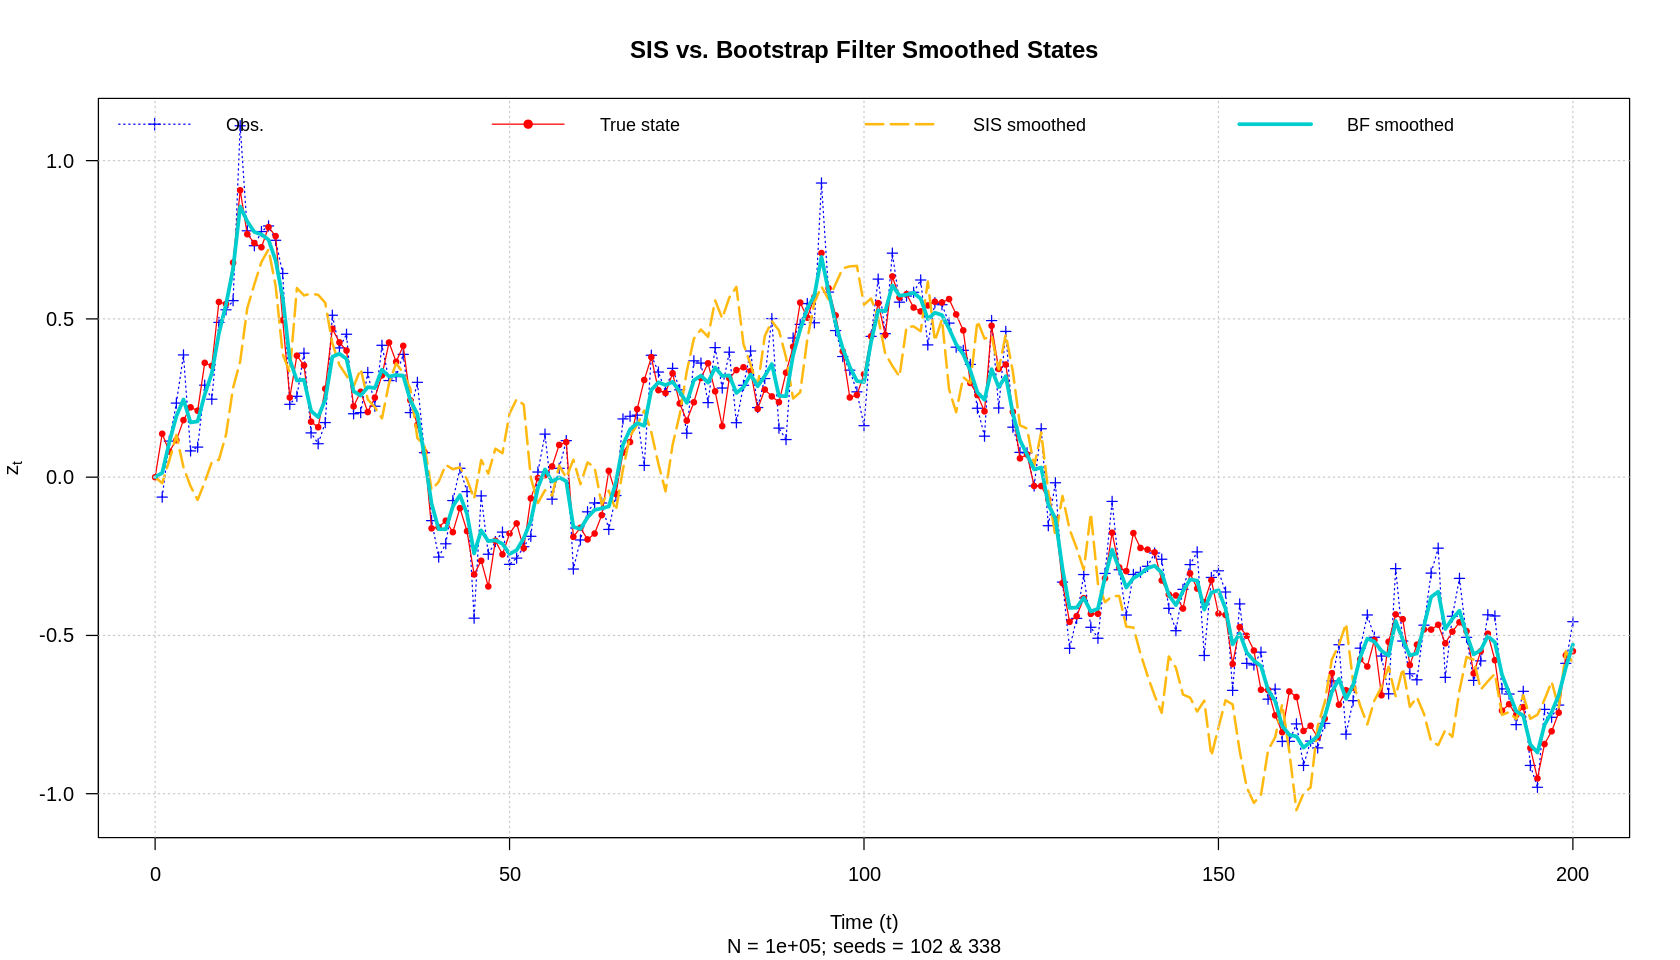

In [96]:
# Plot SIS and BF smoothed states
obs_time_idx <- 1:time_steps
time_idx <- 0:time_steps

plot(
    obs_time_idx,
    obs_y,
    type = "o",
    pch = 3,
    cex = 0.8,
    col = "blue",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, sis_smoothed_states, bf_smoothed_states)),
    las = 1,
    main = "SIS vs. Bootstrap Filter Smoothed States",
    sub = paste0("N = ", format(N_particles, big.mark = ","),
                 "; seeds = 102 & 338")
)

points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

lines(
    time_idx,
    sis_smoothed_states,
    col = "darkgoldenrod1",
    lwd = 2,
    lty = 5
)

lines(
    time_idx,
    bf_smoothed_states,
    col = "cyan3",
    lwd = 3
)

legend(
    "top",
    legend = c("Obs.", "True state", "SIS smoothed", "BF smoothed"),
    pch = c(3, 19, NA, NA),
    col = c("blue", "red", "darkgoldenrod1", "cyan3"),
    lwd = c(1, 1, 2, 3),
    lty = c(3, 1, 5, 1),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

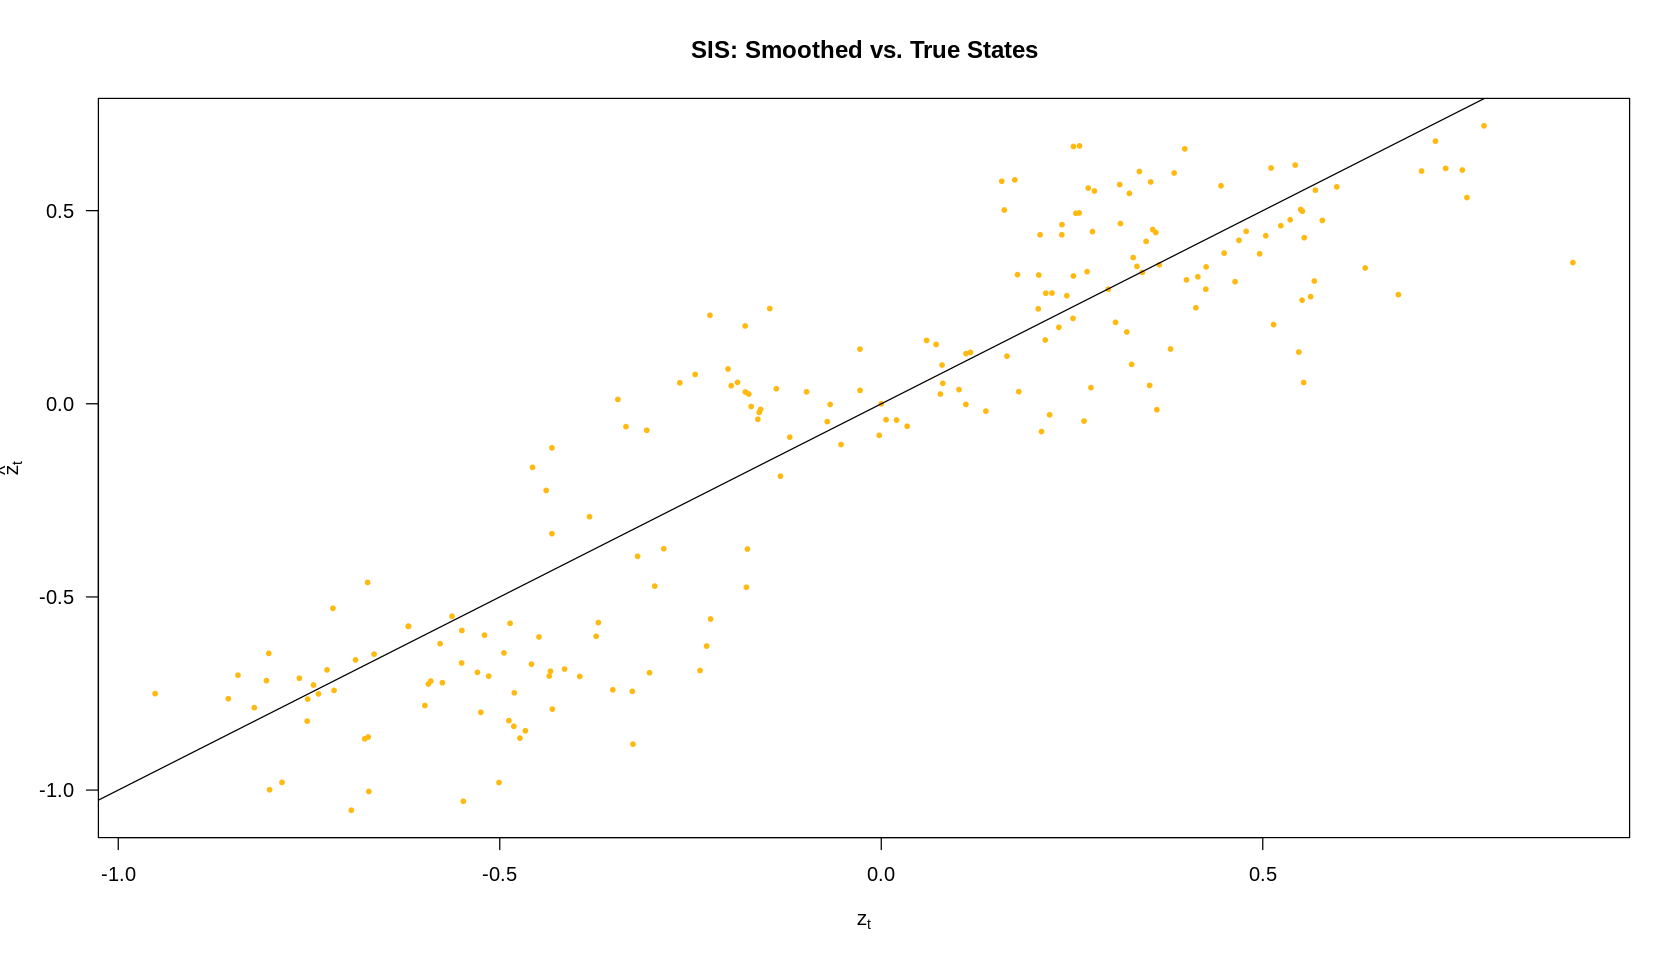

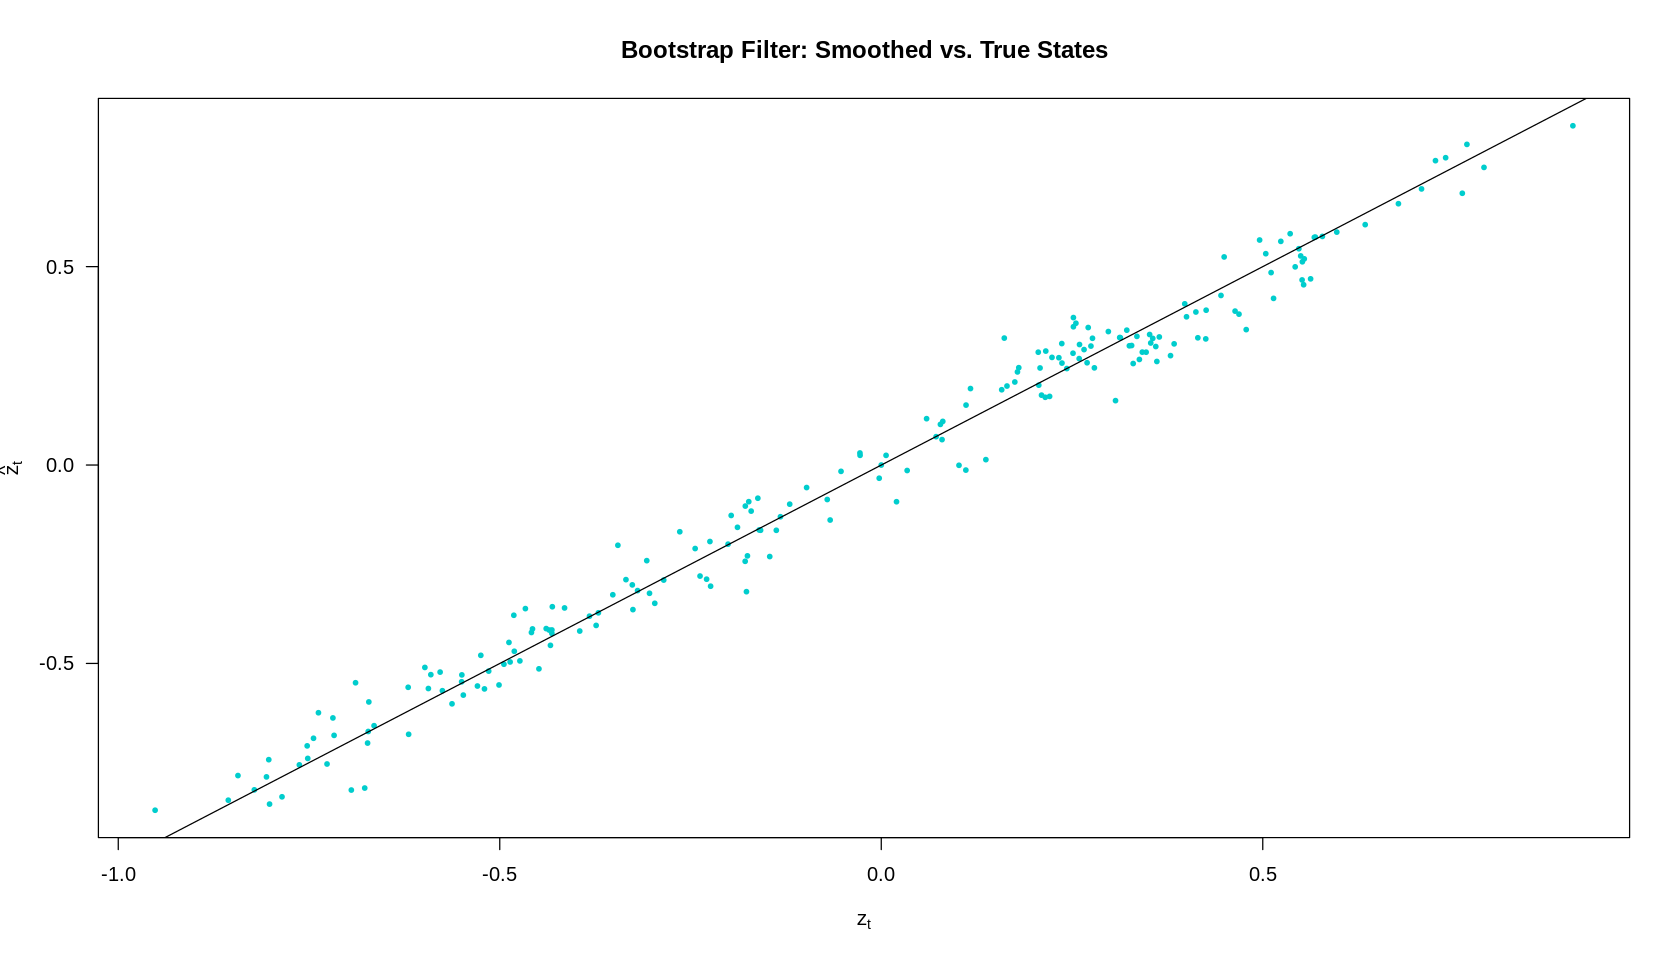

In [97]:
# Scatter: estimated vs true states

# SIS scatter
plot(
    states_z,
    sis_smoothed_states,
    xlab = expression(z[t]),
    ylab = expression(hat(z)[t]),
    main = "SIS: Smoothed vs. True States",
    las = 1,
    pch = 19,
    col = "darkgoldenrod1",
    cex = 0.5
)
abline(0, 1)

# BF scatter
plot(
    states_z,
    bf_smoothed_states,
    xlab = expression(z[t]),
    ylab = expression(hat(z)[t]),
    main = "Bootstrap Filter: Smoothed vs. True States",
    las = 1,
    pch = 19,
    col = "cyan3",
    cex = 0.5
)
abline(0, 1)

# Pomp

In [98]:
# Data frame of time and observations
data_pomp <- data.frame(
    t = 1:time_steps,
    y = obs_y
)

In [99]:
# Build pomp object with C snippets for speed
pomp_obj <- pomp(
    data = data_pomp,
    times = "t",
    t0 = 1,
    rprocess = discrete_time(Csnippet("z = rnorm(z, sdp);")),
    rmeasure = Csnippet("y = rnorm(z, sdo);"),
    dmeasure = Csnippet("lik = dnorm(y, z, sdo, give_log);"),
    rinit = Csnippet("z = 0;"),
    statenames = "z",
    paramnames = c("sdp", "sdo"),
    partrans = parameter_trans(log = c("sdp", "sdo"))
)

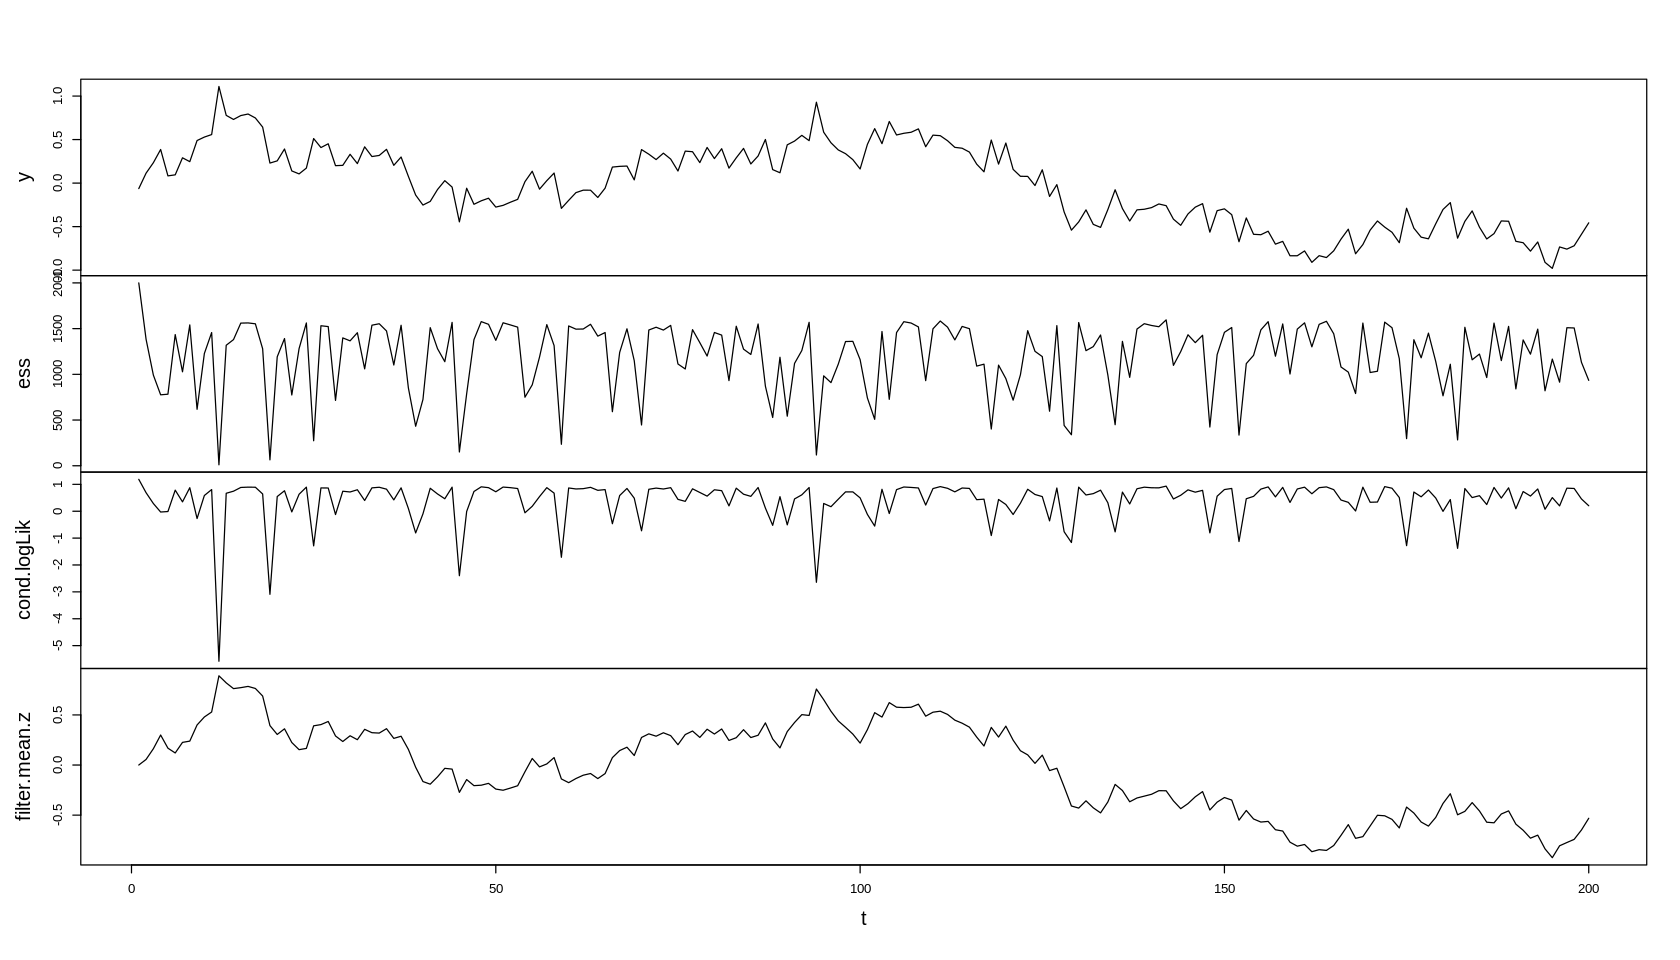

In [100]:
# Single-run particle filter via pomp
pf_obj <- pfilter(
    pomp_obj,
    Np = 2000,
    params = c(sdp = process_var_stdev,
               sdo = obs_error_stdev),
    filter.mean = TRUE
)

# Diagnostic plot of filter
plot(pf_obj)

In [101]:
# Extract filtered state estimates and the log likelihood
filtered_states_pomp <- filter_mean(pf_obj)
pomp_loglik <- logLik(pf_obj)

In [102]:
# Estimate log-likelihood uncertainty via parallel replicates
registerDoParallel()
registerDoRNG(1301370376)

pf_rep <- foreach(
    i = 1:10,
    .combine = c,
    .packages = "pomp"
) %dopar% {
    pfilter(
        pomp_obj,
        Np = 2000,
        params = c(sdp = process_var_stdev,
                   sdo = obs_error_stdev)
    )
}

In [103]:
# Extract log-likelihoods and compute log-mean-exp (with SE)
pf_logliks <- logLik(pf_rep)
pomp_loglik_summary <- logmeanexp(pf_logliks, se = TRUE)

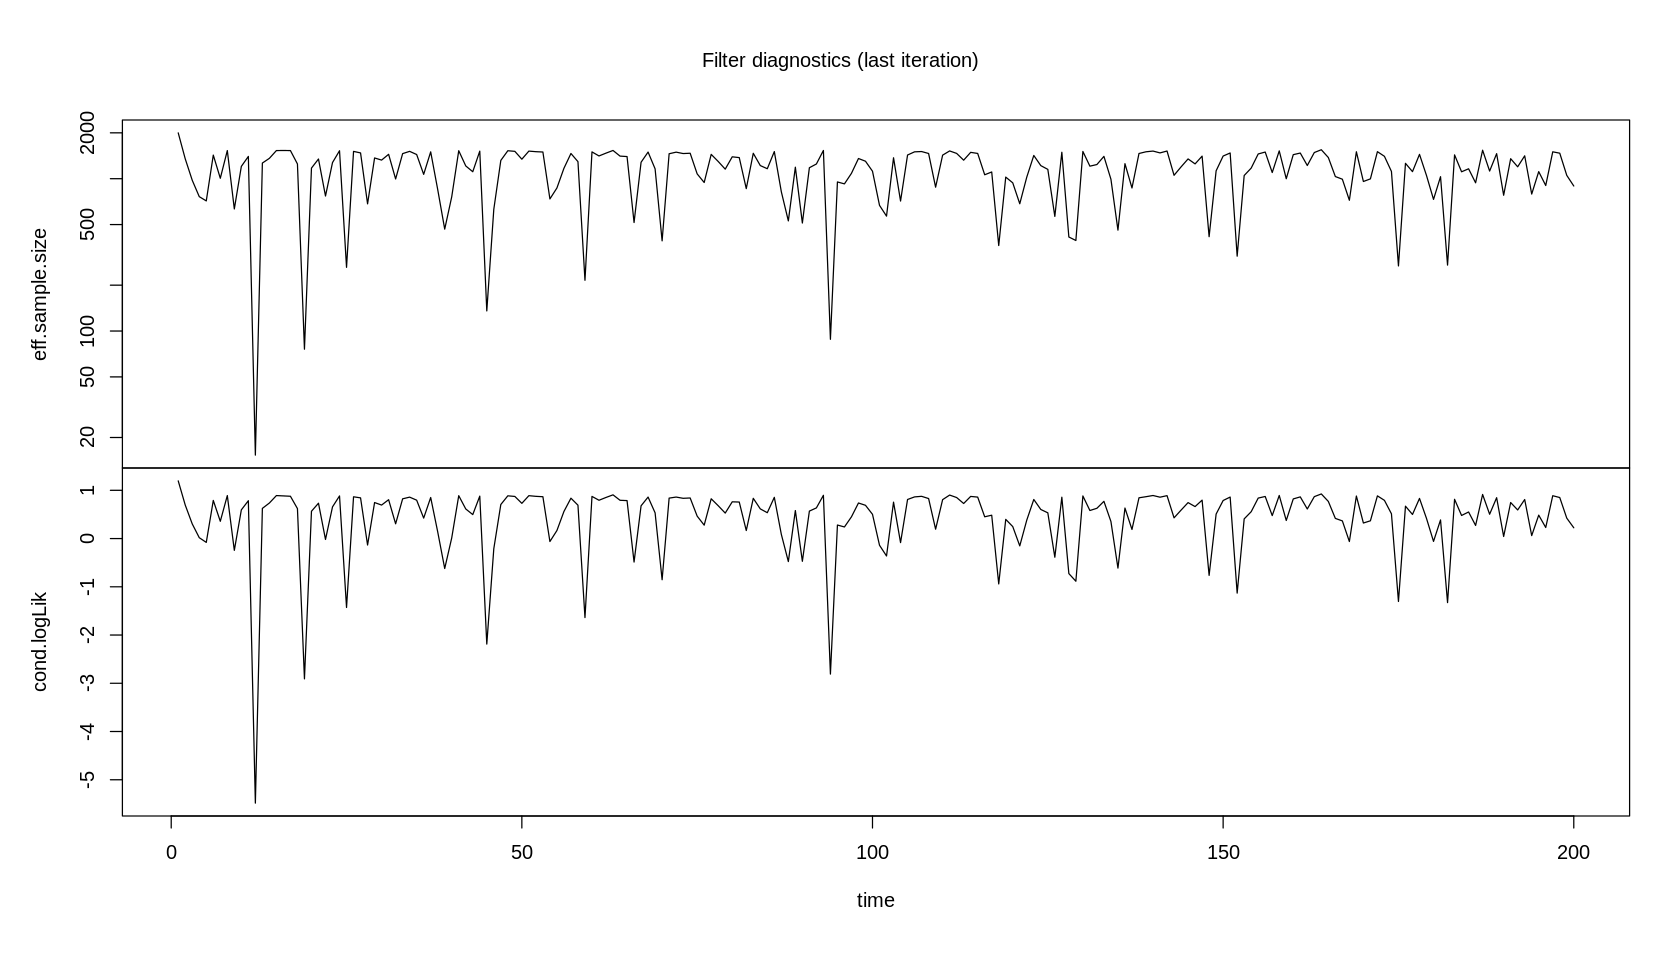

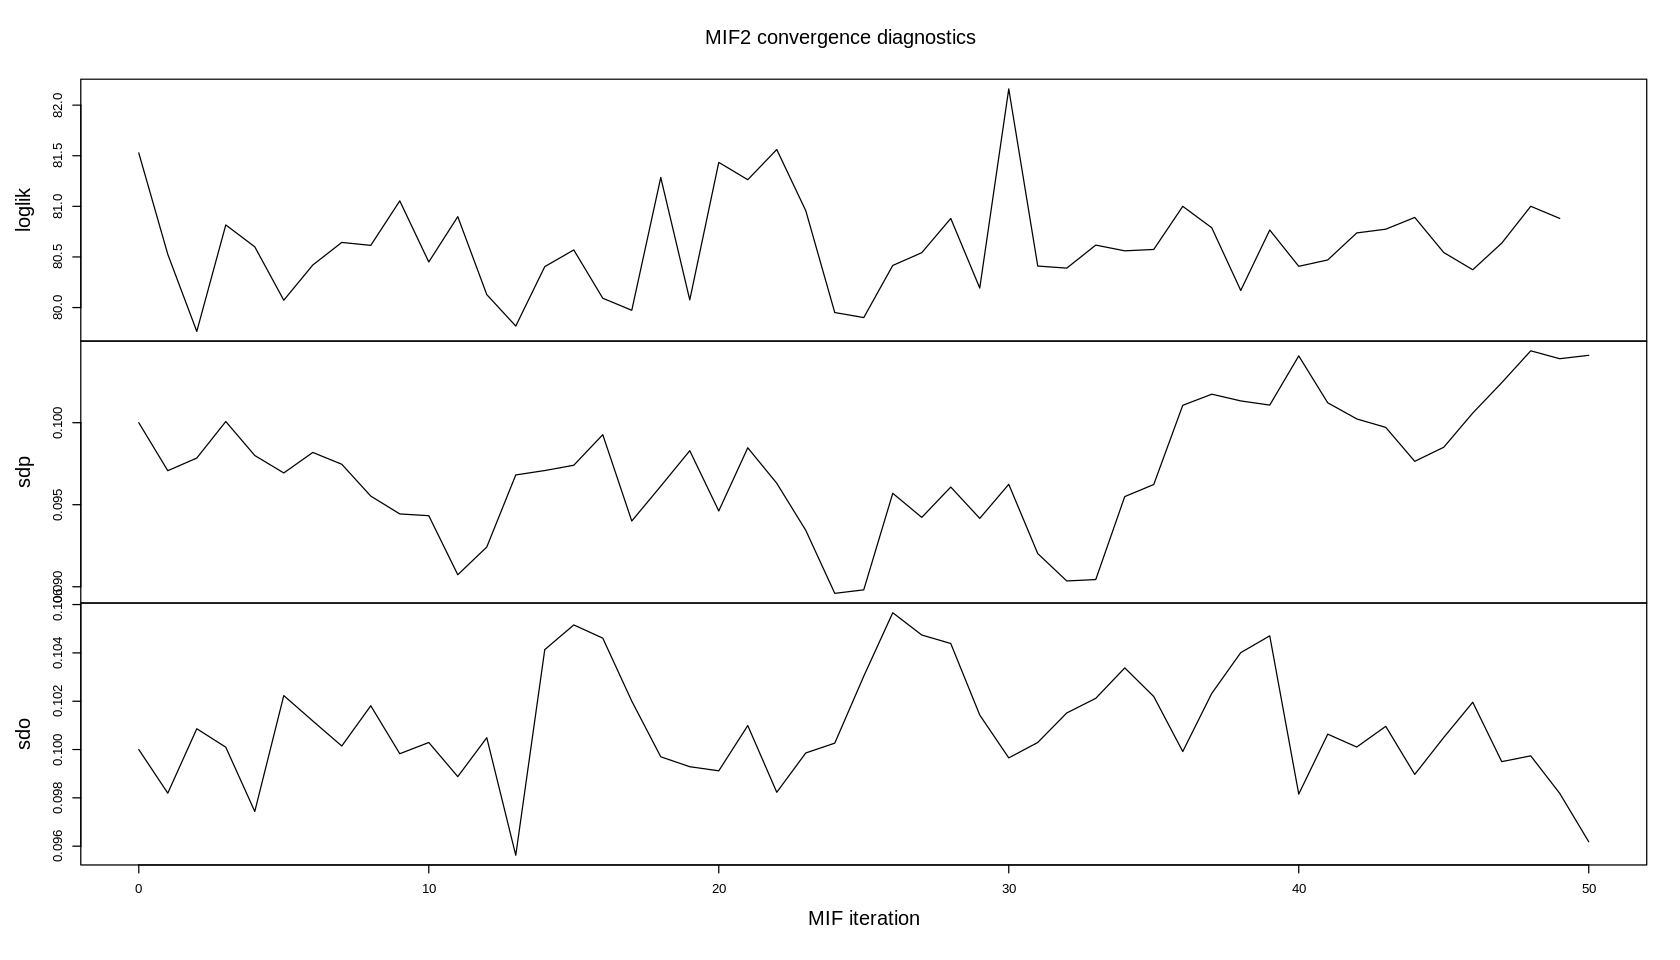

In [104]:
# Iterated filtering (mif2) for parameter estimation
mif_obj <- mif2(
    pomp_obj,
    params = c(sdp = process_var_stdev,
               sdo = obs_error_stdev),
    Nmif = 50,
    Np = 2000,
    rw.sd = rw_sd(sdp = 0.005, sdo = 0.005),
    cooling.fraction.50 = 0.5
)

# Diagnostic trace plot for mif2
plot(mif_obj)

In [105]:
# Point estimates of parameters
pomp_if_estimates <- cbind(
    True = c(sdp = process_var_stdev, sdo = obs_error_stdev),
    Estimated = coef(mif_obj)
)

pomp_if_estimates

True Estimated
sdp 0.1  0.1041049
sdo 0.1  0.0961828

In [106]:
# Multi-start iterated filtering for robustness

# Generate random starting guesses
guesses <- runif_design(
    lower = c(sdp = 0, sdo = 0),
    upper = c(sdp = 1, sdo = 1),
    nseq = 100
)

In [107]:
# Parallel mif2 runs from different starts
mif_rep <- foreach(
    guess = iter(guesses, "row"),
    .combine = c,
    .packages = "pomp",
    .errorhandling = "remove",
    .inorder = FALSE
) %dopar% {
    mif2(mif_obj, params = guess)
}

In [108]:
tmp <- melt(traces(mif_rep))
names(tmp)

[1] "iteration" "name"      "value"     "L1"

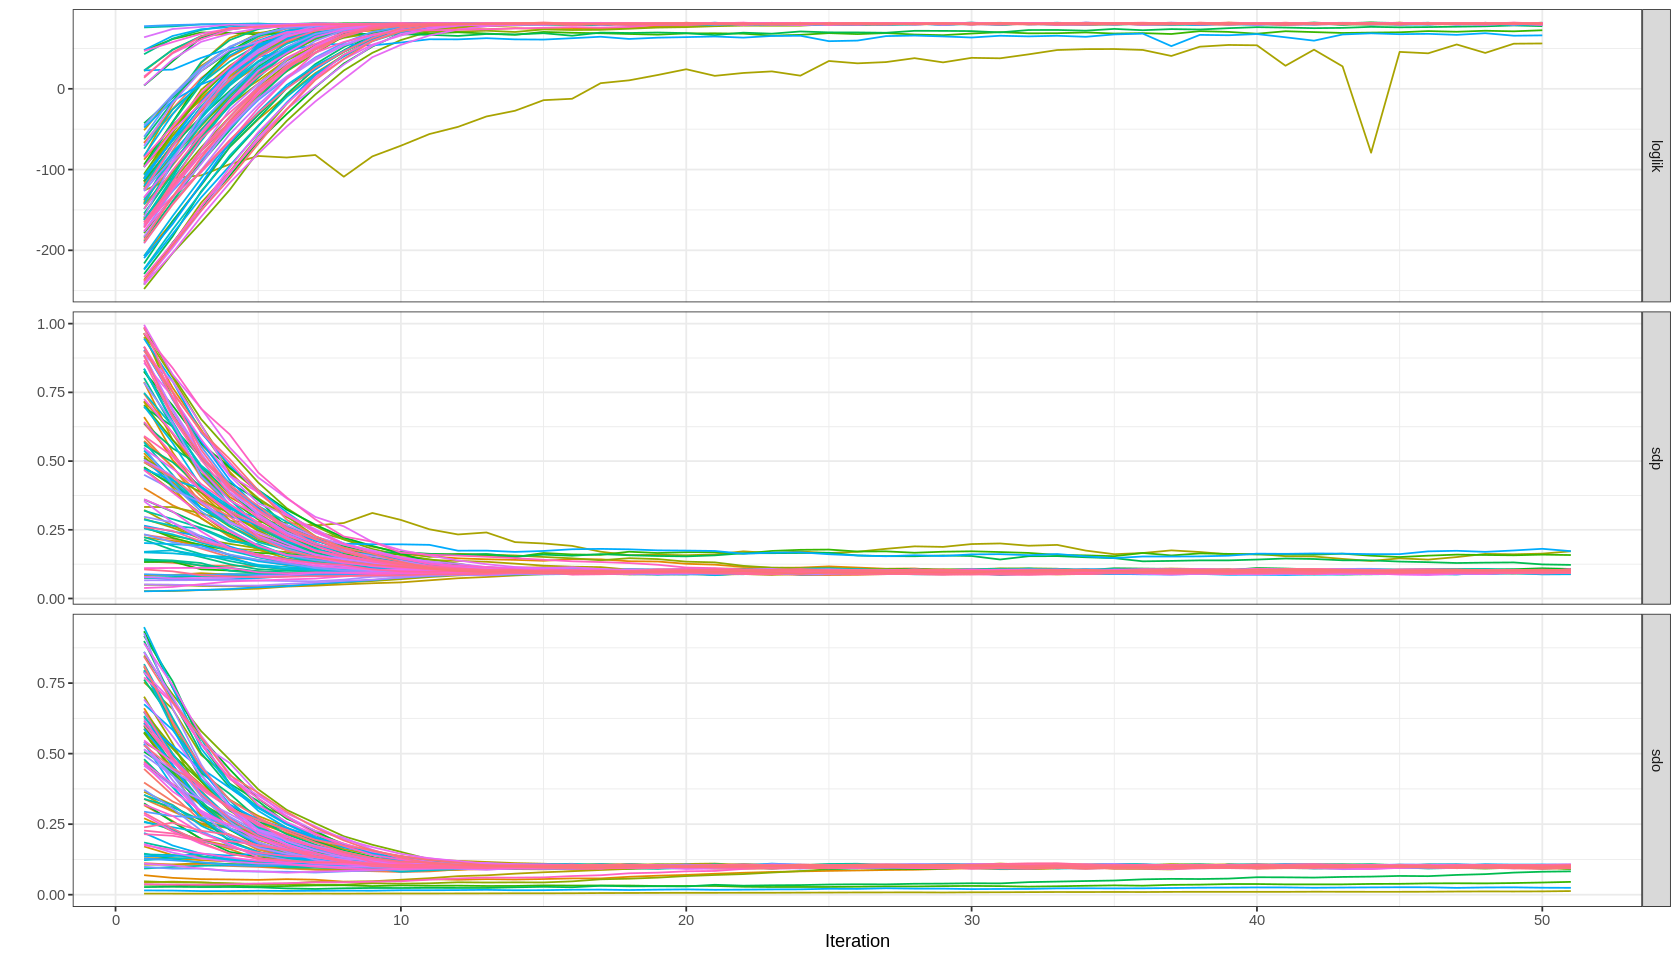

In [109]:
# Trace-plot of all runs
tmp <- melt(traces(mif_rep))

# Rename the columns so that ggplot can find them
names(tmp)[names(tmp) == "L1"] <- "run"
names(tmp)[names(tmp) == "name"] <- "variable"

# Drop the 'nfail' trace
trace_df <- subset(tmp, variable != "nfail")

# Plot iteration vs. value, grouping/coloring by run
ggplot(trace_df,
       aes(x = iteration,
           y = value,
           group = run,
           color = factor(run))) +
  geom_line() +
  facet_wrap(~ variable,
             ncol = 1,
             scales = "free_y",
             strip.position = "right") +
  guides(color = "none") +
  labs(y = "", x = "Iteration") +
  theme_bw()

In [110]:
# Evaluate fixed-parameter likelihood for each mif run
results_mif <- foreach(
  mf = mif_rep,
  .combine = rbind,
  .packages = "pomp",
  .errorhandling = "remove",
  .inorder = FALSE
) %dopar% {
  # Replicate log‐likelihood 10 times
  ll_vals <- replicate(
    10,
    mf %>% pfilter(Np = 2000, filter.mean = FALSE) %>% logLik()
  )
  ll_sum <- logmeanexp(ll_vals, se = TRUE)

  # Assemble one‐row data.frame with proper column names
  data.frame(
    sdp = coef(mf)["sdp"],
    sdo = coef(mf)["sdo"],
    loglik = ll_sum[1],
    loglik.se = ll_sum[2],
    stringsAsFactors = FALSE
  )
}

In [111]:
# Inspect the results
head(results_mif)

sdp        sdo        loglik   loglik.se 
sdp  0.09930165 0.10165661 81.25506 0.14702424
sdp1 0.09382407 0.09668832 80.75554 0.15485098
sdp2 0.09592112 0.09700772 80.93097 0.14522557
sdp3 0.09582476 0.10225343 81.08856 0.10705354
sdp4 0.09637442 0.09912229 81.14260 0.07470656
sdp5 0.09344785 0.10353055 80.97671 0.13698636

In [112]:
# Identify best set of parameters by maximum log-likelihood
best_params <- results_mif[ which.max(results_mif$loglik), , drop = FALSE ]
best_params

sdp       sdo       loglik   loglik.se
sdp16 0.0969307 0.1033292 81.55101 0.3442903

In [113]:
# Build a "truth" row for comparison
truth <- data.frame(
  sdp = process_var_stdev,
  sdo = obs_error_stdev,
  loglik = pomp_loglik_summary[1],
  loglik.se = pomp_loglik_summary[2],
  stringsAsFactors = FALSE
)

# Combine and display
comparison <- rbind(
  Estimated = best_params,
  True = truth
)
comparison

sdp       sdo       loglik   loglik.se
Estimated 0.0969307 0.1033292 81.55101 0.3442903
True      0.1000000 0.1000000 81.26227 0.1553802

# JAGS

In [114]:
# Write the BUGS model as a string
toy_model_jags <- "
model {
  # Transform standard deviations into precisions
  state_prec <- 1 / (sdp * sdp)
  obs_prec <- 1 / (sdo * sdo)

  # Process equation
  # First time step uses known z0
  z[1] ~ dnorm(z0, state_prec)

  # Subsequent time steps
  for (t in 2:TT) {
    z[t] ~ dnorm(z[t-1], state_prec)
  }

  # Observation equation and pointwise log‐likelihoods
  for (t in 1:TT) {
    y[t] ~ dnorm(z[t], obs_prec)
    loglik[t] <- logdensity.norm(y[t], z[t], obs_prec)
  }
}
"

In [115]:
# Bundle data for JAGS
data_jags <- list(
  TT = time_steps,             # number of observations
  y = obs_y,                   # observed y₁…y_T
  sdp = process_var_stdev,     # known process SD
  sdo = obs_error_stdev,       # known observation SD
  z0 = initial_state           # known initial state z₀
)

In [116]:
# Create initial values for multiple chains
nc_chains <- 3
initvals_jags <- vector("list", nc_chains)

for (i in seq_len(nc_chains)) {
  # Simulate an initial latent trajectory for chain i
  zinit <- numeric(time_steps)
  zinit[1] <- rnorm(1, mean = initial_state, sd = process_var_stdev)
  for (t in 2:time_steps) {
    zinit[t] <- rnorm(1, mean = zinit[t-1], sd = process_var_stdev)
  }
  initvals_jags[[i]] <- list(z = zinit)
}

In [117]:
# Set burn‐in and sample sizes
burnin_iters <- 1000
sample_iters <- 10000

# Compile and initialize the JAGS model
jags_mod <- jags.model(
  file = textConnection(toy_model_jags),
  data = data_jags,
  inits = initvals_jags,
  n.chains = nc_chains
)

# Burn‐in
update(jags_mod, n.iter = burnin_iters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 200
   Total graph size: 607

Initializing model



In [118]:
# Draw posterior samples
vars_to_monitor <- c("z", "loglik")
coda_samples <- coda.samples(
  model = jags_mod,
  variable.names = vars_to_monitor,
  n.iter = sample_iters
)

In [119]:
# Extract posterior means of the latent states
# Convert all chains to one matrix
samp_mat <- as.matrix(coda_samples)

# Names of the state columns in the matrix
state_cols <- paste0("z[", 1:time_steps, "]")

# Posterior mean for each z[t]
z_means_jags <- colMeans(samp_mat[, state_cols, drop = FALSE])

In [120]:
# Posterior summaries and credible intervals
summary_jags <- summary(coda_samples[, state_cols])
z_stats <- summary_jags$statistics     # mean, sd, SEs
z_quants <- summary_jags$quantiles     # 2.5%, 50%, 97.5%

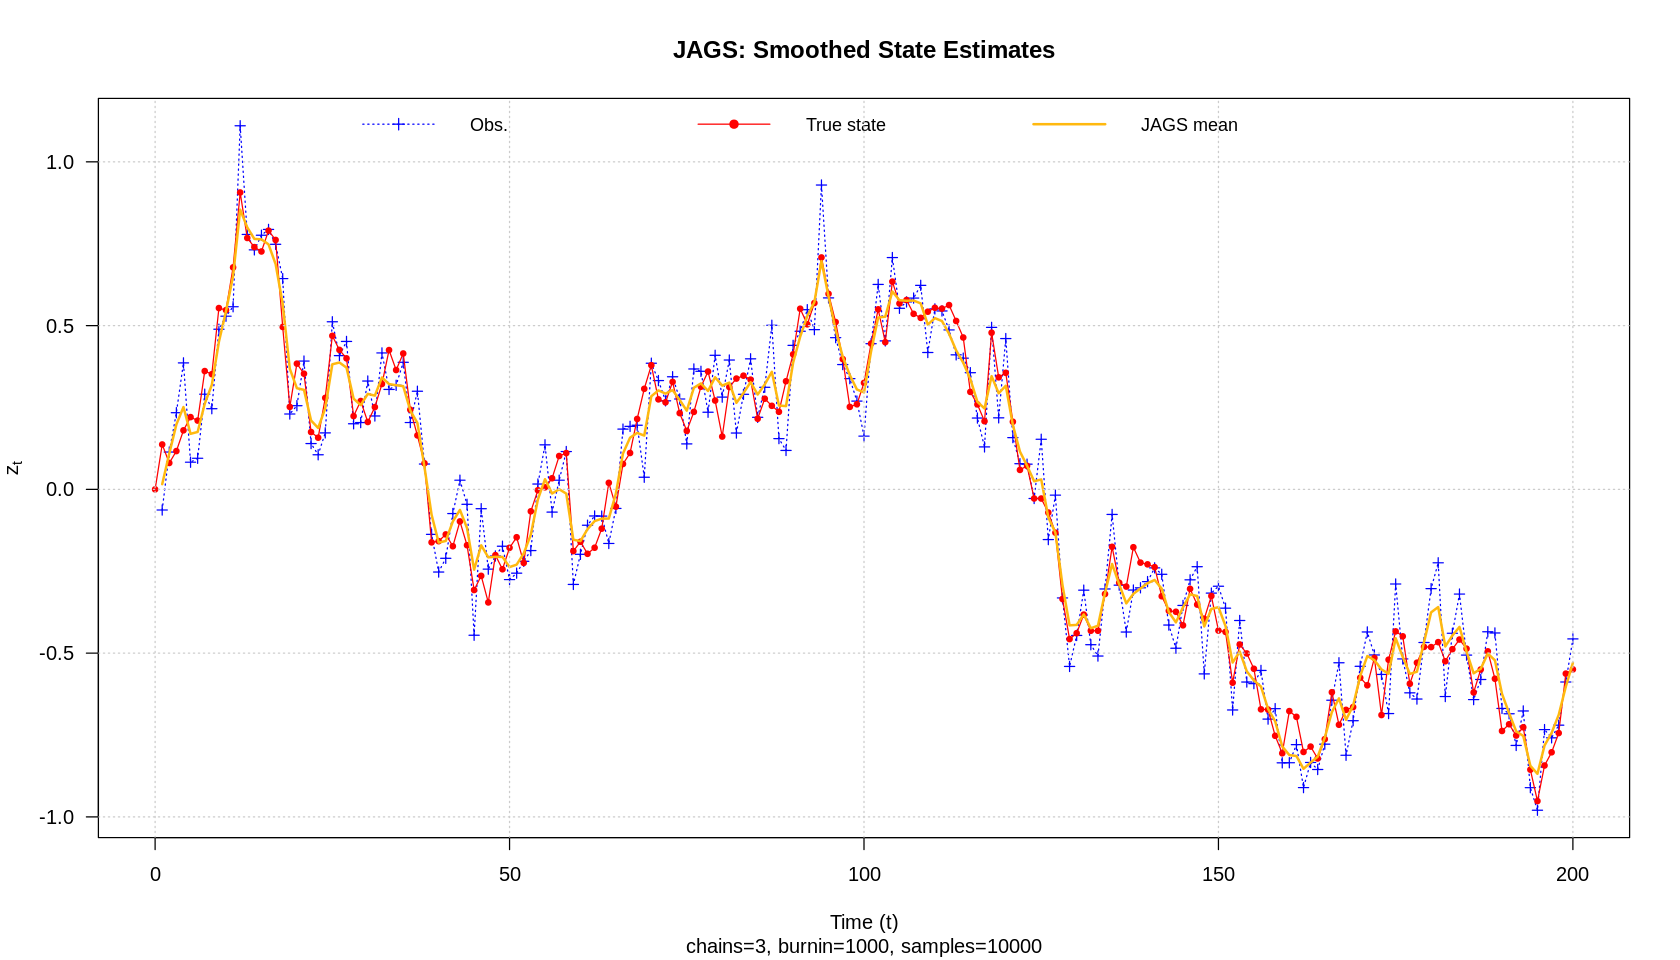

In [121]:
# Plot JAGS‐smoothed states vs. data and truth
time_idx <- 0:time_steps
obs_time_idx <- 1:time_steps

plot(
    obs_time_idx,
    obs_y,
    type = "o",
    pch = 3,
    cex = 0.8,
    col = "blue",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, z_means_jags)),
    las = 1,
    main = "JAGS: Smoothed State Estimates",
    sub = paste0(
        "chains=", nc_chains,
        ", burnin=", burnin_iters,
        ", samples=", sample_iters
    )
)

# Add true latent state
points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Add JAGS‐posterior means (t = 1…T)
lines(
    obs_time_idx,
    z_means_jags,
    lwd = 2,
    col = "darkgoldenrod1"
)

legend(
    "top",
    legend = c("Obs.", "True state", "JAGS mean"),
    pch = c(3, 19, NA),
    col = c("blue", "red", "darkgoldenrod1"),
    lty = c(3, 1, 1),
    lwd = c(1, 1, 2),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [122]:
# Write the BUGS model as a string
toy2p_jags <- "
model {
  # Priors on standard deviations
  sdp ~ dunif(sdp.hyper.a, sdp.hyper.b)
  sdo ~ dunif(sdo.hyper.a, sdo.hyper.b)

  # Convert to precisions
  state_prec <- 1 / (sdp * sdp)
  obs_prec <- 1 / (sdo * sdo)

  # Process equation
  z[1] ~ dnorm(z0, state_prec)
  for (t in 2:TT) {
    z[t] ~ dnorm(z[t-1], state_prec)
  }

  # Observation equation + pointwise log‐likelihood
  for (t in 1:TT) {
    y[t] ~ dnorm(z[t], obs_prec)
    loglik[t] <- logdensity.norm(y[t], z[t], obs_prec)
  }
}
"

In [123]:
# Bundle data for JAGS
data2p_jags <- list(
    TT = time_steps,
    y = obs_y,
    sdp.hyper.a = 0.01,
    sdp.hyper.b = 10,
    sdo.hyper.a = 0.01,
    sdo.hyper.b = 10,
    z0 = initial_state
)

In [124]:
# Create initial values for nc_chains
nc_chains <- 3
initvals2p_jags <- vector("list", nc_chains)

for (i in seq_len(nc_chains)) {
  # Random start for sdp and sdo
  sdp_init <- runif(1, min = data2p_jags$sdp.hyper.a,
                    max = data2p_jags$sdp.hyper.b)
  sdo_init <- runif(1, min = data2p_jags$sdo.hyper.a,
                    max = data2p_jags$sdo.hyper.b)

  # Simulate an initial z path
  zinit <- numeric(time_steps)
  zinit[1] <- rnorm(1, mean = initial_state, sd = sdp_init)
  for (t in 2:time_steps) {
    zinit[t] <- rnorm(1, mean = zinit[t-1], sd = sdp_init)
  }

  initvals2p_jags[[i]] <- list(
    sdp = sdp_init,
    sdo = sdo_init,
    z = zinit
  )
}

In [125]:
# Burn-in and sample sizes
burnin_iters <- 1000
sample_iters <- 10000

# Compile and initialize the JAGS model
jags_mod2p <- jags.model(
    file = textConnection(toy2p_jags),
    data = data2p_jags,
    inits = initvals2p_jags,
    n.chains = nc_chains
)
update(jags_mod2p, n.iter = burnin_iters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 202
   Total graph size: 613

Initializing model



In [126]:
# Draw posterior samples for states, sdp, sdo, and log‐likelihoods
vars2p <- c("sdp", "sdo", "z", "loglik")
coda_samples2p <- coda.samples(
    model = jags_mod2p,
    variable.names = vars2p,
    n.iter = sample_iters
)

In [127]:
# Extract posterior means of the states
samp_mat2p <- as.matrix(coda_samples2p)
state_cols2p <- paste0("z[", 1:time_steps, "]")
z_stats2p <- summary(coda_samples2p[, state_cols2p ])$statistics
z_means2p <- z_stats2p[, "Mean"]

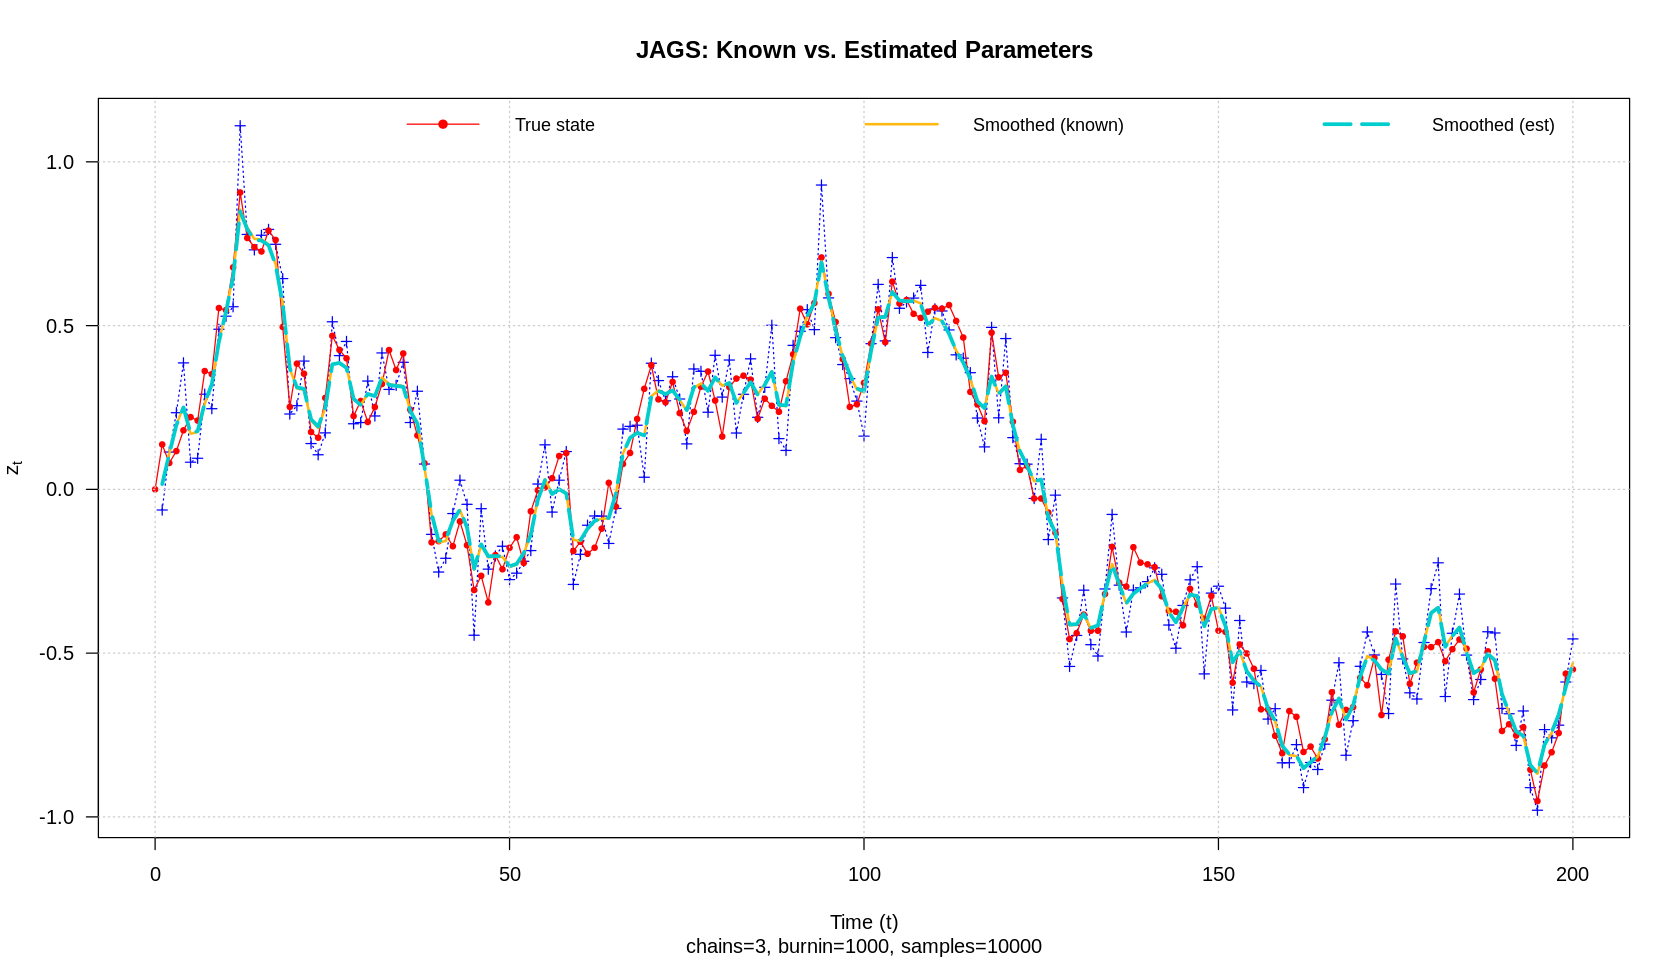

In [128]:
# Plot comparison: known-param vs. estimated-param smoothing
obs_time_idx <- 1:time_steps
time_idx_all <- 0:time_steps
z_means_known_jags <- z_means_jags
z_means_est_jags <- z_means2p

plot(
    obs_time_idx,
    obs_y,
    type = "o",
    pch = 3,
    cex = 0.8,
    col = "blue",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, z_means_known_jags, z_means_est_jags)),
    las = 1,
    main = "JAGS: Known vs. Estimated Parameters",
    sub = paste0("chains=", nc_chains,
                 ", burnin=", burnin_iters,
                 ", samples=", sample_iters)
)

# True latent state
points(
    time_idx_all,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Smoothing with known params
lines(
    obs_time_idx,
    z_means_known_jags,
    col = "darkgoldenrod1",
    lwd = 2
)

# Smoothing with estimated params
lines(
    obs_time_idx,
    z_means_est_jags,
    col = "cyan3",
    lty = 5,
    lwd = 3
)

# Legend
legend(
    "top",
    legend = c("Obs.", "True state", "Smoothed (known)", "Smoothed (est)"),
    pch = c(3, 19, NA, NA),
    col = c("blue", "red", "darkgoldenrod1", "cyan3"),
    lwd = c(1, 1, 2, 3),
    lty = c(3, 1, 1, 5),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

# Grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [129]:
# Summarize posterior for sdp and sdo
param_stats2p <- summary(coda_samples2p[, c("sdp", "sdo")])$statistics
param_stats2p

Mean       SD         Naive SE     Time-series SE
sdp 0.09974443 0.01223317 7.062824e-05 0.0003045577  
sdo 0.10174359 0.01062167 6.132422e-05 0.0002469955

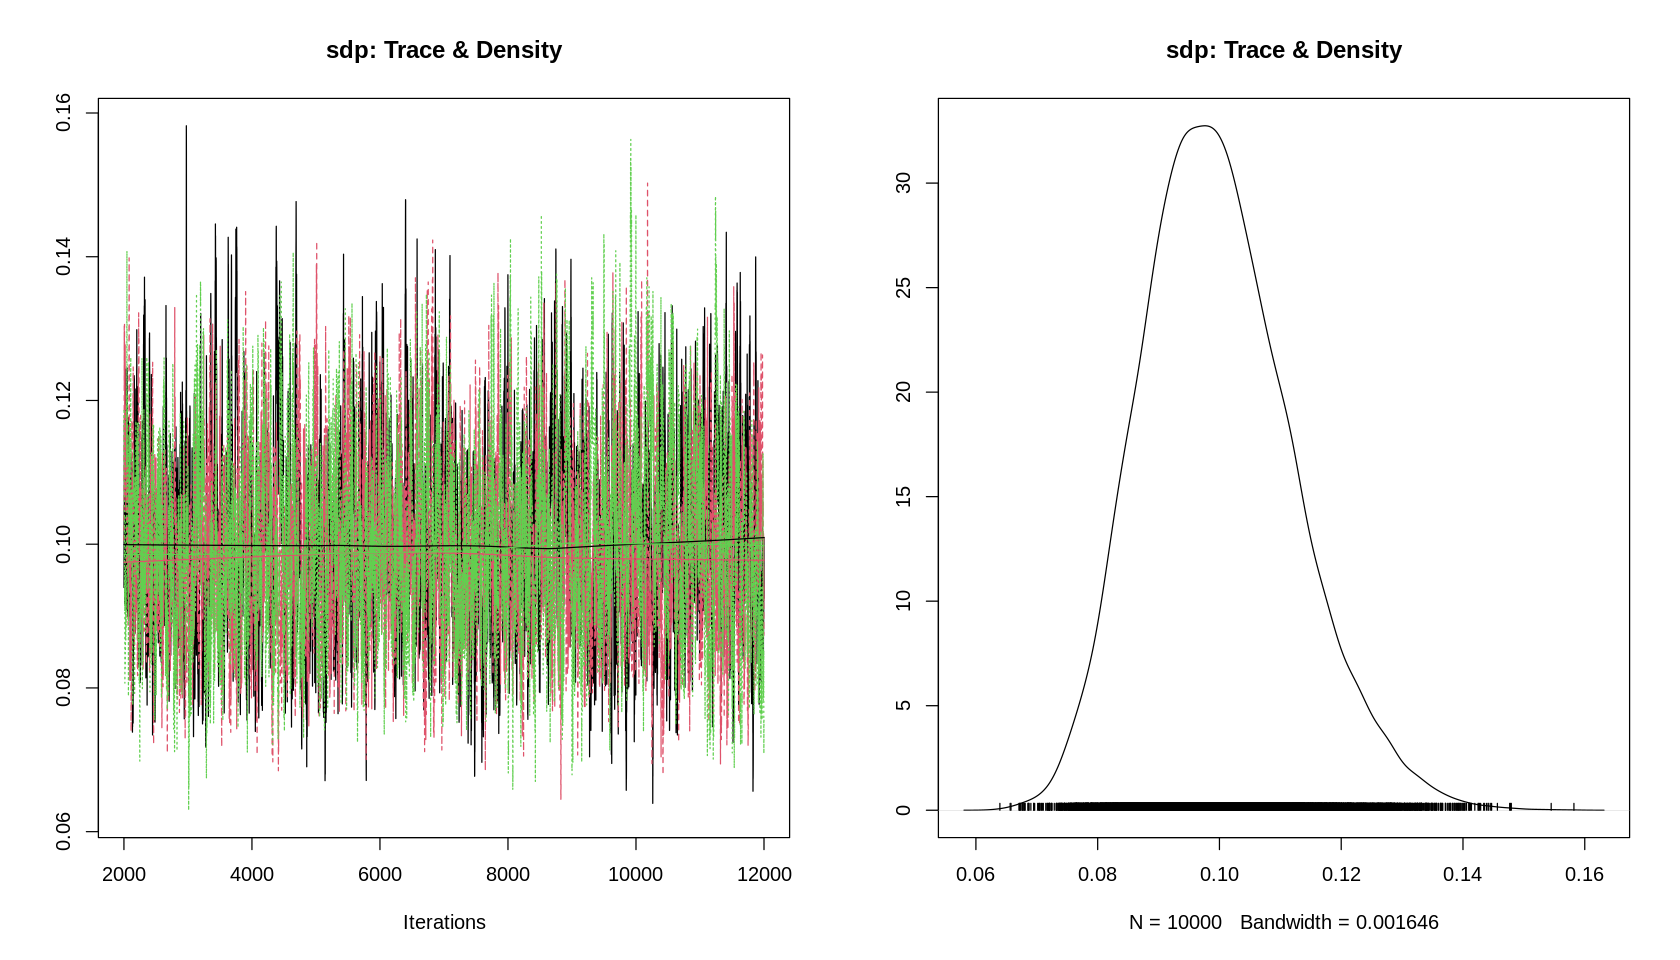

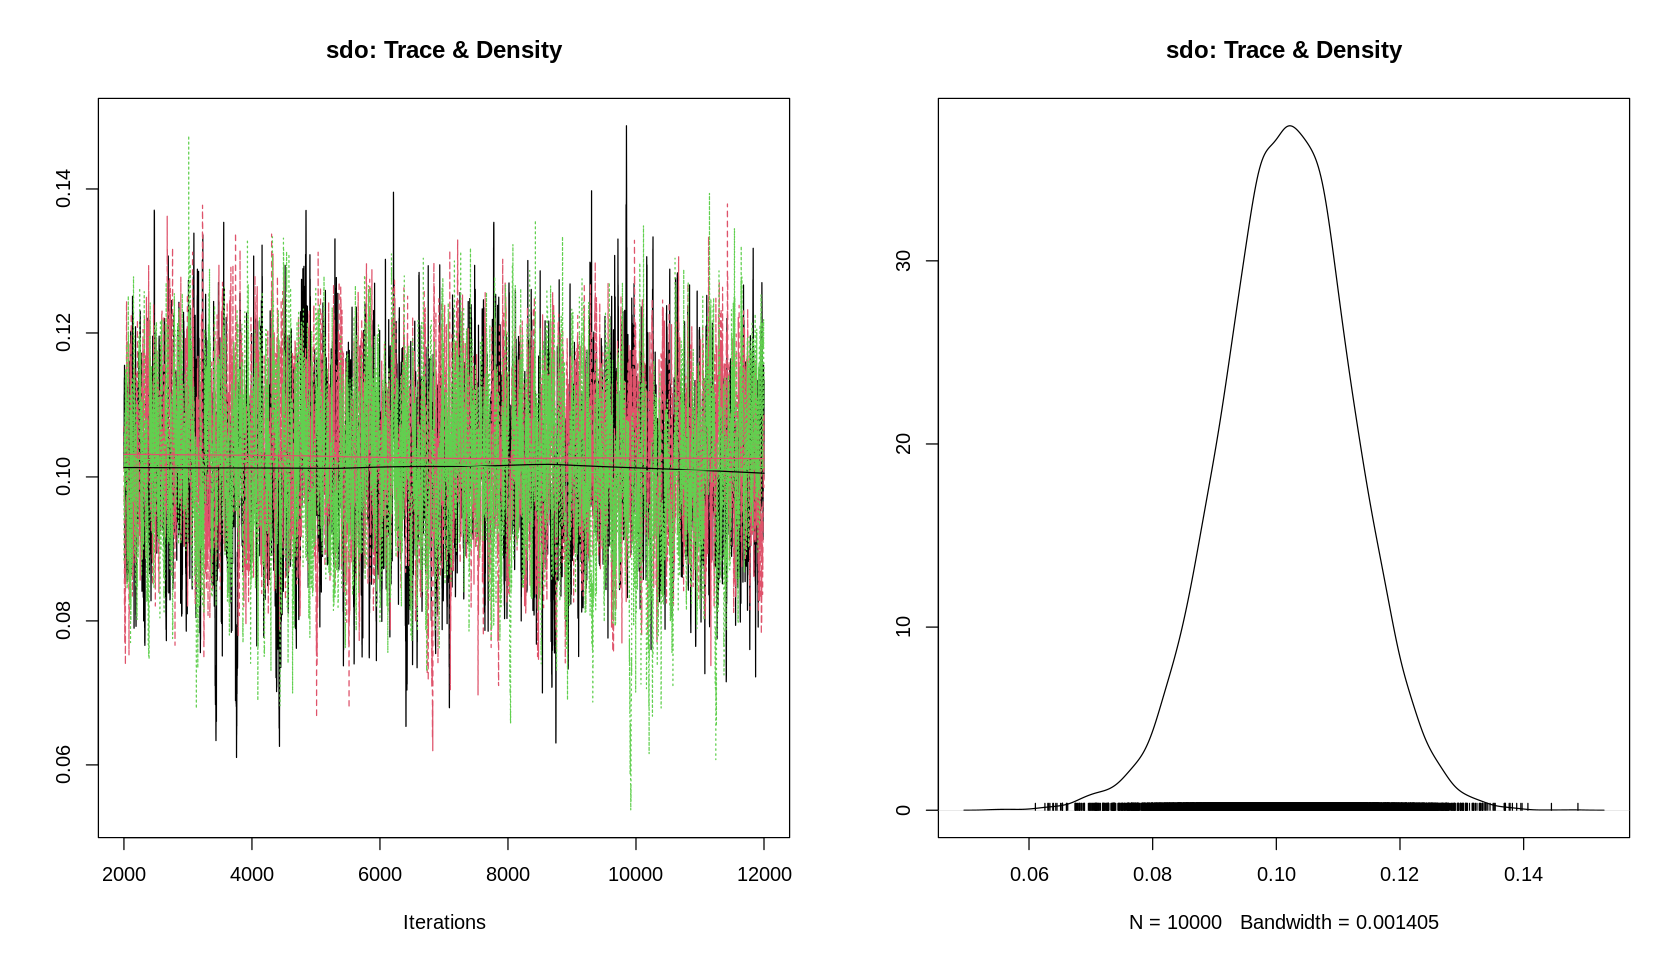

In [130]:
# Trace and density plots for sdp and sdo
post_sdp2p <- coda_samples2p[, "sdp"]
post_sdo2p <- coda_samples2p[, "sdo"]

plot(post_sdp2p, main = "sdp: Trace & Density")
plot(post_sdo2p, main = "sdo: Trace & Density")

In [131]:
# Convergence diagnostics (Gelman–Rubin)
gelman.diag(post_sdp2p)
cat("\n")
gelman.diag(post_sdo2p)

Potential scale reduction factors:

     Point est. Upper C.I.
[1,]       1.01       1.02


Potential scale reduction factors:

     Point est. Upper C.I.
[1,]       1.01       1.02


In [132]:
# Extract pointwise log-likelihood arrays

# Known-parameter JAGS run (coda_samples)
pll0p_jags <- as.array(
  coda_samples[, paste0("loglik[", 1:time_steps, "]")]
)

# Re-order to iterations × chains × observations
pll0p_jags <- aperm(pll0p_jags, c(1, 3, 2))

# Check dimensions: should be sample_iters × nc_chains × time_steps
stopifnot(all(dim(pll0p_jags) == c(sample_iters, nc_chains, time_steps)))

# Estimated-parameter JAGS run (coda_samples2p)
pll2p_jags <- as.array(
  coda_samples2p[, paste0("loglik[", 1:time_steps, "]")]
)
pll2p_jags <- aperm(pll2p_jags, c(1, 3, 2))
stopifnot(all(dim(pll2p_jags) == c(sample_iters, nc_chains, time_steps)))

In [133]:
# Compute WAIC for each model
waic_0p_jags <- waic(pll0p_jags)

# Warning about high p_waic values may appear
waic_2p_jags <- waic(pll2p_jags)

Warning message:
“
52 (26.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”
Warning message:
“
54 (27.0%) p_waic estimates greater than 0.4. We recommend trying loo instead.”


In [134]:
# Compare models by WAIC (elpd difference)
waic_comparison <- loo_compare(waic_2p_jags, waic_0p_jags)
print(waic_comparison)

       elpd_diff se_diff
model2  0.0       0.0   
model1 -1.2       0.3   


# Nimble

In [135]:
# Install nimble into default environment to avoid issues linking from /My Drive/R_libs
.libPaths(c(.Library, .libPaths()))
install.packages("nimble", lib = .Library)
library(nimble)
.libPaths(c("/content/drive/My Drive/R_libs", .Library))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

nimble version 1.3.0 is loaded.
For more information on NIMBLE and a User Manual,
please visit https://R-nimble.org.

Note for advanced users who have written their own MCMC samplers:
  As of version 0.13.0, NIMBLE's protocol for handling posterior
  predictive nodes has changed in a way that could affect user-defined
  samplers in some situations. Please see Section 15.5.1 of the User Manual.


Attaching package: ‘nimble’


The following object is masked from ‘package:pracma’:

    logit


The following objects are masked from ‘package:pomp’:

    expit, logit, simulate


The following object is masked from ‘package:mvtnorm’:

    logdet


The following objects are masked from ‘package:lava’:

    expit, logit


The following objects are masked from ‘package:hash’:

    values, values<-


The following object is masked from ‘package:stats’:

    simulate


The following object is masked from ‘package:base

In [136]:
# Define the model in nimbleCode
toy2p_nimble <- nimbleCode({
    # Priors on SDs
    sdp ~ dunif(1e-4, 1)
    sdo ~ dunif(1e-4, 1)

    # Process and observation equations
    z[1] ~ dnorm(z0, sd = sdp)
    y[1] ~ dnorm(z[1], sd = sdo)
    for (i in 2:TT) {
        z[i] ~ dnorm(z[i-1], sd = sdp)
        y[i] ~ dnorm(z[i], sd = sdo)
    }
})

In [137]:
# Bundle data
data_nimble <- list(
    y = obs_y
)

# Initial values for chains
init_nimble <- list(
    sdp = process_var_stdev,
    sdo = obs_error_stdev
)

# Constants (fixed values)
const_nimble <- list(
    TT = time_steps,
    z0 = 0
)

In [138]:
# Build and compile the nimble model
mdl_nimble <- nimbleModel(
    code = toy2p_nimble,
    data = data_nimble,
    constants = const_nimble,
    inits = init_nimble,
    check = FALSE
)

cpm_nimble <- compileNimble(
    mdl_nimble,
    showCompilerOutput = TRUE
)

Defining model

Building model

Setting data and initial values

Running calculate on model
  [Note] Any error reports that follow may simply reflect missing values in model variables.

Checking model sizes and dimensions

  [Note] This model is not fully initialized. This is not an error.
         To see which variables are not initialized, use model$initializeInfo().
         For more information on model initialization, see help(modelInitialization).

Compiling
  [Note] This may take a minute.
  [Note] On some systems there may be some compiler warnings that can be safely ignored.



g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -DR_NO_REMAP   -DEIGEN_MPL2_ONLY=1 -I"/usr/lib/R/library/nimble/include" -Wno-misleading-indentation -Wno-ignored-attributes -Wno-deprecated-declarations      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-TYDrW1/r-base-4.5.0=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c dynamicRegistrations_04_25_08_09_16.cpp -o dynamicRegistrations_04_25_08_09_16.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o dynamicRegistrations_04_25_08_09_16.so dynamicRegistrations_04_25_08_09_16.o -L/usr/lib/R/library/nimble/CppCode -lnimble -Wl,-rpath /usr/lib/R/library/nimble/CppCode -llapack -lblas -L/usr/lib/R/lib -lR
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -DR_NO_REMAP   -DEIGEN_MPL2_ONLY=1 -I"/usr/lib/R/library/nimble/include" -Wno-misleading-indentation -Wn

In [139]:
# Print C++ errors
printErrors()

No error file found.

In [140]:
# Configure the MCMC sampler
conf_nimble <- configureMCMC(mdl_nimble, print = FALSE)
conf_nimble$addMonitors(c("sdp", "sdo", "z"))

thin = 1: sdo, sdp, z


In [141]:
# Build and compile the MCMC function
mcmc_nimble <- buildMCMC(conf_nimble)
cmcmc_nimble <- compileNimble(
    mcmc_nimble,
    project = mdl_nimble,
    resetFunctions = TRUE
)

Compiling
  [Note] This may take a minute.
  [Note] Use 'showCompilerOutput = TRUE' to see C++ compilation details.



In [142]:
# Run MCMC (2 chains, 60k iters with 10k burn-in)
set.seed(231)
nimble_out <- runMCMC(
    cmcmc_nimble,
    nchains = 2,
    niter = 60000,
    nburnin = 10000
)

running chain 1...



|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


running chain 2...



|-------------|-------------|-------------|-------------|
|-------------------------------------------------------|


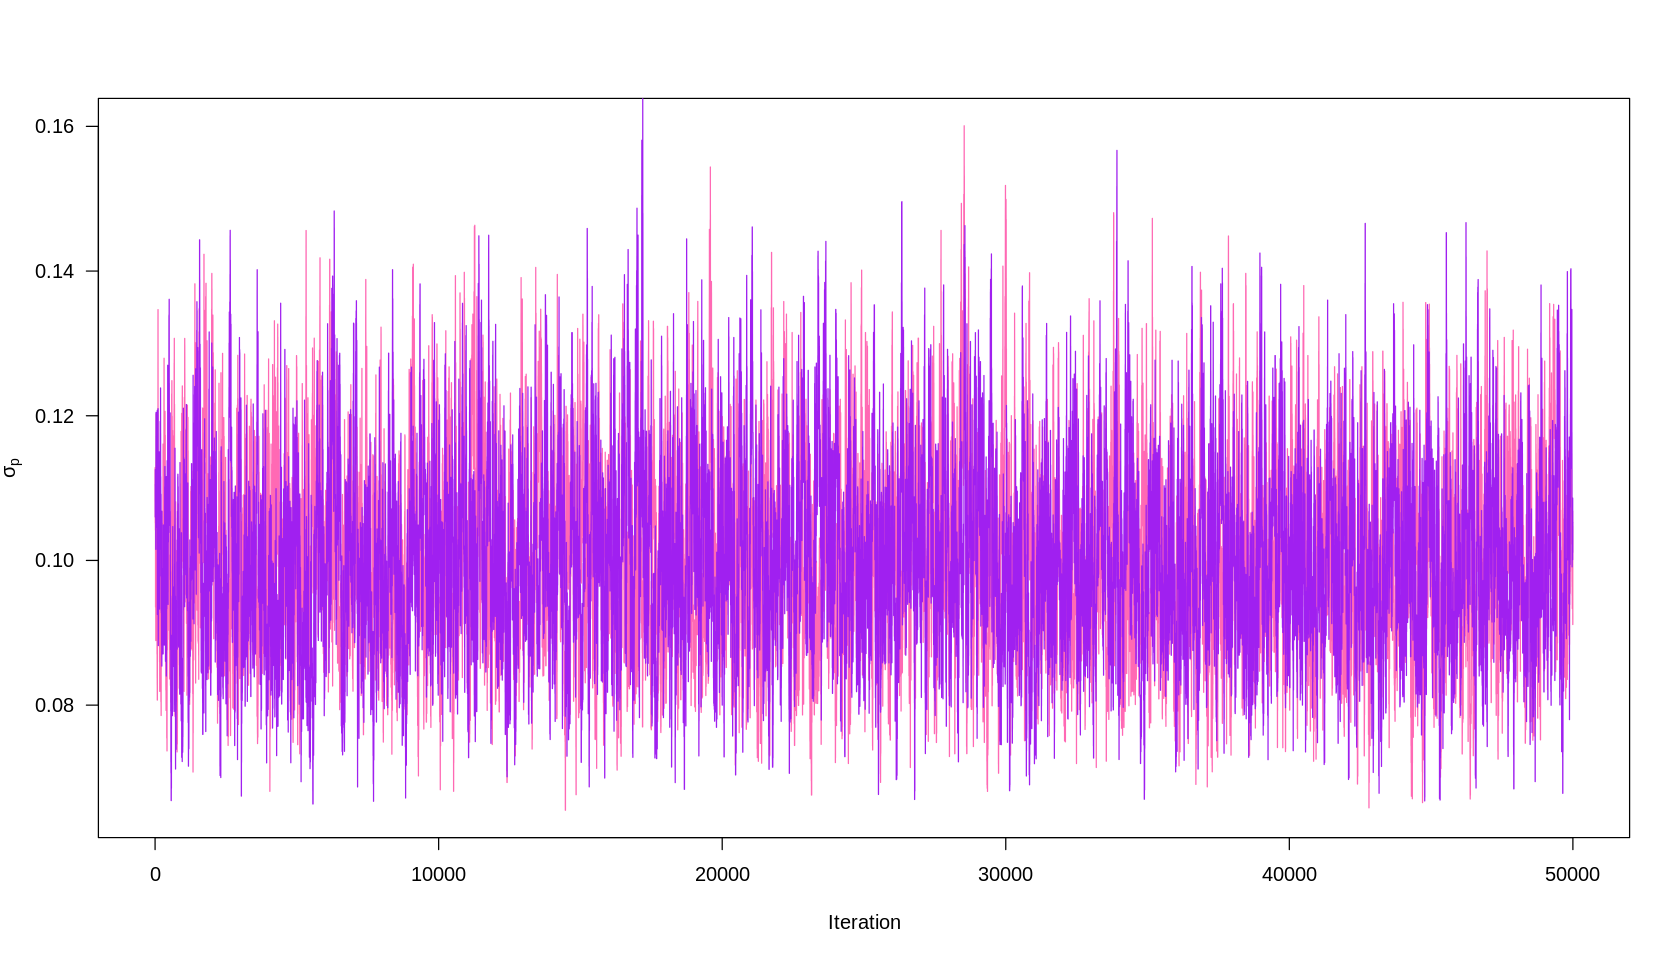

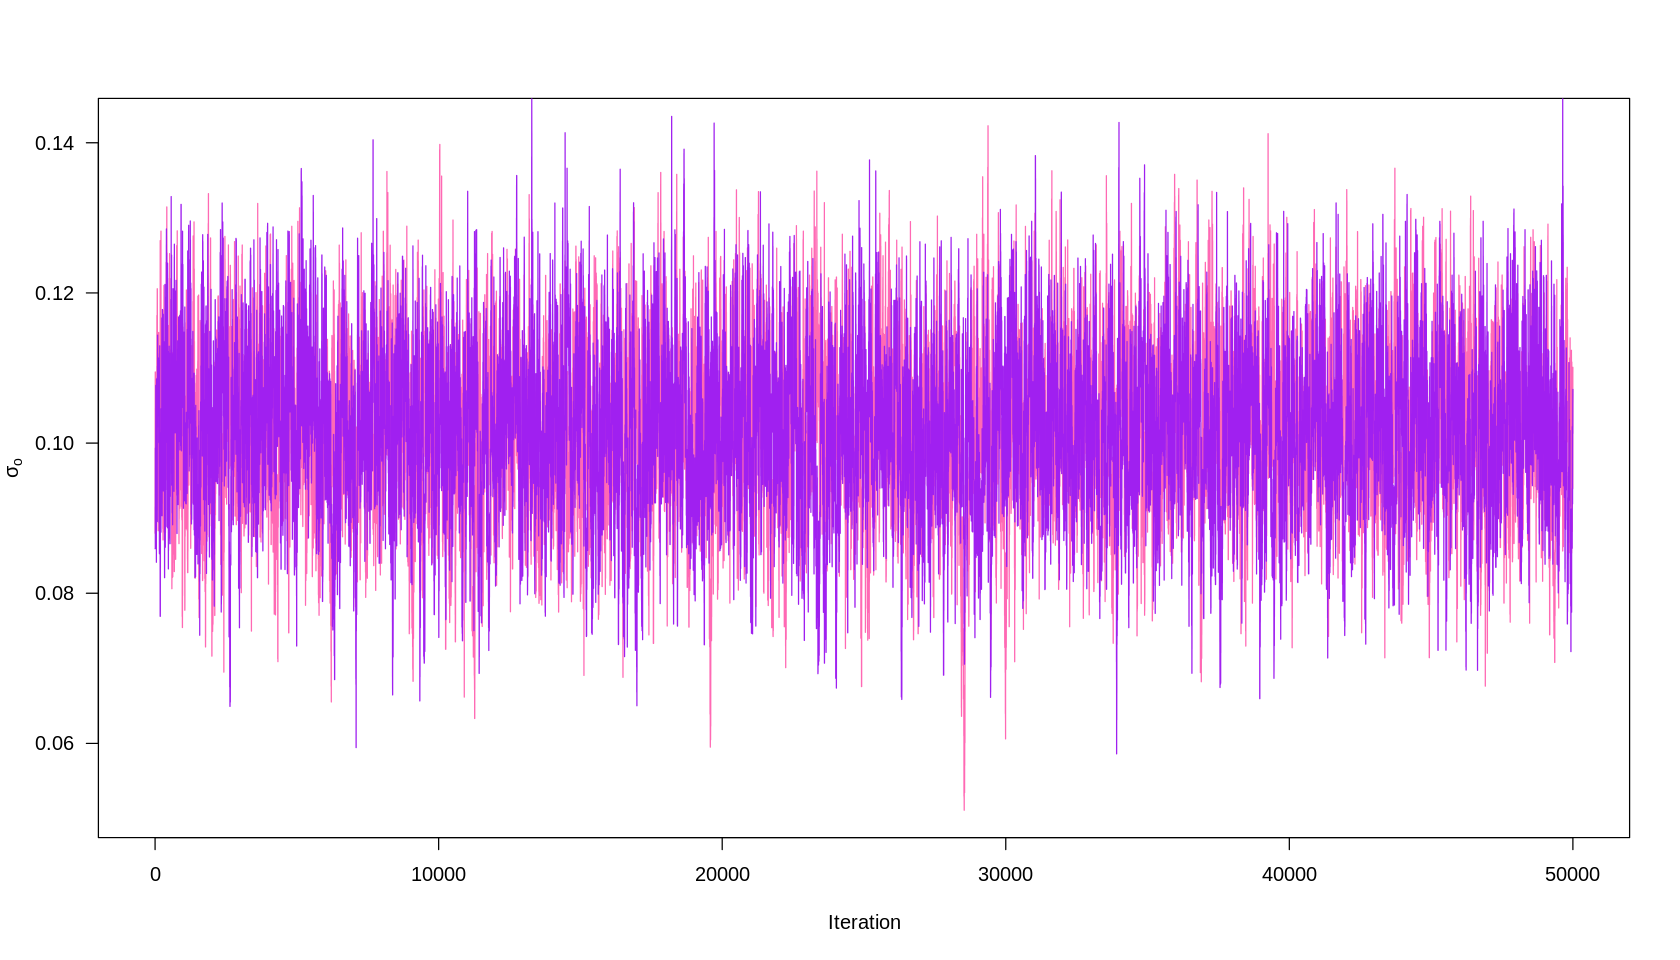

In [143]:
# Trace plots for sdp and sdo
plot(
    nimble_out$chain1[, "sdp"], type = "l",
    xlab = "Iteration",
    ylab = expression(sigma[p]),
    col = "hotpink",
    las = 1
)

lines(
    nimble_out$chain2[, "sdp"],
    col = "purple"
)

plot(
    nimble_out$chain1[, "sdo"], type = "l",
    xlab = "Iteration",
    ylab = expression(sigma[o]),
    col = "hotpink",
    las = 1
)

lines(
    nimble_out$chain2[, "sdo"],
    col = "purple"
)

In [144]:
# Compute posterior means of the states
# Extract z columns (columns 3 through TT+2)
z_samples <- rbind(
    nimble_out$chain1[, 3:(time_steps + 2)],
    nimble_out$chain2[, 3:(time_steps + 2)]
)
zs_nimble <- colMeans(z_samples)

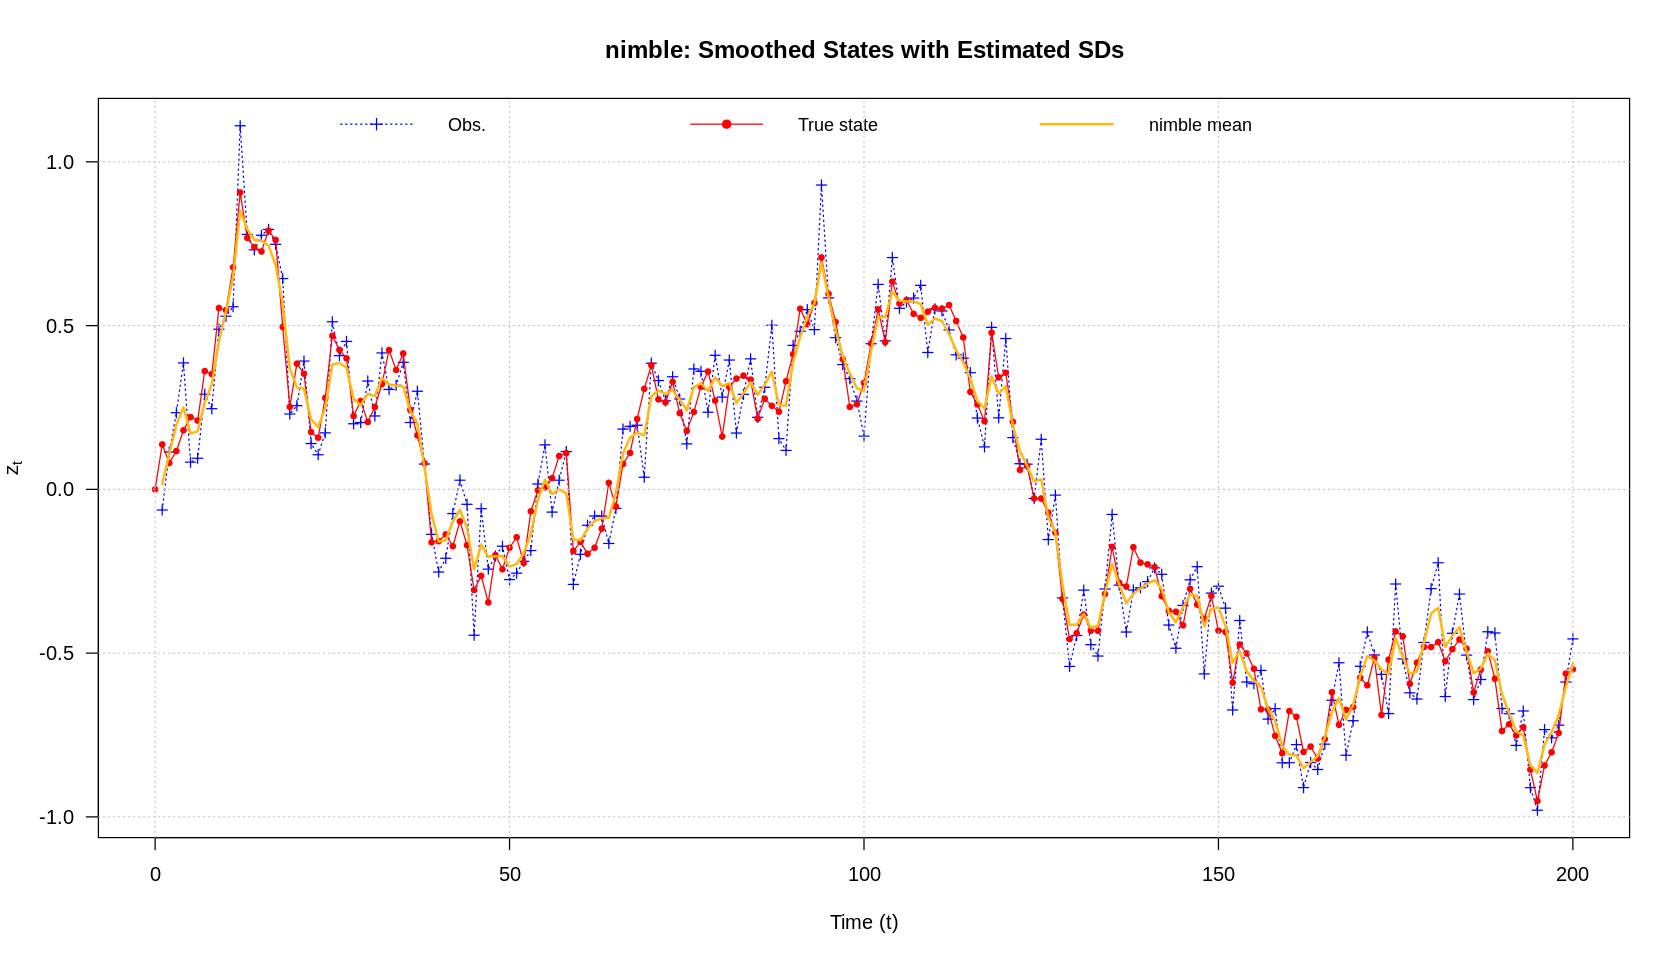

In [145]:
# Plot estimated states vs. true
obs_idx <- 1:time_steps
all_idx <- 0:time_steps

plot(
    obs_idx,
    obs_y,
    type = "o",
    pch = 3,
    cex = 0.8,
    col = "blue",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, states_z, zs_nimble)),
    las = 1,
    main = "nimble: Smoothed States with Estimated SDs"
)

points(
    all_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

lines(
    obs_idx,
    zs_nimble,
    col = "darkgoldenrod1",
    lwd = 2
)

legend(
    "top",
    legend = c("Obs.", "True state", "nimble mean"),
    pch = c(3, 19, NA),
    col = c("blue", "red", "darkgoldenrod1"),
    lty = c(3, 1, 1),
    lwd = c(1, 1, 2),
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

In [146]:
# Convergence diagnostics with coda
coda_nimble <- convert.mcmc.list(nimble_out)
gelman_stats <- gelman.diag(coda_nimble)

# Potential scale reduction factors
# If all values are below the 1.1 threshold, then chains have likely converged
head(gelman_stats$psrf)

# Multivariate PSRF
cat("\n")
print(gelman_stats$mpsrf)

Point est. Upper C.I.
sdo  1.0002037  1.000991  
sdp  1.0001967  1.000678  
z[1] 0.9999968  1.000061  
z[2] 0.9999878  1.000011  
z[3] 1.0002034  1.000867  
z[4] 1.0003340  1.001668


[1] 1.007104


# Stan

In [147]:
# Set parallel + I/O options
options(mc.cores = parallel::detectCores())     # Use all available cores
rstan_options(auto_write = TRUE)                # Cache compiled Stan models

# Write the Stan model to a file
stan_code <- "
data {
  int<lower=1> TT;        // Number of time points
  vector[TT] y;           // Observations
  real z0;                // Known initial state
}

parameters {
  real<lower=0> sdp;      // Process noise SD
  real<lower=0> sdo;      // Observation noise SD
  vector[TT] z;           // Latent states
}

model {
  // Priors on SDs
  sdo ~ normal(0, 1);
  sdp ~ normal(0, 1);

  // Process equation
  z[1] ~ normal(z0, sdp);
  for (t in 2:TT)
    z[t] ~ normal(z[t-1], sdp);

  // Observation equation
  for (t in 1:TT)
    y[t] ~ normal(z[t], sdo);
}
"
writeLines(stan_code, con = "toy2p.stan")

In [148]:
# Prepare data list for Stan
stan_data <- list(
    TT = time_steps,
    y = obs_y,
    z0 = 0
)

In [149]:
# Fit the model via Stan
fit_stan <- stan(
    file = "toy2p.stan",
    data = stan_data,
    chains = 3,
    iter = 3000
)

Inference for Stan model: anon_model.
3 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

     mean se_mean    sd  2.5%   25%   50%   75% 97.5% n_eff  Rhat
sdp 0.100   0.001 0.013 0.078 0.091 0.099 0.107 0.127   497 1.007
sdo 0.102   0.000 0.011 0.079 0.095 0.102 0.109 0.122   574 1.006

Samples were drawn using NUTS(diag_e) at Fri Apr 25 08:25:50 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Divergences:


0 of 4500 iterations ended with a divergence.




Tree depth:


0 of 4500 iterations saturated the maximum tree depth of 10.




Energy:


E-BFMI indicated no pathological behavior.



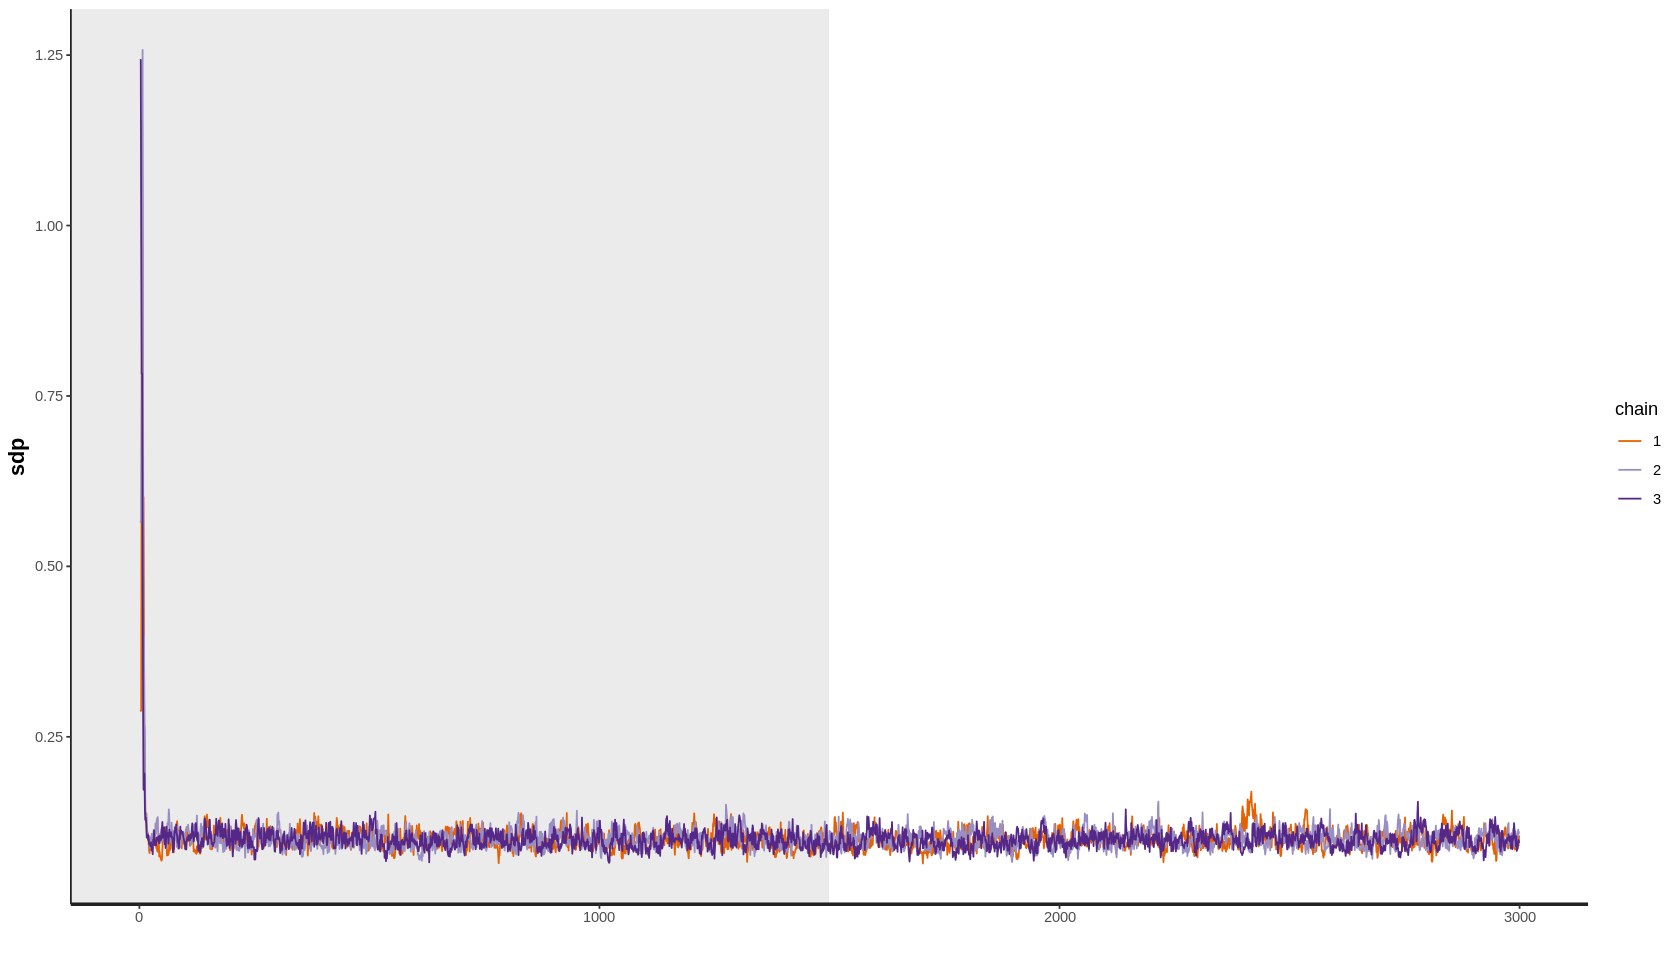

In [150]:
# Diagnostics and convergence checks
traceplot(fit_stan, pars = "sdp", inc_warmup = TRUE)
print(fit_stan, pars = c("sdp", "sdo"), probs = c(0.025, 0.25, 0.5, 0.75, 0.975), digits = 3)
rstan::check_hmc_diagnostics(fit_stan)

In [151]:
# Extract posterior samples
post <- rstan::extract(fit_stan)
z_samples <- post$z       # matrix: iterations × TT
sdp_samples <- post$sdp
sdo_samples <- post$sdo

In [152]:
# Summarize latent states: posterior means and 95% CI
z_means_stan <- colMeans(z_samples)
z_lower_stan <- apply(z_samples, 2, quantile, probs = 0.025)
z_upper_stan <- apply(z_samples, 2, quantile, probs = 0.975)

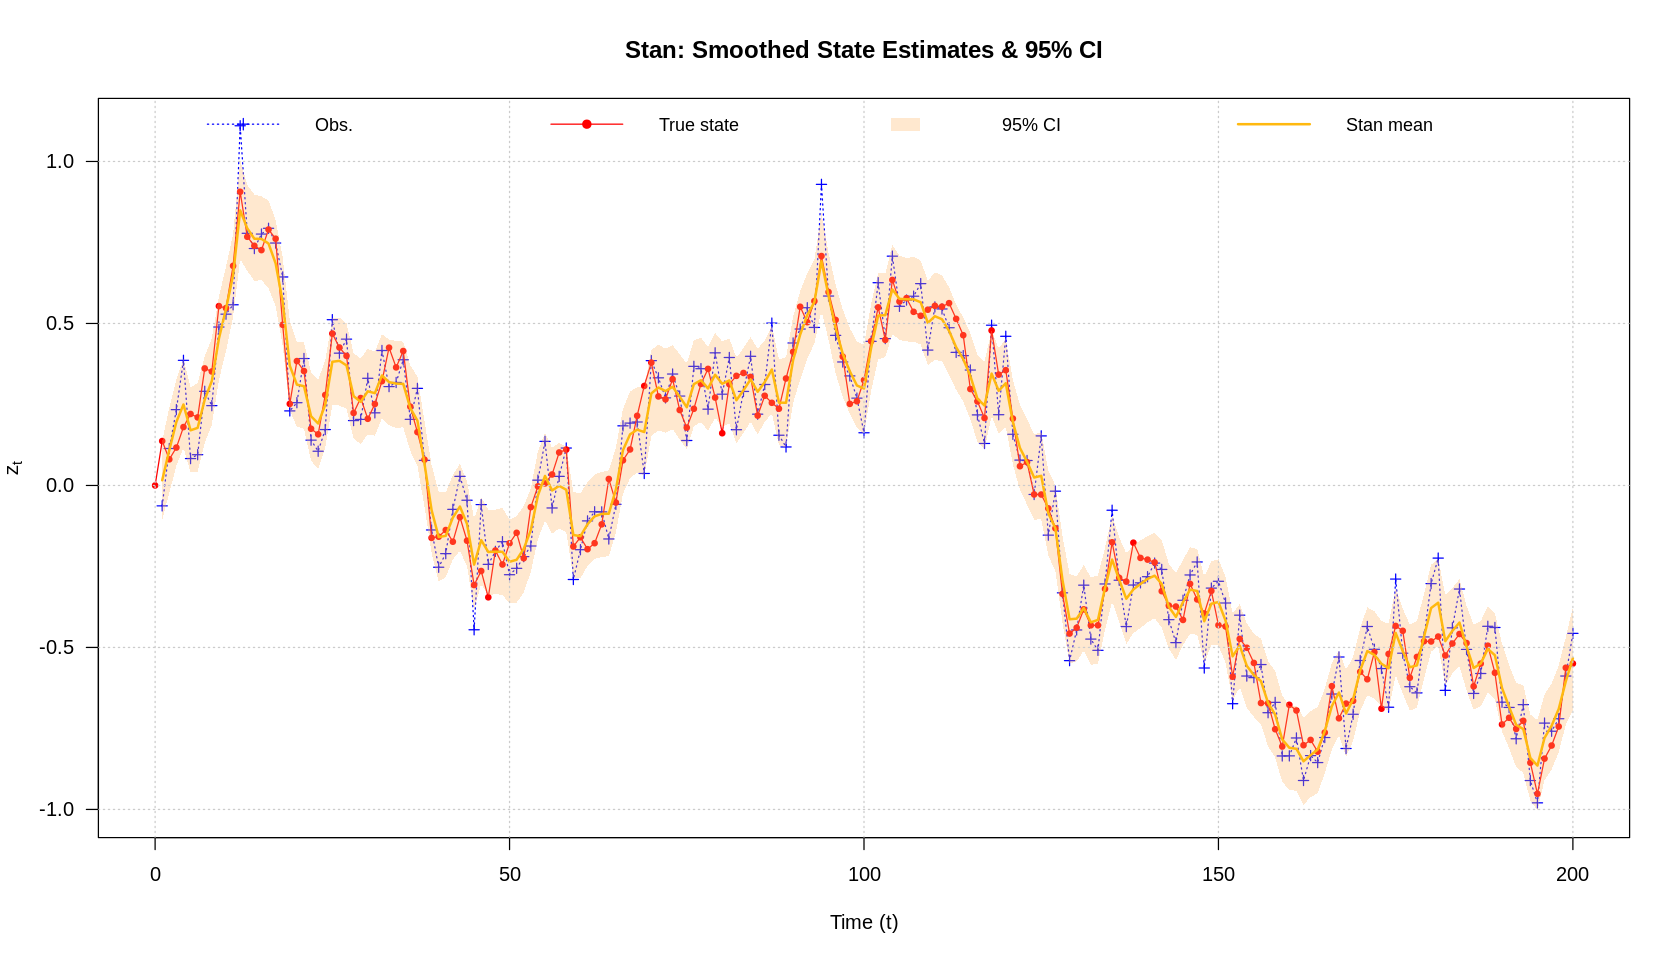

In [153]:
# Plot smoothed states with credible intervals
time_idx <- 0:time_steps
obs_idx <- 1:time_steps

plot(
    obs_idx,
    obs_y,
    type = "o",
    pch = 3,
    cex = 0.8,
    col = "blue",
    lty = 3,
    xlab = "Time (t)",
    ylab = expression(z[t]),
    xlim = c(0, time_steps),
    ylim = range(c(obs_y, z_lower_stan, z_upper_stan)),
    las = 1,
    main = "Stan: Smoothed State Estimates & 95% CI"
)

# True latent state
points(
    time_idx,
    states_z,
    type = "o",
    pch = 19,
    cex = 0.6,
    col = "red"
)

# Credible interval ribbon
polygon(
    x = c(obs_idx, rev(obs_idx)),
    y = c(z_lower_stan, rev(z_upper_stan)),
    col = rgb(1, 0.7, 0.4, 0.3),
    border = NA
)

# Posterior mean line
lines(
    obs_idx,
    z_means_stan,
    lwd = 2,
    col = "darkgoldenrod1"
)

# Legend
legend(
    "top",
    legend = c("Obs.", "True state", "95% CI", "Stan mean"),
    pch = c(3, 19, NA, NA),
    col = c("blue", "red", NA, "darkgoldenrod1"),
    lty = c(3, 1, NA, 1),
    lwd = c(1, 1, NA, 2),
    fill = c(NA, NA, rgb(1, 0.7, 0.4, 0.3), NA),
    border = NA,
    horiz = TRUE,
    bty = "n",
    cex = 0.9
)

# Grid
grid(
    nx = NULL,
    ny = NULL,
    col = "gray80",
    lty = "dotted"
)

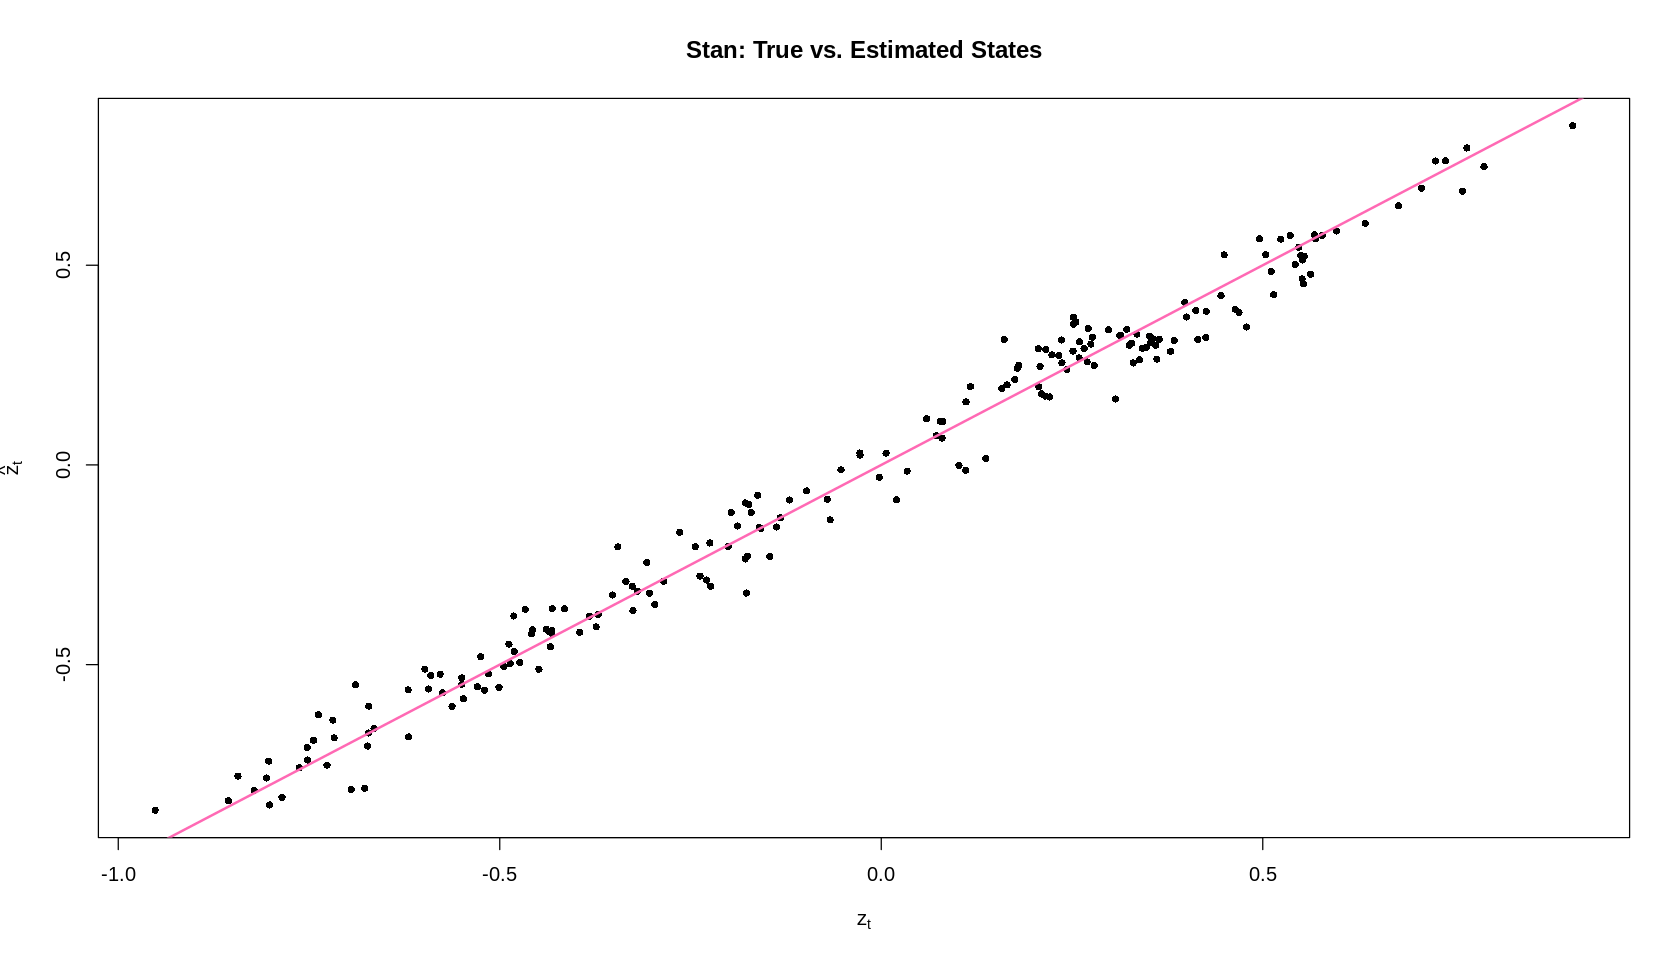

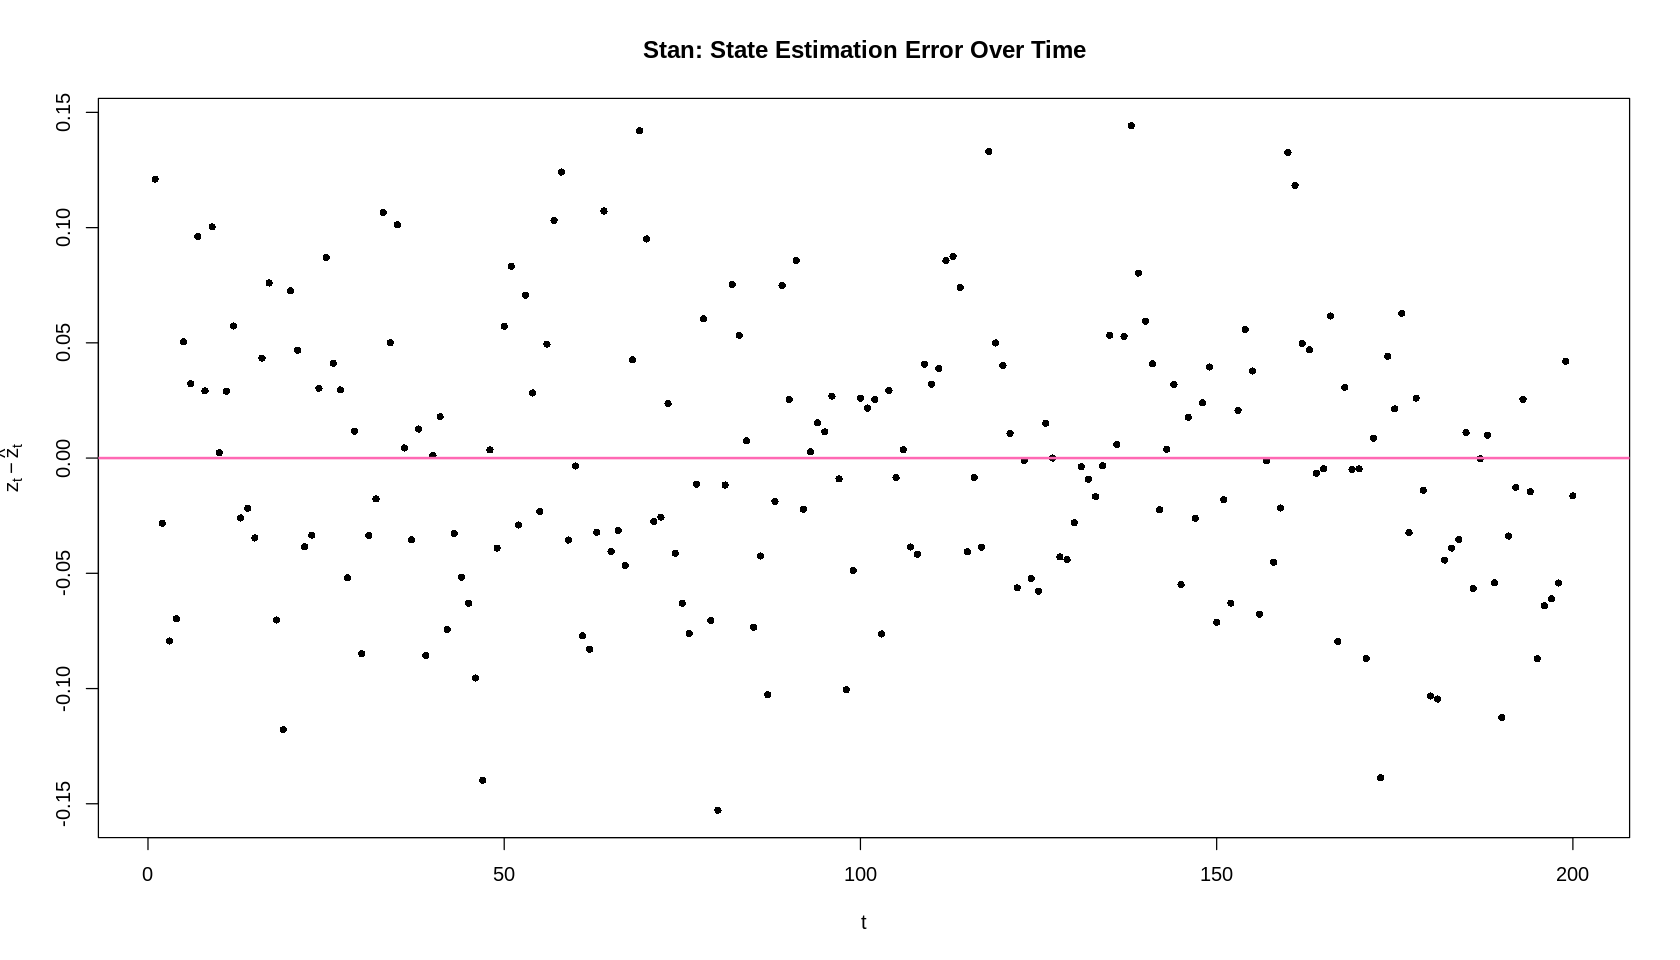

In [154]:
# True latent states at t = 1…T (drop z0)
true_states <- states_z[-1]

# Scatterplot: true vs. estimated states
plot(
    true_states,
    z_means_stan,
    xlab = expression(z[t]),
    ylab = expression(hat(z)[t]),
    pch = 16,
    cex = 0.8,
    main = "Stan: True vs. Estimated States"
)
abline(0, 1, col = "hotpink", lwd = 2)

# Time‐series of estimation error
err_stan <- true_states - z_means_stan
plot(
    seq_len(time_steps),
    err_stan,
    xlab = "t",
    ylab = expression(z[t] - hat(z)[t]),
    pch = 16,
    cex = 0.8,
    main = "Stan: State Estimation Error Over Time"
)
abline(h = 0, col = "hotpink", lwd = 2)

# Identifiability Assessment

In [155]:
# Compute the Hessian matrix of a log‐likelihood function at given params
hessian_fun <- function(loglik_fn, params, y, delta) {
  p <- length(params)
  H <- matrix(0, p, p)
  Dx <- delta * diag(p)
  for (i in seq_len(p)) {
    for (j in seq_len(i)) {
      f_pp <- loglik_fn(params + Dx[i, ] + Dx[j, ], y)
      f_pm <- loglik_fn(params + Dx[i, ] - Dx[j, ], y)
      f_mp <- loglik_fn(params - Dx[i, ] + Dx[j, ], y)
      f_mm <- loglik_fn(params - Dx[i, ] - Dx[j, ], y)
      H[i, j] <- (f_pp - f_pm - f_mp + f_mm) / (4 * delta^2)
      H[j, i] <- H[i, j]
    }
  }
  H
}

In [156]:
# Apply Hessian method: eigenvalues and estimable parameter count
hessian_method <- function(loglik_fn, mle_params, y,
                           delta = 1e-5,
                           verbose = TRUE) {
  p <- length(mle_params)
  cutoff <- delta * p
  H <- hessian_fun(loglik_fn, mle_params, y, delta)
  eig <- eigen(H, symmetric = TRUE, only.values = TRUE)$values
  std_eig <- abs(eig) / max(abs(eig))
  n_estimable <- sum(std_eig > cutoff)
  if (verbose) {
    if (min(std_eig) < cutoff) {
      message("Model is non-identifiable or parameter-redundant")
    } else {
      message("Model is identifiable (no parameter redundancy)")
    }
    message("Smallest standardized eigenvalue: ",
            signif(min(std_eig), 3))
    message("Number of estimable parameters: ",
            n_estimable)
  }
  list(std_eig = std_eig,
       n_estimable = n_estimable)
}

In [157]:
# Define 3-parameter SSM log-likelihood
# z[t] = β1 * β2 * z[t-1] + process noise; y[t] = α * z[t] + obs noise
build_model_3p <- function(theta) {
  dlm(
    m0 = 0,
    C0 = 0,
    GG = theta[1] * theta[2],
    W = 0.1^2,      # β1 * β2 and process variance
    FF = theta[3],
    V = 0.1^2       # α and observation variance
  )
}

loglik_3p <- function(theta, y) {
    mod <- build_model_3p(theta)
    dlmLL(y = y, mod = mod)   # Returns log‐likelihood
}

In [158]:
# Find MLE for 3-parameter model
init_theta_3p <- c(β1 = 1, β2 = 1, α = 1)
fit_3p <- dlmMLE(y = obs_y, parm = init_theta_3p, build = build_model_3p)

# Test identifiability for 3-parameter model
res_3p <- hessian_method(loglik_3p, fit_3p$par, obs_y)

Model is non-identifiable or parameter-redundant

Smallest standardized eigenvalue: 5.66e-08

Number of estimable parameters: 2



In [159]:
# Repeat for reparameterized 2-parameter model (β = β1*β2)
build_model_2p <- function(theta) {
  dlm(
    m0 = 0,
    C0 = 0,
    GG = theta[1],
    W = 0.1^2,  # β
    FF = theta[2],
    V = 0.1^2   # α
  )
}

loglik_2p <- function(theta, y) {
    mod <- build_model_2p(theta)
    dlmLL(y = y, mod = mod)
}

In [160]:
# Find MLE for 2-parameter model
init_theta_2p <- c(β = 1, α = 1)
fit_2p <- dlmMLE(y = obs_y, parm = init_theta_2p, build = build_model_2p)

In [161]:
# Test identifiability for 2-parameter model
res_2p <- hessian_method(loglik_2p, fit_2p$par, obs_y)

Model is identifiable (no parameter redundancy)

Smallest standardized eigenvalue: 0.0265

Number of estimable parameters: 2

